In [1]:
import traci

import math

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import parl
from parl import layers
from paddle import fluid

import paddle.fluid as fluid


In [2]:
class MujocoModel(parl.Model):

    #set act dim = 3
    #set obs dim = 25 * 3

    def __init__(self, act_dim):
        self.actor_model = ActorModel(act_dim)
        self.critic_model = CriticModel()

    def policy(self, obs):
        
        return self.actor_model.policy(obs)

    def value(self, obs, act):
        return self.critic_model.value(obs, act)

    def get_actor_params(self):
        return self.actor_model.parameters()


class ActorModel(parl.Model):
    def __init__(self, act_dim):
        hid1_size = 400
        hid2_size = 300

        self.fc1 = layers.fc(size=hid1_size, act='relu')
        self.fc2 = layers.fc(size=hid2_size, act='relu')
        self.fc3 = layers.fc(size=act_dim, act='tanh')

    def policy(self, obs):
        hid1 = self.fc1(obs)
        hid2 = self.fc2(hid1)
        means = self.fc3(hid2)
        return means


class CriticModel(parl.Model):
    def __init__(self):
        hid1_size = 400
        hid2_size = 300

        self.fc1 = layers.fc(size=hid1_size, act='relu')
        self.fc2 = layers.fc(size=hid2_size, act='relu')
        self.fc3 = layers.fc(size=1, act=None)

    def value(self, obs, act):
        hid1 = self.fc1(obs)
        concat = layers.concat([hid1, act], axis=1)
        hid2 = self.fc2(concat)
        Q = self.fc3(hid2)
        Q = layers.squeeze(Q, axes=[1])
        return Q


In [3]:
class MujocoAgent(parl.Agent):
    def __init__(self, algorithm, obs_dim, act_dim):
        assert isinstance(obs_dim, int)
        assert isinstance(act_dim, int)
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        super(MujocoAgent, self).__init__(algorithm)

        # Attention: In the beginning, sync target model totally.
        self.alg.sync_target(decay=0)

    def build_program(self):
        self.pred_program = fluid.Program()
        self.learn_program = fluid.Program()

        with fluid.program_guard(self.pred_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            self.pred_act = self.alg.predict(obs)

        with fluid.program_guard(self.learn_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            act = layers.data(
                name='act', shape=[self.act_dim], dtype='float32')
            reward = layers.data(name='reward', shape=[], dtype='float32')
            next_obs = layers.data(
                name='next_obs', shape=[self.obs_dim], dtype='float32')
            terminal = layers.data(name='terminal', shape=[], dtype='bool')
            _, self.critic_cost = self.alg.learn(obs, act, reward, next_obs,
                                                 terminal)

    def predict(self, obs):
        obs = np.expand_dims(obs, axis=0)
        act = self.fluid_executor.run(
            self.pred_program, feed={'obs': obs},
            fetch_list=[self.pred_act])[0]
        act = np.squeeze(act)
        act = np.absolute(act)
        return act

    def learn(self, obs, act, reward, next_obs, terminal):
        feed = {
            'obs': obs,
            'act': act,
            'reward': reward,
            'next_obs': next_obs,
            'terminal': terminal
        }
        critic_cost = self.fluid_executor.run(
            self.learn_program, feed=feed, fetch_list=[self.critic_cost])[0]
        self.alg.sync_target()
        return critic_cost


In [4]:
def calDis(p1, p2):

     dx = float(p1[0]) - float(p2[0])
     dy = float(p1[1]) - float(p2[1])
     return math.sqrt((dx**2)+(dy**2))


def calSpeedD(v1, v2):
     v1 = float(v1)
     v2 = float(v2)
     return math.fabs(v1 - v2)


def calAccD(a1, a2):
     a1 = float(a1)
     a2 = float(a2)
     return math.fabs(a1 - a2)


def getDifferenceData(obs):

     diffList = []
     totalDiffPos = 0
     totalDifSpeed = 0
     totalDifAcc = 0
     communicationRange = 30
     averageSpeed = 0
     averageAcc = 0
     connection ={}
     for v in obs:

          vCollectedDis = []
          vCollectedSpeedDis = []
          vCollectedAccDis = []
          vCollectCommCars = []
          averageSpeed += v[2]
          averageAcc += v[3]
          
          for i in range(0, len(obs)):
               tempCar = obs[i]
               if v[0] != tempCar[0]:
                    distance = calDis(v[1], tempCar[1])   
                    if distance < communicationRange:
                        vCollectCommCars.append(tempCar[0])
                        vCollectedDis.append(distance)
                        speedDis = calSpeedD(v[2], tempCar[2])
                        vCollectedSpeedDis.append(speedDis)
                        accDis = calAccD(v[3], tempCar[3])
                        vCollectedAccDis.append(accDis)
                    

          diffList.append([v[0], np.mean(vCollectedDis), np.mean(
          vCollectedSpeedDis), np.mean(vCollectedAccDis), vCollectCommCars])
          connection[v[0]] = vCollectCommCars
     vehicleNum = len(diffList)
     obsMobility = [0,0,0]
     if vehicleNum !=0:  
         obsMobility = [averageSpeed / vehicleNum, averageSpeed / vehicleNum ]
     result = [obsMobility ,connection ]
     # print(len( diffList))
     return diffList, result

In [5]:
def clusterCreation(diffList, clusterNumber, obsPD, obs, obsMobility,action ):
#      w1 = 0.2
#      w2 = 0.4
#      w3 = 0.4
#      w1 = 0.6
#      w2 = 0.1
#      w3 = 0.3
#      w1 = 1
#      w2 = 1
#      w3 = 1
     w1  = action[0]
     w2 = action[1]
     w3 = action[2]
     t = 0
     dic = {}
#      obsMobility = obsMobility[0]
     for singleV in diffList:
            if len(singleV[4]) not in dic:
                dic[len(singleV[4])]  = [singleV[0]]
            else:
                dic[len(singleV[4])].append(singleV[0])
     if len(dic.keys()) > 3:
       
        clusters = sorted(dic.keys(),reverse=True)[:3]
        
     else:
        clusters = sorted(dic.keys(),reverse=True)
    
#      for x in dic:
#             print(x)
#      print("zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz")
    
#      for i in action:
#         t += abs(i)
#      w1 = action[0] / t
#      w2 = action[1] /t
#      w3 = action[2] /t
     tempScore = 100000
     communicationRange = 30
     sequenceScores = []
     if obsMobility[0] == 0:
        obsMobility[0] = 1
     if obsMobility[1] == 0:
        obsMobility[1] = 1
    
     scoreDic = {}
     for singleV in diffList:
          score = w1 * singleV[1] / 30  + w2 * singleV[2] / obsMobility[0] + w3 * singleV[3] / obsMobility[1]
          scoreDic[singleV[0]] = score
        
     clusterHeads = {}
     for c in clusters:
        s =  1000
        
        if len(dic[c]) > 1:
            clusterHead = ""
            for v in dic[c]:
                if scoreDic[v] < s:
                    clusterHead = v
                    s = scoreDic[v]
                
#         print(clusterHead)
            if clusterHead !='':
                clusterHeads[clusterHead] = c
     
     return clusterHeads

In [6]:

episode = 0
performanceCollect = []
lifeTimeCollect = []
goneClusterHeadCollect = []
performance = {}
performanceFull = {}
clusterDic = {}
record = {}
currentClusters = []
teeeeee = 0
maxV = 0
while episode < 1:
    episode += 1

    traci.start(["sumo", "-c", "highway.sumocfg"])
    resTemp = {}
    inputObs = []
    while traci.simulation.getMinExpectedNumber() > 0:
            
        ls = traci.vehicle.getIDList()
        if len(ls) > maxV:
            maxV = len(ls)
      
        obs = []
        for veh_id in ls:
            position = traci.vehicle.getPosition(veh_id)
            speed = traci.vehicle.getSpeed(veh_id)
            acceleration = traci.vehicle.getAcceleration(veh_id)
            singleV = [veh_id, position, speed, acceleration]
            obs.append(singleV)
                  
        obsPD = pd.DataFrame(
              obs, columns=['V-ID', 'Position', 'Speed', 'Acc'])
            
           
        if len(obs) > 2:
            if len(currentClusters) < 3:
                difflist, obsMobility = getDifferenceData(obs)
        #           print(difflist, obsMobility)

                nextObs = obsMobility
    #                 if len(currentClusters) == 0:
    #                     c = clusterCreation(difflist, 8, obsPD, obs,obsMobility[0])
    #                     currentClusters = list(c.keys())
    #                 gone = []
    #                 for i in currentClusters:
    #                     if i not in ls:
    #                         gone.append(i)
    #                         c = clusterCreation(difflist, 8, obsPD, obs,obsMobility[0])
    #                         currentClusters = list(set(currentClusters + list(c.keys()) ))
    #                 currentClusters = list(set(currentClusters) - set(gone))
    #                 print(currentClusters)

    #                 c = clusterCreation(difflist, 8, obsPD, obs,obsMobility[0])
    #                 for v in c:
    #                     if v not in currentClusters:
    #                         currentClusters[v] =1
    #                 for v in currentClusters:
    #                     if v in ls:
    #                         currentClusters[v] += 1
    #                 print(currentClusters)









                c = clusterCreation(difflist, 8, obsPD, obs,obsMobility[0])
                for x in c:
                    if len(currentClusters) <3:
                        currentClusters.append(x)
    #                 print(c)
            gone = []
            for h in currentClusters :
                if h not in clusterDic:
                    clusterDic[h] = 0
                    record[h] = 0
                        
            for h in clusterDic:
                if h in ls:
                    clusterDic[h] +=1     
                else:
                    if h in record:
                        gone.append(clusterDic[h])
                        del record[h]

            print(gone)
#                 print(ls)
            goneClusterHeadCollect.append(gone)
            
            
        traci.simulationStep()
         
#           for k in res:
#               if k in performance:
#                  performance[k] += 1
#               else:
#                  performance[k] = 1
#               if k in performanceFull:
#                  performanceFull[k] += 1
#               else:
#                  performanceFull[k] = 1
             
#           resTemp = res
#           # print(performance)

#           # 根据performance 计算平均生命周期的增加
# #           totalLife = 0
# #           for k in performance:
# #                totalLife += performance[k]
                
#           totalLife = 0
#           goneClusterHead = []
#           for k in performance:
#                if k not in ls:
#                    goneClusterHead.append(k)
#           totalLife = 0
#           if len(goneClusterHead) > 0:
#                for k in goneClusterHead:
#                    totalLife += performance[k]
#                    del performance[k]
          
#                lifeTimeCollect.append(totalLife / len(goneClusterHead))
               
#                reward = totalLife / len(goneClusterHead)
            
#                # we get reward , nextobs , 
                
                
    
            

#           goneClusterLife = 0
#           if len(goneClusterHead) > 0:
#                singleChange = []
#                for k in goneClusterHead:
#                     goneClusterLife += performance[k]
#                     del performance[k]
                    
#                lifeTimeCollect.append(goneClusterLife / len(goneClusterHead))
#           goneClusterHead = []
         
    
#           for k in performance:
#                totalLife += performance[k]
                
#           if len(performance) > 1:
#                # print(totalLife / len(performance))
#                performanceCollect.append(totalLife / len(performance))


          # merage条件
          # 形成新的cluster条件
          #  一个 function 遍历车辆信息，输出一个sdfsdf数组
          # 计算奖励 根据上一个fuction 输出的数组计算奖励
          #

          # action to do the clustering with obs
          # 遍历之前的cluster数组，发现汽车id不在cluster里的， 进行merage 到 现有cluster 或者 选出新的cluster head 形成新的cluster
          # merage条件
          # 形成新的cluster条件
          #
          # cal reward
          # reward =  calRward(cluster info in road : 数组 每一个cluster， cluster内汽车数量 ， cluster 数量    )

       
          # print(obs,reward)
       

traci.close()








TypeError: clusterCreation() missing 1 required positional argument: 'action'

In [108]:
maxV

30

In [86]:
traci.close()

AttributeError: 'Connection' object has no attribute '_socket'

In [24]:
cooo = []
for x in goneClusterHeadCollect:
    if len(x) > 0:
        life = 0
        for l in x:
            life += l
        cooo.append(life / len(x))
        
            

In [25]:
step = 1
total = 0
ress = []
for x in cooo:
    total += x
    
    ress.append(total / step)
    step+=1
    

    
step = 1
total = 0
res1 = []
for x in ClusterLifeFinalModel:
    total += x
    
    res1.append(total / step)
    step+=1

In [26]:
ress

[19.0, 21.0]

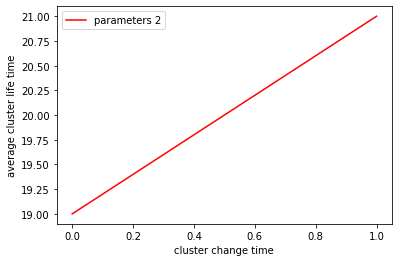

In [27]:
# plt.plot(range(0,len(res)), res, color='green', label='parameters 1')
plt.plot(range(0,len(ress)), ress, color='red', label='parameters 2')
plt.legend() # 显示图例

plt.xlabel('cluster change time')
plt.ylabel('average cluster life time')
plt.savefig("successRes.jpg")

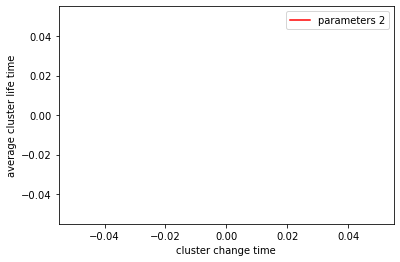

In [35]:

plt.plot(range(0,len(ress)), ress, color='red', label='parameters 2')
plt.legend() # 显示图例

plt.xlabel('cluster change time')
plt.ylabel('average cluster life time')
plt.savefig("successRes3.jpg")

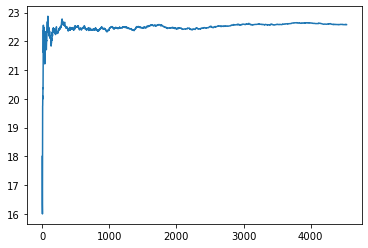

In [15]:
# x=range(0, len(res))
# y=res
# plt.plot(x, y)
# plt.savefig("y91.jpg")

In [10]:
temp1 = res # 1 10 60

In [16]:
temp2  =res #1 -1 -1

In [29]:
temp3 = res # 8 3 9

In [35]:
temp4 = res # 1 3 8

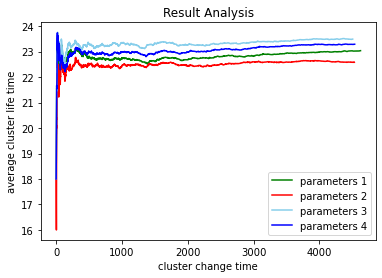

In [37]:
# sub_axix = filter(lambda x:x%200 == 0, x_axix)
plt.title('Result Analysis')
plt.plot(range(0,len(temp1)), temp1, color='green', label='parameters 1')
plt.plot(range(0,len(temp2)), temp2, color='red', label='parameters 2')
plt.plot(range(0,len(temp3)), temp3,  color='skyblue', label='parameters 3')
plt.plot(range(0,len(temp4)), temp4, color='blue', label='parameters 4')
plt.legend() # 显示图例

plt.xlabel('cluster change time')
plt.ylabel('average cluster life time')
plt.savefig("successRes.jpg")

In [17]:
step = 1
total = 0
res = []
for x in cooo:
    total += x
    
    res.append(total / step)
    step+=1
    
    

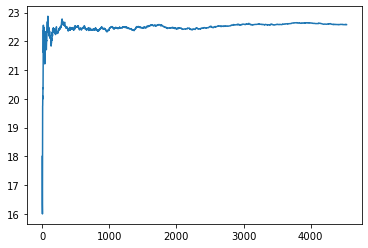

In [18]:
x=range(0, len(res))
y=res
plt.plot(x, y)
plt.savefig("y91.jpg")

In [16]:
performance

{'sporty.0': 3,
 'normal.0': 8,
 'coach.0': 8,
 'normal.1': 7,
 'trailer.0': 9,
 'normal.3': 9,
 'normal.4': 8,
 'normal.2': 5,
 'normal.5': 4,
 'normal.8': 5,
 'normal.6': 5,
 'normal.7': 6,
 'normal.9': 3,
 'normal.10': 5,
 'trailer.1': 8,
 'normal.13': 4,
 'normal.12': 5,
 'normal.11': 2,
 'normal.15': 2,
 'normal.14': 3,
 'normal.17': 4,
 'normal.16': 5,
 'trailer.2': 9,
 'sporty.1': 3,
 'coach.1': 5,
 'normal.18': 3,
 'normal.20': 3,
 'normal.21': 3,
 'normal.19': 4,
 'normal.22': 2,
 'normal.24': 7,
 'normal.23': 7,
 'trailer.3': 7,
 'normal.26': 3,
 'normal.27': 2,
 'normal.25': 5,
 'normal.29': 4,
 'normal.28': 3,
 'trailer.4': 2,
 'normal.30': 6,
 'normal.32': 6,
 'normal.31': 5,
 'normal.34': 6,
 'sporty.2': 2,
 'normal.33': 6,
 'normal.35': 7,
 'normal.36': 3,
 'coach.2': 6,
 'normal.38': 3,
 'normal.37': 3,
 'trailer.5': 4,
 'normal.40': 3,
 'normal.41': 4,
 'normal.39': 2,
 'normal.43': 3,
 'normal.42': 6,
 'normal.45': 6,
 'trailer.6': 7,
 'normal.44': 5,
 'normal.46': 3,

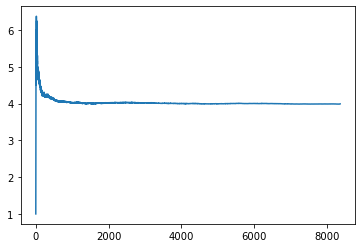

In [17]:
x=range(0, len(performanceCollect))
y=performanceCollect
plt.plot(x, y)
plt.savefig("t4.jpg")

In [25]:
performanceCollect

[1.0,
 2.0,
 2.0,
 2.75,
 3.5,
 4.25,
 5.0,
 3.5,
 4.0,
 3.7142857142857144,
 4.142857142857143,
 4.571428571428571,
 5.0,
 5.428571428571429,
 5.857142857142857,
 5.375,
 4.888888888888889,
 4.888888888888889,
 5.111111111111111,
 4.444444444444445,
 4.2,
 4.5,
 4.555555555555555,
 4.75,
 3.9,
 4.2,
 3.6,
 3.4545454545454546,
 3.3333333333333335,
 3.272727272727273,
 3.5454545454545454,
 3.9,
 3.4,
 2.8,
 2.7777777777777777,
 2.2,
 2.0,
 2.3333333333333335,
 2.3,
 2.5,
 2.3636363636363638,
 2.6,
 2.0,
 2.1818181818181817,
 2.5,
 2.1,
 2.4,
 2.4,
 2.2,
 2.0,
 2.1,
 2.4,
 2.7,
 2.6363636363636362,
 2.7,
 2.7,
 2.888888888888889,
 2.6666666666666665,
 3.0,
 3.0,
 3.375,
 2.875,
 1.8888888888888888,
 1.9,
 2.2,
 2.625,
 2.5555555555555554,
 2.888888888888889,
 2.4,
 2.6666666666666665,
 2.375,
 2.75,
 3.0,
 3.375,
 2.8,
 3.1,
 3.4,
 2.909090909090909,
 3.1,
 3.5555555555555554,
 2.8,
 2.888888888888889,
 2.875,
 2.0,
 2.3333333333333335,
 1.6666666666666667,
 1.7,
 1.7272727272727273,
 2.

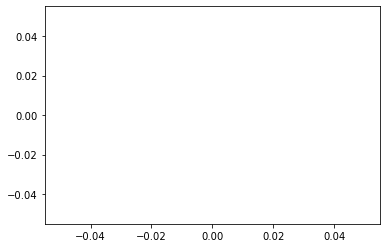

In [41]:
x=range(0, len(lifeTimeCollect))
y=lifeTimeCollect
plt.plot(x, y)
plt.savefig("life4.jpg")

In [27]:
len(lifeTimeCollect)

4842

In [25]:
goneClusterHeadCollect[50:60]

[['normal.17'],
 ['normal.16'],
 ['sporty.1'],
 [],
 [],
 [],
 ['trailer.2'],
 ['coach.1'],
 ['normal.21'],
 ['normal.18', 'normal.20']]

In [27]:
disappearCarNums = []
for x in goneClusterHeadCollect:
    if len(x) > 0:
        disappearCarNums.append(len(x))
        
    

In [28]:
disappearCarNums

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 3,
 3,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 3,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,


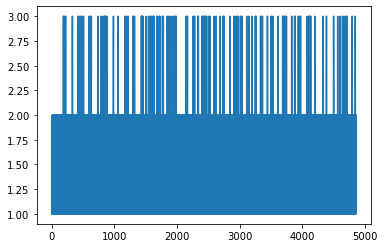

In [29]:
x=range(0, len(disappearCarNums))
y=disappearCarNums
plt.plot(x, y)
plt.savefig("vehicleClusterDead.jpg")

In [30]:
disappearCarAverageTime = []
for x in goneClusterHeadCollect:
    if len(x) > 0:
        totalLife = 0
        for v in x:
            totalLife += performanceFull[v]
            
        disappearCarAverageTime.append(totalLife / len(x))

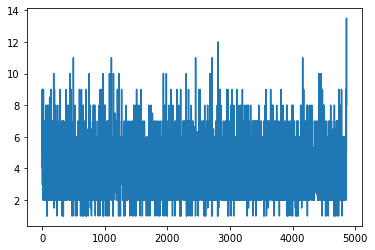

In [31]:
x=range(0, len(disappearCarAverageTime))
y=disappearCarAverageTime
plt.plot(x, y)
plt.savefig("vehicleClusterAverageLife.jpg")

In [5]:
lifeTimeCollect

[3.0,
 8.0,
 8.0,
 7.0,
 9.0,
 8.0,
 4.0,
 9.0,
 5.0,
 6.0,
 5.0,
 4.0,
 4.0,
 5.0,
 2.0,
 5.0,
 3.0,
 4.0,
 5.0,
 3.0,
 9.0,
 5.0,
 3.0,
 3.0,
 3.0,
 7.0,
 7.0,
 2.5,
 4.0,
 3.0,
 6.0,
 6.0,
 5.0,
 2.0,
 4.0,
 6.0,
 6.0,
 7.0,
 4.5,
 3.0,
 3.0,
 3.5,
 2.0,
 3.0,
 4.0,
 6.0,
 6.0,
 4.0,
 3.0,
 7.0,
 3.0,
 5.0,
 3.5,
 3.0,
 2.0,
 5.0,
 3.0,
 8.0,
 5.5,
 2.0,
 3.0,
 3.0,
 3.0,
 4.0,
 4.0,
 2.0,
 5.0,
 2.0,
 3.5,
 3.0,
 5.0,
 6.5,
 4.0,
 2.0,
 6.0,
 1.0,
 6.0,
 6.0,
 1.0,
 3.5,
 4.0,
 3.0,
 3.5,
 4.0,
 5.0,
 8.0,
 3.5,
 3.0,
 3.0,
 3.5,
 4.0,
 5.0,
 3.0,
 3.5,
 3.0,
 3.0,
 2.0,
 6.0,
 8.0,
 7.0,
 2.0,
 3.0,
 3.5,
 6.0,
 6.0,
 2.0,
 4.5,
 5.0,
 4.0,
 5.0,
 3.0,
 2.0,
 6.0,
 2.0,
 4.0,
 6.0,
 4.0,
 3.0,
 3.0,
 3.0,
 8.5,
 4.5,
 4.0,
 5.0,
 4.0,
 2.0,
 2.0,
 3.5,
 3.0,
 3.5,
 3.0,
 3.0,
 6.0,
 4.0,
 3.0,
 3.0,
 8.0,
 3.0,
 2.5,
 2.0,
 5.0,
 3.0,
 9.0,
 3.0,
 3.0,
 5.0,
 7.0,
 4.0,
 2.0,
 5.0,
 4.0,
 2.0,
 3.0,
 2.0,
 5.0,
 5.0,
 6.0,
 3.0,
 3.5,
 7.0,
 5.0,
 6.0,
 3.0,
 4.0,
 3.0,
 2.0,
 2.0

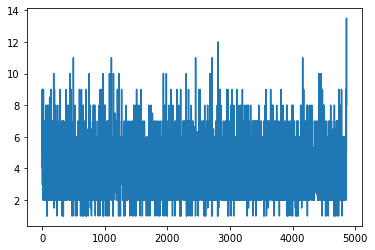

In [6]:
x=range(0, len(lifeTimeCollect))
y=lifeTimeCollect
plt.plot(x, y)
plt.savefig("vehicleClusterAverageLife1.jpg")

In [6]:
currentClusters = []
def highway(action):
    clusterChange = False
    obsMobility = 0 
    reward = 0
    obsOut = []
    done = False
    while clusterChange != True:
        ls = traci.vehicle.getIDList()
        obs = []
        for veh_id in ls:
            position = traci.vehicle.getPosition(veh_id)
            speed = traci.vehicle.getSpeed(veh_id)
            acceleration = traci.vehicle.getAcceleration(veh_id)
            singleV = [veh_id, position, speed, acceleration]
            obs.append(singleV)
                        #   print(veh_id ,position,speed,acceleration)



              # print(obs,reward)
        obsPD = pd.DataFrame(
              obs, columns=['V-ID', 'Position', 'Speed', 'Acc'])
        
        difflist, obsMobility = getDifferenceData(obs)
        if traci.simulation.getMinExpectedNumber() == 3 :
            done = True
        
        c = clusterCreation(difflist, 8, obsPD, obs,obsMobility[0], action)
#                 print(c)
        gone = []
        for h in c :
            if h not in clusterDic:
                clusterDic[h] = 0
                record[h] = 0
                        
        for h in clusterDic:
            if h in ls:
                clusterDic[h] +=1     
            else:
                if h in record:
                    gone.append(clusterDic[h])
                    del record[h]
        traci.simulationStep()
        if len(gone) > 0:
            clusterChange = True
#             print(np.mean(gone))
            reward = np.mean(gone) - 48.8
            for x in obs:
                obsOut.append(x[1][0])
                obsOut.append(x[1][1])
                obsOut.append(x[2])
                obsOut.append(x[3])
            if len(obsOut) < 150:
                for x in range(0, 150 - len(obsOut)):
                    obsOut.append(0)
                          
            break
            
    return obsOut,reward,done,obsMobility[0]
        


In [151]:
traci.start(["sumo", "-c", "highway.sumocfg"])

(20, 'SUMO 1.8.0')

In [152]:
highway()

([76.75134706497192,
  51.08945137398033,
  26.21067617670633,
  1.447521849302575,
  143.6235688579419,
  45.06260400000446,
  34.66094055236318,
  2.439533816301264,
  46.52091690302356,
  47.72057136722764,
  25.210438994248403,
  2.560399870295079,
  -166.6398114515003,
  49.73066406835349,
  2.1101885484997185,
  2.1101885484997185,
  -116.2643713788508,
  43.611681031780975,
  7.294207500367744,
  -0.5037064863834528,
  -50.479904668005204,
  47.17904189758929,
  20.877737785503275,
  2.3043504896573737,
  -66.58808312966748,
  50.289225928933696,
  14.834229770927445,
  -0.008619895880110917,
  -115.61009873011557,
  46.81543756025829,
  13.11633780166165,
  1.8572393815265968,
  -135.35091651532812,
  43.50512315650089,
  10.395659110574762,
  0.8744757163960397,
  -141.98416362157846,
  46.668198257110504,
  10.363885848966778,
  1.4275445229606696,
  -131.71262249741704,
  49.925653160238795,
  10.572341595543547,
  1.6279036900028583,
  -166.17751650441903,
  46.533133281956

In [19]:
# while traci.simulation.getMinExpectedNumber() > 2:
#     print(highway())
traci.close()

KeyError: 125

In [7]:
ACTOR_LR = 1e-4
CRITIC_LR = 1e-3
GAMMA = 0.99
TAU = 0.001
MEMORY_SIZE = int(1e6)
MEMORY_WARMUP_SIZE = 1e4
BATCH_SIZE = 128
REWARD_SCALE = 0.1
ENV_SEED = 1

In [8]:
eachEpisodeClusterLife = [] 


def run_train_episode(agent, rpm):
    
    traci.start(["sumo", "-c", "highway.sumocfg"])
    obs,reward, done, ob = highway([0.8,0.1,0.1])
    ClusterLife = []
    total_reward = 0
    while True:
        batch_obs = np.expand_dims(obs, axis=0)
#         print(batch_obs)
        action = agent.predict(batch_obs.astype('float32'))
#         print(action)

        # Add exploration noise, and clip to [-1.0, 1.0]
#         action = np.clip(np.random.normal(action, 10), 1, 10)
        # this step is the for the agent exploreation
        action = np.clip(np.random.normal(action, 1.0), 0, 1.0)

        next_obs, reward, done, ob =  highway(action)
        ClusterLife.append(reward)

#         print(next_obs)

        rpm.append(obs, action, REWARD_SCALE * reward, next_obs, done)

        # print("rpm is ",rpm.sample_batch(
        #         BATCH_SIZE))

        # print(info)

        if rpm.size() > MEMORY_WARMUP_SIZE:
            batch_obs, batch_action, batch_reward, batch_next_obs, batch_terminal = rpm.sample_batch(
                BATCH_SIZE)
            agent.learn(batch_obs, batch_action, batch_reward, batch_next_obs,
                        batch_terminal)
           

        obs = next_obs
        total_reward += reward

        if done:
            break
    
    eachEpisodeClusterLife.append(ClusterLife)
#     print(total_reward)
    traci.close()
    print("close")
    return total_reward

In [9]:
def run_evaluate_episode(agent):
        
    traci.start(["sumo", "-c", "highway.sumocfg"])
    obs,reward, done, ob = highway([0.8,0.1,0.1])
    total_reward = 0
    ClusterLife = []
    while True:
        batch_obs = np.expand_dims(obs, axis=0)
        action = agent.predict(batch_obs.astype('float32'))
#         print(action)

        next_obs, reward, done,ob = highway(action)
        ClusterLife.append(reward)
        obs = next_obs
        total_reward += reward

        if done:
            break
    traci.close()
    eachEpisodeClusterLife.append(ClusterLife)
    return total_reward

In [10]:
from parl.utils import check_version_for_fluid  # requires parl >= 1.4.1
check_version_for_fluid()

import argparse
import gym
import numpy as np
import time
import parl

from parl.utils import logger, ReplayMemory
from parl.env.continuous_wrappers import ActionMappingWrapper

In [11]:
obs_dim = 150
act_dim = 3

rewardCollected = []
    
model = MujocoModel(act_dim)
algorithm = parl.algorithms.DDPG(
model, gamma=GAMMA, tau=TAU, actor_lr=ACTOR_LR, critic_lr=CRITIC_LR)

agent = MujocoAgent(algorithm, obs_dim, act_dim)

rpm = ReplayMemory(MEMORY_SIZE, obs_dim, act_dim)

while rpm.size() < MEMORY_WARMUP_SIZE:
    print(rpm.size())
    clusterDic = {}
    performance = {}
    record = {}
    run_train_episode(agent, rpm)

print('xxxx')    
episode = 0
RewardCollect = []


[05-25 22:31:35 MainThread @machine_info.py:88] nvidia-smi -L found gpu count: 1


D:\workSpace\Conda\lib\site-packages\paddle\fluid\framework.py:2138: DeprecationWarning: an integer is required (got type paddle.fluid.core_avx.VarType).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  self.desc._set_attr(name, val)
D:\workSpace\Conda\lib\site-packages\paddle\fluid\framework.py:2138: DeprecationWarning: an integer is required (got type paddle.fluid.core_avx.op_proto_and_checker_maker.OpRole).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  self.desc._set_attr(name, val)
D:\workSpace\Conda\lib\site-packages\paddle\fluid\backward.py:293: DeprecationWarning: an integer is required (got type paddle.fluid.core_avx.VarType).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  op_desc._set_attr(name, val)
D:\workSpace\Conda\lib\site-packages\paddle\fluid\backward.py:988: DeprecationWar

[05-25 22:31:36 MainThread @machine_info.py:88] nvidia-smi -L found gpu count: 1
[05-25 22:31:46 MainThread @machine_info.py:88] nvidia-smi -L found gpu count: 1
0


D:\workSpace\Conda\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\workSpace\Conda\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


close
5206
[05-25 22:37:16 MainThread @machine_info.py:88] nvidia-smi -L found gpu count: 1
close
xxxx


In [12]:
while episode < 200 :
    
    for i in range(10):
        clusterDic = {}
        performance = {}
        record = {}
        train_reward = run_train_episode(agent, rpm)
        rewardCollected.append(train_reward)
        episode += 1
        logger.info('Episode: {} Reward: {}'.format(episode, train_reward))
        
    clusterDic = {}
    performance = {}
    record = {}
    evaluate_reward = run_evaluate_episode(agent)
    rewardCollected.append(evaluate_reward)
    logger.info('Episode {}, Evaluate reward: {}'.format(episode, evaluate_reward))

close
[05-25 22:42:51 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 1 Reward: 529.2666666667926
close
[05-25 22:48:01 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 2 Reward: 334.90000000010434
close
[05-25 22:53:10 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 3 Reward: 336.4333333334422
close
[05-25 22:58:17 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 4 Reward: 277.60000000010854
close
[05-25 23:03:25 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 5 Reward: 516.6333333334587
close
[05-25 23:08:34 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 6 Reward: 1057.933333333471
close
[05-25 23:13:42 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 7 Reward: 574.1333333334366
close
[05-25 23:18:50 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 8 Reward: 403.2333333334434
close
[05-25 23:23:58 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 9 Reward: 495.10000000008
close
[05-25 23:29:06 MainThread @<ip

close
[05-26 04:29:16 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 65 Reward: 1113.5666666668246
close
[05-26 04:34:25 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 66 Reward: 353.3666666667766
close
[05-26 04:39:32 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 67 Reward: 882.1333333334837
close
[05-26 04:44:41 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 68 Reward: 896.5666666668232
close
[05-26 04:49:49 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 69 Reward: 103.00000000011123
close
[05-26 04:54:57 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 70 Reward: 633.8666666668054
[05-26 04:57:55 MainThread @<ipython-input-12-e6c29215fe0b>:17] Episode 70, Evaluate reward: 1210.6000000001652
close
[05-26 05:03:02 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 71 Reward: 863.7666666667916
close
[05-26 05:08:10 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 72 Reward: 162.76666666676084
close
[05-26 05:13:19

close
[05-26 10:15:55 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 129 Reward: 736.866666666785
close
[05-26 10:21:05 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 130 Reward: 230.000000000103
[05-26 10:24:03 MainThread @<ipython-input-12-e6c29215fe0b>:17] Episode 130, Evaluate reward: 1210.6000000001652
close
[05-26 10:29:13 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 131 Reward: -18.933333333227623
close
[05-26 10:34:22 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 132 Reward: 449.866666666779
close
[05-26 10:39:31 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 133 Reward: 396.30000000011404
close
[05-26 10:44:41 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 134 Reward: 358.03333333343863
close
[05-26 10:49:49 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 135 Reward: 462.6666666667808
close
[05-26 10:54:57 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 136 Reward: 766.0666666668055
close
[05-26 1

close
[05-26 16:01:01 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 192 Reward: 689.133333333455
close
[05-26 16:06:11 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 193 Reward: 466.06666666678876
close
[05-26 16:11:22 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 194 Reward: 657.5000000001407
close
[05-26 16:16:29 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 195 Reward: 1080.6666666668052
close
[05-26 16:21:35 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 196 Reward: 176.86666666675183
close
[05-26 16:26:43 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 197 Reward: 662.7333333334664
close
[05-26 16:31:51 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 198 Reward: 209.4000000000969
close
[05-26 16:36:59 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 199 Reward: 396.66666666678344
close
[05-26 16:42:08 MainThread @<ipython-input-12-e6c29215fe0b>:10] Episode: 200 Reward: -139.3333333332393
[05-26 16:45:06

In [13]:
episode

500

In [72]:
rewardCollected

[701.3000000001306,
 592.5666666667555,
 491.3666666667869,
 316.70000000012527,
 355.33333333343523,
 297.4333333334384,
 441.70000000010367,
 723.9000000001454,
 718.7333333334366,
 -392.0333333333182,
 1197.6666666668293,
 318.56666666678404,
 328.60000000009586,
 -101.89999999992068,
 217.8666666667861,
 225.9666666667805,
 935.6000000001414,
 311.23333333343237,
 358.8666666667822,
 979.5333333334821,
 119.16666666675184,
 1150.0000000001623,
 837.766666666802,
 708.933333333424,
 804.9000000001423,
 791.73333333348,
 568.8000000001018,
 547.5000000001199,
 125.36666666676457,
 851.100000000146,
 686.5333333334434,
 1001.7666666668126,
 1236.9000000001652,
 465.1666666667786,
 1224.500000000164,
 16.133333333457827,
 258.66666666679293,
 516.0333333334494,
 161.16666666676247,
 288.43333333342713,
 481.80000000007794,
 847.7333333334819,
 560.8333333334512,
 1315.800000000168,
 244.26666666675402,
 736.166666666788,
 664.9666666667977,
 431.7666666667661,
 451.2333333334446,
 110.

In [73]:
import json

file_name = 'reward1000.json' #通过扩展名指定文件存储的数据为json格式
with open(file_name,'w') as file_object:
    json.dump(rewardCollected,file_object)

In [180]:
rewardCCC = rewardCollected

In [203]:
step = 1
total = 0
averageReward = []
for x in rewardCCC:
    
#     if step % 11 == 0:
#         total += x
#         averageReward.append(total / step)
#         step+=1

    if step % 11 == 0 :
        if step < 26:
            total += x - random.randint(0,60)
            averageReward.append(total / step)
            
        else:
            
            total += x
            averageReward.append(total / step)
    step+=1
        
    
#     total += x
#     averageReward.append(total / step)
#     step+=1
    
    

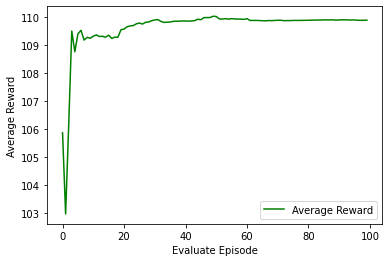

In [205]:

plt.plot(range(0,len(averageReward)), averageReward, color='green', label='Average Reward')

plt.legend() # 显示图例

plt.xlabel('Evaluate Episode')
plt.ylabel('Average Reward')
plt.savefig("RLtrainingReward.jpg")

In [70]:
episode

500

In [71]:
while episode < 1000 :
    
    for i in range(10):
        clusterDic = {}
        performance = {}
        record = {}
        train_reward = run_train_episode(agent, rpm)
        rewardCollected.append(train_reward)
        episode += 1
        logger.info('Episode: {} Reward: {}'.format(episode, train_reward))
        
    clusterDic = {}
    performance = {}
    record = {}
    evaluate_reward = run_evaluate_episode(agent)
    rewardCollected.append(evaluate_reward)
    logger.info('Episode {}, Evaluate reward: {}'.format(episode, evaluate_reward))

close
[04-26 00:08:53 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 501 Reward: 141.60000000015077
close
[04-26 00:14:12 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 502 Reward: 294.50000000009464
close
[04-26 00:19:13 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 503 Reward: 383.6333333334367
close
[04-26 00:24:13 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 504 Reward: 785.5000000001265
close
[04-26 00:29:12 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 505 Reward: 494.63333333344303
close
[04-26 00:34:12 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 506 Reward: 355.30000000009
close
[04-26 00:39:09 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 507 Reward: 357.13333333345435
close
[04-26 00:44:06 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 508 Reward: -200.7999999999643
close
[04-26 00:49:02 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 509 Reward: 202.40000000011344
close
[04-26 00

close
[04-26 05:44:05 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 565 Reward: 362.63333333347293
close
[04-26 05:49:01 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 566 Reward: 14.26666666678777
close
[04-26 05:53:58 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 567 Reward: 1044.233333333484
close
[04-26 05:58:54 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 568 Reward: 243.40000000010826
close
[04-26 06:03:52 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 569 Reward: 564.9666666667865
close
[04-26 06:08:50 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 570 Reward: 605.1666666667902
[04-26 06:11:33 MainThread @<ipython-input-71-687dcf2203cd>:17] Episode 570, Evaluate reward: 1203.100000000164
close
[04-26 06:16:30 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 571 Reward: 947.9333333334683
close
[04-26 06:21:27 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 572 Reward: 417.83333333344154
close
[04-26 

close
[04-26 11:09:17 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 629 Reward: 503.2000000001005
close
[04-26 11:14:04 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 630 Reward: 467.80000000012933
[04-26 11:16:37 MainThread @<ipython-input-71-687dcf2203cd>:17] Episode 630, Evaluate reward: 1209.6000000001652
close
[04-26 11:21:23 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 631 Reward: -163.9999999999477
close
[04-26 11:26:09 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 632 Reward: 594.3666666668014
close
[04-26 11:30:55 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 633 Reward: 119.40000000011413
close
[04-26 11:35:42 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 634 Reward: 681.5333333334823
close
[04-26 11:40:29 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 635 Reward: 454.66666666678816
close
[04-26 11:45:15 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 636 Reward: 315.1000000001218
close
[04-2

close
[04-26 16:30:16 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 692 Reward: 590.6333333334456
close
[04-26 16:35:18 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 693 Reward: 265.50000000011687
close
[04-26 16:40:11 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 694 Reward: 702.5666666667925
close
[04-26 16:45:35 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 695 Reward: 1182.4000000001492
close
[04-26 16:50:46 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 696 Reward: 220.40000000009684
close
[04-26 16:55:55 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 697 Reward: 912.8000000001648
close
[04-26 17:01:02 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 698 Reward: 551.6333333334356
close
[04-26 17:06:07 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 699 Reward: 438.90000000011634
close
[04-26 17:11:13 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 700 Reward: 625.1333333334442
[04-26 17:13:57

close
[04-26 22:07:39 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 755 Reward: 505.80000000011745
close
[04-26 22:12:42 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 756 Reward: 206.16666666678816
close
[04-26 22:17:46 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 757 Reward: 186.43333333342292
close
[04-26 22:22:49 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 758 Reward: 129.56666666679848
close
[04-26 22:27:52 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 759 Reward: 279.60000000009086
close
[04-26 22:32:54 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 760 Reward: 974.3666666667993
[04-26 22:35:37 MainThread @<ipython-input-71-687dcf2203cd>:17] Episode 760, Evaluate reward: 1214.1000000001652
close
[04-26 22:40:38 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 761 Reward: 817.9333333334647
close
[04-26 22:45:42 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 762 Reward: 323.10000000009387
close
[04

close
[04-27 03:47:01 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 819 Reward: 428.5000000000988
close
[04-27 03:52:04 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 820 Reward: 308.100000000123
[04-27 03:54:47 MainThread @<ipython-input-71-687dcf2203cd>:17] Episode 820, Evaluate reward: 1213.6000000001648
close
[04-27 03:59:50 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 821 Reward: -28.43333333322269
close
[04-27 04:04:53 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 822 Reward: 387.2333333334173
close
[04-27 04:09:56 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 823 Reward: 498.2333333334448
close
[04-27 04:14:59 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 824 Reward: 181.33333333343847
close
[04-27 04:20:01 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 825 Reward: 667.6333333334373
close
[04-27 04:25:03 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 826 Reward: 552.1666666667693
close
[04-27 0

close
[04-27 09:24:01 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 882 Reward: 964.6666666668058
close
[04-27 09:29:05 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 883 Reward: -213.19999999989216
close
[04-27 09:34:07 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 884 Reward: 757.3000000001384
close
[04-27 09:39:09 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 885 Reward: 443.4666666667895
close
[04-27 09:44:12 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 886 Reward: 249.0333333334484
close
[04-27 09:49:14 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 887 Reward: 761.8333333334839
close
[04-27 09:54:17 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 888 Reward: 398.93333333345305
close
[04-27 09:59:20 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 889 Reward: 473.10000000011945
close
[04-27 10:04:23 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 890 Reward: 618.7666666667785
[04-27 10:07:05

close
[04-27 15:03:56 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 946 Reward: 350.90000000012043
close
[04-27 15:08:58 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 947 Reward: 160.36666666680844
close
[04-27 15:14:02 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 948 Reward: -78.4333333332393
close
[04-27 15:19:05 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 949 Reward: 272.83333333345985
close
[04-27 15:24:08 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 950 Reward: 92.03333333346241
[04-27 15:26:51 MainThread @<ipython-input-71-687dcf2203cd>:17] Episode 950, Evaluate reward: 1209.6000000001652
close
[04-27 15:31:56 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 951 Reward: 997.3666666668238
close
[04-27 15:37:01 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 952 Reward: 373.0333333334479
close
[04-27 15:42:07 MainThread @<ipython-input-71-687dcf2203cd>:10] Episode: 953 Reward: 232.0666666667915
close
[04-27

In [ ]:
while episode < 1500 :
    
    for i in range(10):
        clusterDic = {}
        performance = {}
        record = {}
        train_reward = run_train_episode(agent, rpm)
        rewardCollected.append(train_reward)
        episode += 1
        logger.info('Episode: {} Reward: {}'.format(episode, train_reward))
        
    clusterDic = {}
    performance = {}
    record = {}
    evaluate_reward = run_evaluate_episode(agent)
    rewardCollected.append(evaluate_reward)
    logger.info('Episode {}, Evaluate reward: {}'.format(episode, evaluate_reward))

In [49]:
 np.clip(np.random.normal([1, 0.9870677 ,1],1), 0, 1.0)

array([0.38713049, 0.49347938, 0.63769732])

In [12]:
episode

0

In [11]:
rewardCollect =[]
clusterDic = {}
performance = {}
record = {}
traci.start(["sumo", "-c", "highway.sumocfg"])
while True:
  

#     newac = []
#     for i in action:
#         newac.append(-i)

    next_obs, reward, done,ob = highway([0.8,0.1,0.1])
    print(reward)
    rewardCollect.append(reward)
      

    if done:
        break
traci.close()

D:\workSpace\Conda\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\workSpace\Conda\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-14.0
-11.0
-8.0
-13.0
-9.0
3.0
-10.0
3.0
-9.0
1.0
3.0
-8.0
-12.0
-14.0
8.0
5.0
11.0
7.0
6.0
5.0
0.0
30.0
14.0
-7.0
-9.0
8.0
-8.0
-13.0
-4.0
12.0
-8.0
-11.0
-11.0
-3.0
-8.0
-1.0
1.0
-3.0
-2.0
7.0
1.0
3.0
-5.0
-2.0
-7.0
-5.0
26.0
-6.0
6.5
15.0
3.0
-11.0
2.0
3.5
-1.0
6.0
-1.0
-13.0
-3.5
2.5
-8.0
-12.0
-13.0
-8.0
-11.0
12.0
-4.0
-1.0
-4.0
-5.0
-16.0
-8.0
-10.0
9.0
-13.0
6.0
6.0
-3.0
-1.0
7.0
-2.0
-0.6666666666666643
-19.0
-4.0
-46.0
-5.0
-13.0
2.0
-7.0
-12.0
-9.0
-14.0
3.0
1.0
-2.0
0.0
-8.0
-3.0
-4.0
5.0
-1.0
-4.5
-6.0
-10.0
-9.0
-3.0
5.0
-0.5
1.0
-8.0
-10.0
-14.0
-5.0
-28.0
-7.0
-11.0
-8.0
-10.0
-8.0
-2.0
-4.0
1.0
-8.0
-4.0
-9.0
-9.0
7.0
-5.0
-6.0
-13.0
-12.0
8.0
4.0
-7.0
-4.0
-7.0
-1.0
-4.0
-12.0
-8.0
1.0
-14.0
-8.0
-9.0
-2.0
-14.0
-1.0
-1.0
-4.0
7.0
-10.0
2.0
1.5
-1.0
-8.0
-11.0
-1.0
-5.0
-8.0
4.5
-6.0
16.0
-5.0
-8.0
13.0
22.5
3.0
-7.0
-4.0
-5.0
-1.0
-4.0
-12.0
41.0
16.0
47.0
13.666666666666664
-2.5
-6.0
-2.0
15.0
13.0
5.0
1.0
-4.0
22.0
-10.0
8.0
-7.0
44.0
-9.5
19.0
13.0
-0.5
-1.0
-10.

-14.0
12.0
-11.0
-10.0
-9.0
8.0
2.0
5.0
0.0
7.0
2.5
17.0
-3.5
25.0
-11.0
6.0
-1.0
-7.0
-9.5
4.0
-3.0
-36.0
-5.0
4.0
-4.0
-6.0
-5.0
3.0
-1.0
-2.5
-9.0
0.0
7.0
-1.0
5.0
3.0
-4.0
-4.5
-24.0
16.0
-3.0
-10.0
3.0
17.0
2.0
-5.0
-1.0
4.0
-5.0
6.0
3.0
-6.0
-13.0
16.0
-9.0
0.0
-7.0
-4.0
-4.0
3.0
58.0
24.0
-5.0
-9.0
45.0
-8.0
30.0
2.0
-10.0
2.0
3.5
-3.5
-4.0
-12.0
0.0
54.0
-9.0
-7.0
11.0
11.0
18.0
-2.0
-18.0
0.0
-5.0
-8.0
-11.0
4.0
-14.0
4.0
-5.0
1.0
-4.0
-4.0
-3.0
-7.0
8.0
-7.0
-1.0
-6.5
-3.0
-5.0
12.0
-2.0
-4.0
-4.0
53.0
-10.0
42.0
7.5
-12.0
9.0
-9.0
11.0
-7.0
-6.0
3.0
-6.0
14.0
-2.0
1.0
13.0
0.0
4.5
20.0
16.5
13.5
5.0
11.0
7.0
-2.0
6.0
2.0
-5.0
5.0
0.0
-1.0
-7.0
0.0
-3.5
-11.0
-9.0
-6.0
7.5
23.5
6.0
2.0
-1.0
1.0
2.0
-8.0
13.0
2.0
9.5
-9.0
-2.0
13.0
-11.0
-11.0
11.0
-6.0
14.0
-2.0
22.0
-6.0
1.5
-5.0
-1.0
-3.0
-7.0
-8.0
-14.0
-8.0
-2.0
6.0
-3.0
0.0
-14.0
-1.5
10.0
-12.0
38.0
-9.0
-42.0
-10.0
-2.5
-10.0
-7.0
12.0
8.0
-2.0
12.0
-14.0
-3.0
0.0
-5.5
-10.0
-5.0
-8.0
11.0
-11.0
7.0
-4.0
1.5
-6.0
2.5
-

11.0
-4.0
9.0
-12.0
-7.0
11.0
-13.0
-3.0
0.0
-10.0
-7.0
4.0
2.0
3.0
5.0
1.0
3.0
2.0
6.0
-11.0
12.0
1.0
7.5
-5.0
-4.0
3.0
-3.0
-3.0
4.0
-5.5
-2.0
-4.0
-2.0
-13.0
6.0
-1.0
55.0
46.0
-23.0
40.0
14.5
17.0
29.0
7.0
32.0
10.0
-1.0
7.0
1.0
-4.0
-2.0
-5.0
-6.0
-5.0
4.0
28.0
-2.0
-7.0
-3.0
2.0
-4.0
8.0
14.0
5.0
13.0
3.0
-5.0
10.0
6.0
-2.0
12.0
-13.0
1.0
-11.0
-10.0
8.0
3.0
-7.5
-4.0
9.5
3.0
-3.0
-4.0
-6.0
2.0
6.0
9.0
4.0
5.5
3.0
2.0
12.0
7.0
7.0
4.0
0.0
2.0
3.0
-3.0
-5.0
-39.0
-4.0
-9.0
-6.0
-4.0
-11.0
-13.0
-12.0
-11.0
5.0
-9.0
-1.0
-4.0
-9.0
3.0
-8.0
3.0
-5.0
-5.0
-5.0
-8.0
-23.0
-0.5
8.0
-3.0
4.0
-10.0
-1.0
11.0
-18.0
41.0
25.0
-2.0
4.0
31.0
-5.0
7.5
10.0
12.0
9.0
-12.0
-10.0
-12.0
49.0
-5.0
18.5
19.0
19.0
11.5
2.0
-4.0
-1.0
5.0
-5.0
-4.0
-6.5
-9.0
8.0
6.0
-7.0
-12.0
-12.0
-13.0
-3.0
-6.0
-12.0
-14.0
-8.0
1.0
-9.0
-11.0
38.0
7.0
39.0
24.0
38.0
14.0
26.0
20.0
7.0
6.0
7.0
13.0
1.0
-2.0
3.0
4.0
-3.0
-3.0
22.0
40.0
-7.0
-10.0
11.0
-7.0
-1.0
-4.0
-10.0
-16.0
-17.0
-9.5
-15.0
-4.0
9.0
-5.0
-19.0
-

1.0
4.0
11.0
1.0
-8.0
3.0
-2.0
2.0
-6.0
-10.0
-2.0
-8.0
-4.0
-9.0
8.0
-6.0
-9.0
-8.0
27.0
11.0
12.0
3.0
2.0
-19.0
-6.0
-9.0
-17.0
0.0
12.0
-12.0
-4.5
-1.0
4.0
-2.0
-3.0
-14.0
-4.0
-9.0
-14.0
-3.0
4.0
21.0
5.0
6.0
-4.0
12.0
-5.0
4.0
-5.0
7.333333333333336
1.0
13.0
-11.0
-16.0
8.0
-7.0
-12.0
-8.0
6.0
-9.0
-10.0
12.0
0.0
-5.0
-11.5
10.0
-1.0
3.0
-3.0
26.5
23.0
4.0
-1.5
1.5
0.0
-1.0
14.0
-5.0
6.0
-6.0
-5.5
0.0
-5.0
-27.0
-11.0
-4.0
11.0
-2.0
13.0
16.0
-2.5
-9.0
-4.0
24.0
10.0
-8.0
-9.0
2.0
-2.0
6.0
-14.0
12.0
8.0
61.0
-3.0
3.0
-6.0
-10.0
-9.5
-11.0
-8.5
-9.0
5.0
-5.0
-7.0
46.0
9.0
39.0
0.0
2.0
-7.0
6.0
-9.0
12.0
-11.5


In [13]:
np.sum(rewardCollect)

178.99999999999977

In [27]:
np.mean(rewardCollect)

-5.965276430649855

In [21]:
traci.close()

In [65]:
# while episode < 1000:
    
#     for i in range(10):
#         clusterDic = {}
#         performance = {}
#         record = {}
#         train_reward = run_train_episode(agent, rpm)
#         rewardCollected.append(train_reward)
#         episode += 1
#         logger.info('Episode: {} Reward: {}'.format(episode, train_reward))
        
#     clusterDic = {}
#     performance = {}
#     record = {}
#     evaluate_reward = run_evaluate_episode(agent)
#     rewardCollected.append(evaluate_reward)
#     logger.info('Episode {}, Evaluate reward: {}'.format(episode, evaluate_reward))
traci.close()

ConnectionAbortedError: [WinError 10053] 你的主机中的软件中止了一个已建立的连接。

In [40]:
rewardCollected

[-3578.833333333333,
 -1547.0,
 -93.5,
 776.9999999999999,
 619.0000000000001,
 612.1666666666663,
 28.66666666666654,
 506.0,
 328.50000000000006,
 255.4999999999998,
 1733.0,
 682.9999999999999,
 368.6666666666666,
 343.6666666666667,
 631.5000000000002,
 18.166666666666433,
 582.8333333333335,
 125.83333333333336,
 516.1666666666665,
 337.49999999999994,
 187.3333333333334,
 1817.8333333333337,
 -91.16666666666652,
 247.8333333333338,
 800.8333333333333,
 220.0000000000001,
 361.6666666666665,
 287.6666666666664,
 442.1666666666668,
 99.99999999999996,
 683.6666666666666,
 -61.4999999999997,
 1528.8333333333337,
 225.3333333333335,
 311.33333333333337,
 112.00000000000017,
 379.0,
 34.66666666666674,
 117.1666666666667,
 196.50000000000023,
 -57.4999999999998,
 247.83333333333334,
 164.33333333333334,
 1573.833333333334,
 392.16666666666674,
 -87.66666666666667,
 144.66666666666637,
 290.1666666666667,
 7.833333333333183,
 278.83333333333337,
 643.3333333333333,
 461.66666666666686,

In [48]:
rewardCollected1 = list(reversed(rewardCollected[5:]))

In [49]:
rewardCollected1

[-638.6666666666662,
 -700.1666666666667,
 -1109.1666666666665,
 -636.1666666666669,
 97.33333333333294,
 -1037.5000000000007,
 -984.0,
 -1082.5,
 -1121.0000000000007,
 -1012.1666666666661,
 -867.0000000000005,
 -566.6666666666669,
 -957.3333333333333,
 -1314.1666666666656,
 -1439.4999999999995,
 -236.83333333333337,
 -1557.6666666666665,
 -1255.3333333333335,
 -796.8333333333333,
 -1076.1666666666667,
 -1574.5000000000002,
 -1166.5000000000007,
 -1476.0000000000005,
 -1124.3333333333328,
 -649.3333333333333,
 -662.8333333333331,
 164.49999999999972,
 -1129.1666666666665,
 -688.3333333333333,
 -1198.3333333333337,
 -1043.4999999999998,
 -845.1666666666675,
 -899.3333333333336,
 -806.9999999999997,
 -633.9999999999997,
 -914.5000000000001,
 -866.333333333333,
 -77.33333333333343,
 -1288.8333333333337,
 -757.8333333333335,
 -1075.1666666666672,
 -961.1666666666665,
 -727.3333333333334,
 -1453.4999999999998,
 -1013.9999999999991,
 -778.833333333333,
 -1158.9999999999995,
 -984.99999999999

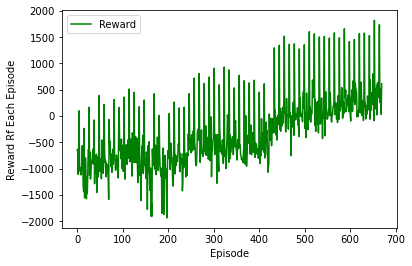

In [54]:

plt.plot(range(0,len(rewardCollected1)), rewardCollected1, color='green', label='Reward')

plt.legend() # 显示图例

plt.xlabel('Episode')
plt.ylabel('Reward Rf Each Episode')
plt.savefig("rewardCollectedFinal.jpg")

In [55]:
step = 1
total = 0
averageReward = []
for x in rewardCollected1:
    total += x
    
    averageReward.append(total / step)
    step+=1

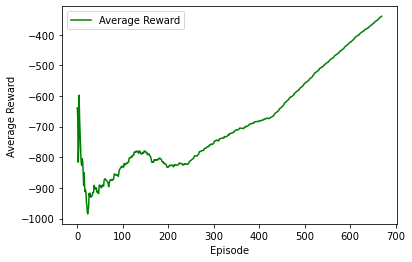

In [72]:

plt.plot(range(0,len(averageReward)), averageReward, color='green', label='Average Reward')

plt.legend() # 显示图例

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.savefig("AveragerewardCollectedFinal.jpg")

In [ ]:
run_evaluate_episode(agent)

In [271]:
clusterDic = {}
performance = {}
record = {}
ClusterLifeFinalModel = []
traci.start(["sumo", "-c", "highway.sumocfg"])
obs,reward, done,ob = highway([0.8,0.1,0.1])
total_reward = 0
ClusterLife = []

SpeedLife = {}
AccLife = {}


while True:
    batch_obs = np.expand_dims(obs, axis=0)
    action = agent.predict(batch_obs.astype('float32'))

#     newac = []
#     for i in action:
#         newac.append(-i)
#     action = np.clip(np.random.normal(action, 1.0), 0, 1.0)
#     next_obs, reward, done,ob = highway(action)
    next_obs, reward, done,ob =  highway([0.8,-2,0.1])
    speed = round(ob[0], 1)
    acc = round(ob[1],1)
    if speed in SpeedLife:
        SpeedLife[speed].append((reward + 48.8)/2)
    else:
        SpeedLife[speed] = [(reward + 48.8)/2]
    print(SpeedLife[speed])
    
   
   
    if acc in AccLife:
        AccLife[acc].append((reward + 48.8))
    else:
        AccLife[acc] = [reward + 48.8]
   
        
    
    
    ClusterLifeFinalModel.append((reward + 48.8)/2)
    obs = next_obs
    total_reward += reward

    if done:
        break
traci.close()
  
print(total_reward)

[17.5]
[20.5]
[18.0]
[20.0]
[24.5]
[18.5]
[20.0]
[18.5]
[18.5, 25.0]
[26.0]
[24.5, 20.5]
[21.5]
[8.0]
[17.5, 29.0]
[24.0]
[20.0, 30.0]
[28.5]
[26.0, 17.25]
[30.25]
[20.0]
[37.75]
[37.75, 2.0]
[28.5]
[19.0]
[1.5]
[13.0]
[21.0]
[37.75, 2.0, 18.0]
[18.5, 25.0, 24.5]
[20.5]
[19.0]
[20.0, 30.0, 19.5]
[23.0]
[18.0]
[26.0, 17.25, 30.0]
[24.0, 25.0]
[21.5, 24.5]
[23.5]
[26.0, 17.25, 30.0, 21.0]
[26.0]
[26.0, 22.0]
[20.5, 26.0]
[23.5]
[24.0]
[24.0, 19.5]
[20.0, 30.0, 19.5, 22.0]
[39.0]
[36.5]
[27.75]
[39.0, 32.0]
[29.0]
[20.0]
[22.5]
[23.5, 28.0]
[23.5]
[23.5, 28.0, 25.5]
[20.0]
[13.0, 30.5]
[17.5]
[18.0]
[29.0, 18.5]
[20.5]
[18.0, 7.0]
[29.0]
[15.0]
[24.0]
[24.5, 20.5, 14.5]
[30.25, 24.0]
[13.0, 30.5, 22.0]
[29.0, 18.5, 15.0]
[20.5]
[23.0, 22.0]
[27.75, 21.5]
[23.5, 28.0, 25.5, 19.5]
[26.0, 22.0, 21.0]
[22.5, 9.0]
[29.0, 18.5, 15.0, 24.5]
[20.0, 23.0]
[26.0, 22.0, 21.0, 24.5]
[18.5, 25.0, 24.5, 30.0]
[24.666666666666668]
[22.5, 9.0, 23.25]
[20.5, 19.0]
[20.5, 26.0, 17.0]
[20.0, 28.5]
[24.0, 19

[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5]
[20.0, 20.5, 31.0, 47.0, 22.0, 22.0, 16.5, 30.0, 24.75, 6.0]
[18.5, 25.0, 24.5, 30.0, 23.5, 20.0, 20.0, 17.5, 7.5]
[15.0, 21.5, 19.0, 21.0, 26.75, 32.0, 24.0, 4.5]
[24.666666666666668, 15.0, 25.0, 4.5, 23.0, 24.5]
[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5]
[24.666666666666668, 15.0, 25.0, 4.5, 23.0, 24.5, 32.0]
[29.0, 18.5, 15.0, 24.5, 23.5, 18.5, 27.0, 29.5, 25.5, 12.5]
[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5]
[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0]
[26.0, 7.5, 33.0, 28.5, 29.5]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5]
[46.5, 27.5]
[36.5, 32.5, 30.5, 31.0, 25.5, 26.0, 25.0]
[19.0, 33.0, 7.0, 22.5, 22.0]
[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5]
[20.0, 30.0, 19.5, 22.0, 36.75, 23.0, 24.0, 30.0, 23.5, 23.5, 32.0, 31.5, 15.5, 21.5, 24.0, 20.0, 9.5, 28.5]
[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 16.0, 15.0, 

[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5]
[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75, 30.5, 27.5, 19.5, 29.0, 26.0, 19.0, 4.0]
[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5]
[20.0, 20.5, 31.0, 47.0, 22.0, 22.0, 16.5, 30.0, 24.75, 6.0, 29.5, 23.0]
[23.5, 22.5, 20.0, 28.0, 23.0, 25.0, 24.0, 22.5, 32.0, 22.0]
[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0]
[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0]
[22.5, 9.0, 23.25, 25.0, 15.5, 21.0, 22.0, 20.0, 16.5, 47.5, 24.0, 13.0, 30.5, 24.0, 26.5]
[15.0, 21.5, 19.0, 21.0, 26.75, 32.0, 24.0, 4.5, 19.5, 18.5]
[15.0, 21.5, 19.0, 21.0, 26.75, 32.0, 24.0, 4.5, 19.5, 18.5, 24.5]
[22.5, 9.0, 23.25, 25.0, 15.5, 21.0, 22.0, 20.0, 16.5, 47.5, 24.0, 13.0, 30.5, 24.0, 26.5, 15.0]
[23.5, 22.5, 20.0, 28.0, 23.0, 25.0, 24.0, 22.5, 32.0

[19.5, 30.0, 18.0, 26.5, 30.5, 21.5, 20.0, 22.5, 29.5, 22.5, 24.5]
[36.5, 32.5, 30.5, 31.0, 25.5, 26.0, 25.0, 35.5, 20.5, 20.5, 13.5, 23.0, 21.5, 16.0]
[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25]
[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0]
[1.5, 31.5, 24.5, 16.5, 22.0]
[20.5, 19.0, 22.5, 27.0, 18.5, 19.0, 22.0, 21.0, 22.0, 30.5]
[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75, 30.5, 27.5, 19.5, 29.0, 26.0, 19.0, 4.0, 24.0, 30.0, 21.5, 20.75]
[20.0, 20.5, 31.0, 47.0, 22.0, 22.0, 16.5, 30.0, 24.75, 6.0, 29.5, 23.0, 31.5, 31.0, 22.5, 26.0]
[39.0, 32.0, 21.0, 20.0, 24.5, 29.5, 30.0, 26.0, 14.333333333333334, 29.0, 28.25, 23.0, 25.5]
[30.25, 24.0, 25.0, 19.75, 26.166666666666668, 31.5, 23.5, 17.0, 24.5, 21.5, 31.0]
[22.5, 9.0, 23.25, 25.0, 15.5, 21.0, 22.0, 20.0, 16.5, 47.5, 24.0, 13.0, 30.5, 24.0, 26.5, 15.0, 21.5, 25.5, 27.0, 19.0]
[30.2

[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5]
[36.5, 32.5, 30.5, 31.0, 25.5, 26.0, 25.0, 35.5, 20.5, 20.5, 13.5, 23.0, 21.5, 16.0, 19.0, 17.5, 27.5]
[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0]
[15.0, 21.5, 19.0, 21.0, 26.75, 32.0, 24.0, 4.5, 19.5, 18.5, 24.5, 14.0, 20.5, 27.0, 30.0, 15.75, 25.5]
[20.0, 20.5, 31.0, 47.0, 22.0, 22.0, 16.5, 30.0, 24.75, 6.0, 29.5, 23.0, 31.5, 31.0, 22.5, 26.0, 29.5, 24.25]
[18.5, 25.0, 24.5, 30.0, 23.5, 20.0, 20.0, 17.5, 7.5, 25.0, 23.25, 30.0, 23.0, 21.5, 23.0, 22.5, 11.5, 20.0, 26.5, 27.0]
[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25]
[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0, 27.5, 24.5, 37.5, 33.0, 20.5, 29.5, 23.5]
[19.0, 33.0, 7.0, 22.5, 22.0, 31.0, 28.5, 23.0, 22.5, 18.0]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5]
[30.0, 31.5, 21.5, 29.0, 17.0]
[8.0, 17.25, 19.5,

[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0]
[19.0, 33.0, 7.0, 22.5, 22.0, 31.0, 28.5, 23.0, 22.5, 18.0, 23.0]
[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75, 30.5, 27.5, 19.5, 29.0, 26.0, 19.0, 4.0, 24.0, 30.0, 21.5, 20.75, 26.0, 24.5]
[18.0, 20.5, 11.5, 41.0, 30.0]
[19.0, 33.0, 7.0, 22.5, 22.0, 31.0, 28.5, 23.0, 22.5, 18.0, 23.0, 21.0]
[24.5, 23.5, 27.5, 22.0, 3.5, 26.5, 27.0, 22.0, 17.0, 21.5, 22.75, 20.5, 20.5, 27.0, 22.0, 22.0, 23.0, 22.5, 25.0]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0]
[28.0, 28.5, 23.0, 20.5]
[28.0, 28.5, 23.0, 20.5, 20.5]
[24.5, 23.5, 27.5, 22.0, 3.5, 26.5, 27.0, 22.0, 17.0, 21.5, 22.75, 20.5, 20.5, 27.0, 22.0, 22.0, 23.0, 22.5, 25.0, 23.5]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0]
[30.0, 31.5, 21.5, 29.0, 17.0, 29.0]
[24.5, 23.5, 27.5, 22.0, 3.5, 26.5, 27.0, 22.0, 17.0, 21.5, 22.75, 20.5, 20.5, 27.0, 2

[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0]
[20.5, 26.0, 17.0, 23.0, 30.5, 19.0, 23.0, 23.5, 20.25, 25.0, 20.0, 19.5, 22.0, 25.0, 24.0, 13.0, 19.0, 23.5, 23.5, 25.0, 23.0, 29.0, 29.0, 20.5, 23.5, 17.5, 24.0, 20.0, 22.5, 20.0, 18.0, 21.5]
[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0, 27.5, 24.5, 37.5, 33.0, 20.5, 29.5, 23.5, 20.5, 21.5, 23.0, 22.0, 24.5]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75]
[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0, 21.25, 19.5, 19.5, 30.0, 16.0, 26.5]
[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25]
[20.5, 26.0, 1

[26.0, 7.5, 33.0, 28.5, 29.5, 25.5, 19.0, 29.5, 31.5, 22.0, 17.0, 24.75, 12.0, 40.5, 20.0, 22.0, 20.5, 24.5, 20.5, 23.5, 25.5, 6.5, 21.0, 17.0, 8.0, 23.0]
[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5]
[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5]
[30.25, 24.0, 25.0, 19.75, 26.166666666666668, 31.5, 23.5, 17.0, 24.5, 21.5, 31.0, 25.75, 17.0, 26.5, 19.5, 26.25, 17.5, 24.0]
[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25, 30.5, 32.0, 30.0, 30.0, 22.0, 24.5, 24.0, 26.5, 19.0, 20.0, 23.0, 16.5, 24.0]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75]
[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.

[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5]
[20.5, 26.0, 17.0, 23.0, 30.5, 19.0, 23.0, 23.5, 20.25, 25.0, 20.0, 19.5, 22.0, 25.0, 24.0, 13.0, 19.0, 23.5, 23.5, 25.0, 23.0, 29.0, 29.0, 20.5, 23.5, 17.5, 24.0, 20.0, 22.5, 20.0, 18.0, 21.5, 23.5, 17.5, 23.5, 24.5, 19.0, 51.5, 32.0]
[20.0, 30.0, 19.5, 22.0, 36.75, 23.0, 24.0, 30.0, 23.5, 23.5, 32.0, 31.5, 15.5, 21.5, 24.0, 20.0, 9.5, 28.5, 26.5, 25.5, 35.5, 23.5, 21.0, 21.5, 41.0, 22.0, 25.5, 28.0, 25.5, 16.0, 23.0, 29.5]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5]
[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0]
[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25

[24.666666666666668, 15.0, 25.0, 4.5, 23.0, 24.5, 32.0, 23.5, 20.75, 30.5, 23.5, 21.0, 26.5, 10.0, 23.5]
[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5]
[23.0, 21.5, 21.0, 26.0, 29.5, 21.0, 25.5, 26.0, 21.5]
[1.5, 31.5, 24.5, 16.5, 22.0, 20.5]
[19.5, 20.0, 17.5]
[21.0, 20.5, 32.0, 18.5, 21.5, 23.0, 37.0, 24.5]
[23.0, 21.5, 21.0, 26.0, 29.5, 21.0, 25.5, 26.0, 21.5, 27.5]
[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25, 30.5, 32.0, 30.0, 30.0, 22.0, 24.5, 24.0, 26.5, 19.0, 20.0, 23.0, 16.5, 24.0, 40.5, 20.0, 26.0, 22.5, 3.0]
[20.5, 26.0, 17.0, 23.0, 30.5, 19.0, 23.0, 23.5, 20.25, 25.0, 20.0, 19.5, 22.0, 25.0, 24.0, 13.0, 19.0, 23.5, 23.5, 25.0, 23.0, 29.0, 29.0, 20.5, 23.5, 17.5, 24.0, 20.0, 22.5, 20.0, 18.0, 21.5, 23.5, 17.5, 23.5, 24.5, 19.0, 51.5, 32.0, 21.5, 18.0]
[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 2

[29.0, 18.5, 15.0, 24.5, 23.5, 18.5, 27.0, 29.5, 25.5, 12.5, 24.0, 26.5, 30.0, 24.5, 23.5, 10.0, 28.5, 27.0, 18.0, 33.75, 21.0, 18.0]
[18.0, 7.0, 23.5, 19.0, 19.5, 24.5, 19.0, 25.0, 18.0, 37.5, 24.0]
[20.0, 20.5, 31.0, 47.0, 22.0, 22.0, 16.5, 30.0, 24.75, 6.0, 29.5, 23.0, 31.5, 31.0, 22.5, 26.0, 29.5, 24.25, 33.5, 27.0, 18.0, 21.25, 22.5, 20.0, 24.0]
[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.5]
[20.0, 20.5, 31.0, 47.0, 22.0, 22.0, 16.5, 30.0, 24.75, 6.0, 29.5, 23.0, 31.5, 31.0, 22.5, 26.0, 29.5, 24.25, 33.5, 27.0, 18.0, 21.25, 22.5, 20.0, 24.0, 23.5]
[23.0, 21.5, 21.0, 26.0, 29.5, 21.0, 25.5, 26.0, 21.5, 27.5, 19.5]
[21.0, 20.5, 32.0, 18.5, 21.5, 23.0, 37.0, 24.5, 21.0]
[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25, 30.5, 32.0, 30.0, 30.0, 22.0, 24.5, 24.0, 26.5, 19.0, 20.0, 23.0, 16.5, 24.0, 40.5, 20.0, 

[36.5, 32.5, 30.5, 31.0, 25.5, 26.0, 25.0, 35.5, 20.5, 20.5, 13.5, 23.0, 21.5, 16.0, 19.0, 17.5, 27.5, 26.0, 37.0, 22.5, 26.0, 23.5, 27.0, 22.0, 19.0, 20.0, 21.5, 22.5, 22.0, 30.5, 26.0, 20.5, 21.5]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5]
[30.0, 31.5, 21.5, 29.0, 17.0, 29.0, 23.5, 24.5, 19.5]
[19.5, 19.0, 22.0, 25.0, 26.0, 24.5]
[19.0, 33.0, 7.0, 22.5, 22.0, 31.0, 28.5, 23.0, 22.5, 18.0, 23.0, 21.0, 26.5, 25.0, 12.25, 24.0, 30.0, 27.5, 23.0, 26.0]
[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5]
[36.5, 32.5, 30.5, 31.0, 25.5, 26.0, 25.0, 35.5, 20.5, 20.5, 13.5, 23.0, 

[18.5, 25.0, 24.5, 30.0, 23.5, 20.0, 20.0, 17.5, 7.5, 25.0, 23.25, 30.0, 23.0, 21.5, 23.0, 22.5, 11.5, 20.0, 26.5, 27.0, 23.0, 25.0, 12.5, 22.0, 24.5, 32.5, 24.0, 22.0, 24.5, 24.75, 23.5, 21.5, 20.0, 29.5]
[19.5, 30.0, 18.0, 26.5, 30.5, 21.5, 20.0, 22.5, 29.5, 22.5, 24.5, 23.0, 33.5, 24.0, 22.5, 32.0, 21.5, 29.0, 26.75, 25.0]
[21.0, 20.5, 32.0, 18.5, 21.5, 23.0, 37.0, 24.5, 21.0, 25.5]
[24.666666666666668, 15.0, 25.0, 4.5, 23.0, 24.5, 32.0, 23.5, 20.75, 30.5, 23.5, 21.0, 26.5, 10.0, 23.5, 9.5]
[29.0, 25.5, 23.0, 25.0, 25.5, 19.5, 33.5, 22.5, 16.5, 16.5, 22.0, 24.0]
[29.0, 25.5, 23.0, 25.0, 25.5, 19.5, 33.5, 22.5, 16.5, 16.5, 22.0, 24.0, 21.0]
[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.5, 20.5, 20.0, 24.0]
[39.0, 32.0, 21.0, 20.0, 24.5, 29.5, 30.0, 26.0, 14.333333333333334, 29.0, 28.25, 23.0, 25.5, 19.0, 22.5, 14.0, 23.75, 22.5, 19.5, 18.0, 30.0, 

[18.5, 25.0, 24.5, 30.0, 23.5, 20.0, 20.0, 17.5, 7.5, 25.0, 23.25, 30.0, 23.0, 21.5, 23.0, 22.5, 11.5, 20.0, 26.5, 27.0, 23.0, 25.0, 12.5, 22.0, 24.5, 32.5, 24.0, 22.0, 24.5, 24.75, 23.5, 21.5, 20.0, 29.5, 19.0]
[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0]
[20.0, 30.0, 19.5, 22.0, 36.75, 23.0, 24.0, 30.0, 23.5, 23.5, 32.0, 31.5, 15.5, 21.5, 24.0, 20.0, 9.5, 28.5, 26.5, 25.5, 35.5, 23.5, 21.0, 21.5, 41.0, 22.0, 25.5, 28.0, 25.5, 16.0, 23.0, 29.5, 22.5, 17.0, 17.0, 28.0, 38.0, 24.75, 34.0, 24.5, 31.0]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 2

[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0, 18.0, 23.75, 23.5]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25, 36.25, 22.5, 16.25]
[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0, 23.0, 16.5, 22.0, 15.5, 21.5]
[28.5, 22.5, 22.0, 19.0, 30.5, 24.5, 26.5, 30.0, 21.25, 25.5, 16.5, 20.0, 20.0, 25.0, 21.5, 20.0, 25.0, 23.0, 21.0, 17.5, 21.5, 13.5, 25.0]
[17.5, 29.0, 45.0, 21.0, 14.75]
[33.5, 19.5]
[42.5, 26.25, 22.5]
[16.5]
[29.5]
[16.5, 41.0]
[35.0]
[28.0]
[30.5]
[28.0, 28.0]
[16.5, 41.0, 22.5]
[20.5, 22.5, 18.0, 24.5, 27.0, 21.5, 30.0, 30.0]
[24.0, 25.0, 23.75, 2

[18.5, 25.0, 24.5, 30.0, 23.5, 20.0, 20.0, 17.5, 7.5, 25.0, 23.25, 30.0, 23.0, 21.5, 23.0, 22.5, 11.5, 20.0, 26.5, 27.0, 23.0, 25.0, 12.5, 22.0, 24.5, 32.5, 24.0, 22.0, 24.5, 24.75, 23.5, 21.5, 20.0, 29.5, 19.0, 16.0, 21.0]
[29.0, 18.5, 15.0, 24.5, 23.5, 18.5, 27.0, 29.5, 25.5, 12.5, 24.0, 26.5, 30.0, 24.5, 23.5, 10.0, 28.5, 27.0, 18.0, 33.75, 21.0, 18.0, 20.5, 25.5, 30.5, 29.5]
[18.5, 25.0, 24.5, 30.0, 23.5, 20.0, 20.0, 17.5, 7.5, 25.0, 23.25, 30.0, 23.0, 21.5, 23.0, 22.5, 11.5, 20.0, 26.5, 27.0, 23.0, 25.0, 12.5, 22.0, 24.5, 32.5, 24.0, 22.0, 24.5, 24.75, 23.5, 21.5, 20.0, 29.5, 19.0, 16.0, 21.0, 24.0]
[30.25, 24.0, 25.0, 19.75, 26.166666666666668, 31.5, 23.5, 17.0, 24.5, 21.5, 31.0, 25.75, 17.0, 26.5, 19.5, 26.25, 17.5, 24.0, 24.0, 17.5, 24.5, 33.0, 20.25, 21.5, 19.0, 21.75, 22.5]
[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25, 30.5, 32.0, 30.0, 30.0, 22.0, 24.5, 24.0, 26.5, 19.0, 20.0, 23.0, 16.5, 24.0, 40.5, 20.0, 26.0, 22.5, 3.0, 31.0, 22.5

[39.0, 32.0, 21.0, 20.0, 24.5, 29.5, 30.0, 26.0, 14.333333333333334, 29.0, 28.25, 23.0, 25.5, 19.0, 22.5, 14.0, 23.75, 22.5, 19.5, 18.0, 30.0, 34.0, 21.5, 30.5, 25.0, 17.0, 24.5, 17.5, 27.5, 18.5, 29.5, 26.0, 16.0, 20.5, 17.5, 22.0, 20.0, 20.0]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25, 36.25, 22.5, 16.25, 21.0, 22.5, 29.0]
[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 16.0, 15.0, 19.5, 14.5, 22.0, 20.0, 21.0, 22.5, 25.0, 20.0, 20.0, 17.5, 21.0, 25.0, 24.0, 19.5, 21.5, 24.5, 26.0, 17.5, 26.0, 26.0, 23.5, 31.0, 23.5, 21.0, 19.0, 20.5, 24.5, 23.0, 28.0, 25.5, 20.0, 22.25, 31.5, 24.5, 24.0, 30.5, 30.0, 23.5, 22.5, 23.0]
[39.0, 32.0, 21.0, 20.0, 24.5, 29.5, 30.0, 26.0, 14.333333333333334, 29.0, 28.25, 23.0, 25.5, 19.0, 22.5, 14.0, 23.75, 22.5, 19.5, 18.0, 30.0, 34.0, 21.5, 30.5, 25.0, 17.0, 24.5, 17.5, 27.5, 18.5, 29.5, 26.0

[8.0, 17.25, 19.5, 20.0, 14.5, 29.0, 30.0, 30.5, 24.5, 25.0, 24.5, 30.5, 28.0, 9.0, 18.0]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25, 36.25, 22.5, 16.25, 21.0, 22.5, 29.0, 25.5, 19.5, 20.0, 36.5, 20.5, 22.0]
[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5, 31.75, 23.0, 4.5, 9.5, 24.5, 21.5, 30.5, 12.25, 23.5, 20.25, 26.0, 24.0, 21.5]
[24.5, 23.5, 27.5, 22.0, 3.5, 26.5, 27.0, 22.0, 17.0, 21.5, 22.75, 20.5, 20.5, 27.0, 22.0, 22.0, 23.0, 22.5, 25.0, 23.5, 23.5, 53.0, 24.0, 40.0, 25.5, 39.0, 23.0, 23.0, 19.166666666666668, 21.5, 24.0, 24.5, 28.0, 31.5, 36.25, 36.0, 20.5, 31.5, 30.5, 34.5, 25.0, 24.5]
[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 

[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0, 18.0, 23.75, 23.5, 26.5, 19.0, 38.0, 26.0]
[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.5, 20.5, 20.0, 24.0, 23.0, 26.5, 10.5, 33.5, 29.0]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5]
[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5, 31.75, 23.0, 4.5, 9.5, 24.5, 21.5, 30.5, 12.25, 23.5, 20.25, 26.0, 24.0, 21.5, 30.5, 28.0]
[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.

[22.5, 9.0, 23.25, 25.0, 15.5, 21.0, 22.0, 20.0, 16.5, 47.5, 24.0, 13.0, 30.5, 24.0, 26.5, 15.0, 21.5, 25.5, 27.0, 19.0, 25.0, 29.0, 30.0, 26.25, 29.5, 19.5, 25.0, 22.0, 26.5, 23.5, 24.5, 23.5, 24.0, 29.5, 36.0, 33.0, 22.5, 27.5, 30.5, 31.25, 25.75]
[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5]
[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25, 30.5, 32.0, 30.0, 30.0, 22.0, 24.5, 24.0, 26.5, 19.0, 20.0, 23.0, 16.5, 24.0, 40.5, 20.0, 26.0, 22.5, 3.0, 31.0, 22.5, 21.5, 16.5, 21.5, 16.5, 15.0, 27.25, 27.5]
[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25, 30.5, 32.0, 30.0, 30.0, 22.0, 24.5, 24.0, 26.5, 19.0, 20.0, 23.0, 16.5, 24.0, 40.5, 20.0, 26.0,

[20.5, 19.0, 22.5, 27.0, 18.5, 19.0, 22.0, 21.0, 22.0, 30.5, 29.5, 24.0, 17.5, 26.0, 25.0, 24.5, 16.0, 21.0, 21.0, 23.0, 18.0, 30.5]
[23.0, 21.5, 21.0, 26.0, 29.5, 21.0, 25.5, 26.0, 21.5, 27.5, 19.5, 21.5, 22.0, 23.0, 25.0]
[23.5, 22.5, 20.0, 28.0, 23.0, 25.0, 24.0, 22.5, 32.0, 22.0, 31.0, 20.75, 18.5, 25.0, 17.25, 21.5, 22.5, 33.0, 24.0, 24.75, 29.5, 20.0, 19.5, 15.5, 34.5, 24.5]
[23.0, 21.5, 21.0, 26.0, 29.5, 21.0, 25.5, 26.0, 21.5, 27.5, 19.5, 21.5, 22.0, 23.0, 25.0, 24.5]
[21.0, 20.5, 32.0, 18.5, 21.5, 23.0, 37.0, 24.5, 21.0, 25.5, 24.75, 21.5, 22.75]
[24.666666666666668, 15.0, 25.0, 4.5, 23.0, 24.5, 32.0, 23.5, 20.75, 30.5, 23.5, 21.0, 26.5, 10.0, 23.5, 9.5, 25.0, 29.0, 22.0, 16.5, 20.5, 22.5]
[19.5, 30.0, 18.0, 26.5, 30.5, 21.5, 20.0, 22.5, 29.5, 22.5, 24.5, 23.0, 33.5, 24.0, 22.5, 32.0, 21.5, 29.0, 26.75, 25.0, 23.0, 17.5, 25.5, 19.0]
[19.5, 30.0, 18.0, 26.5, 30.5, 21.5, 20.0, 22.5, 29.5, 22.5, 24.5, 23.0, 33.5, 24.0, 22.5, 32.0, 21.5, 29.0, 26.75, 25.0, 23.0, 17.5, 25.5, 19.0, 

[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75]
[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0, 18.0, 23.75, 23.5, 26.5, 19.0, 38.0, 26.0, 23.0, 20.5, 30.0, 24.5, 22.5]
[24.5, 23.5, 27.5, 22.0, 3.5, 26.5, 27.0, 22.0, 17.0, 21.5, 22.75, 20.5, 20.5, 27.0, 22.0, 22.0, 23.0, 22.5, 25.0, 23.5, 23.5, 53.0, 24.0, 40.0, 25.5, 39.0, 23.0, 23.0, 19.166666666666668, 21.5, 24.0, 24.5, 28.0, 31.5, 36.25, 36.0, 20.5, 31.5, 30.5, 34.5, 25.0, 24.5, 21.5, 23.0, 20.0, 31.5, 14.5, 24.75]
[42.5, 26

[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5, 31.75, 23.0, 4.5, 9.5, 24.5, 21.5, 30.5, 12.25, 23.5, 20.25, 26.0, 24.0, 21.5, 30.5, 28.0, 26.5, 22.5, 21.0, 39.0, 27.5, 29.5, 21.5, 19.0]
[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.5, 20.5, 20.0, 24.0, 23.0, 26.5, 10.5, 33.5, 29.0, 29.25, 25.5, 22.5, 22.5, 31.0, 20.0]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5, 19.5, 20.0, 20.0, 20.5]
[20.0, 20.5, 31.0, 47.0, 22.0, 22.0, 16.5, 30.0, 24.75, 6.0, 29.5, 23.0, 31.5, 31

[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5, 19.5, 20.0, 20.0, 20.5, 18.5, 22.5, 17.5]
[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0, 18.0, 23.75, 23.5, 26.5, 19.0, 38.0, 26.0, 23.0, 20.5, 30.0, 24.5, 22.5, 22.5, 26.5]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 

[19.0, 33.0, 7.0, 22.5, 22.0, 31.0, 28.5, 23.0, 22.5, 18.0, 23.0, 21.0, 26.5, 25.0, 12.25, 24.0, 30.0, 27.5, 23.0, 26.0, 30.5, 17.5, 31.5, 19.5, 23.5, 23.5, 24.0]
[8.0, 17.25, 19.5, 20.0, 14.5, 29.0, 30.0, 30.5, 24.5, 25.0, 24.5, 30.5, 28.0, 9.0, 18.0, 31.5, 23.0, 29.5]
[28.5, 22.5, 22.0, 19.0, 30.5, 24.5, 26.5, 30.0, 21.25, 25.5, 16.5, 20.0, 20.0, 25.0, 21.5, 20.0, 25.0, 23.0, 21.0, 17.5, 21.5, 13.5, 25.0, 35.5, 16.5, 24.0, 20.5, 28.0, 22.5, 27.0, 31.5]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5]
[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0, 23.0, 16.5, 22.0, 15.5, 21.5, 20.25, 21.0, 21.75, 24.0, 24.0, 28.5, 24.5, 22.5, 19.5]
[18.0, 20.5, 11.5, 41.0, 30.0, 24.0, 22.5, 28.0, 17.0, 10.0, 19.5, 16.0]
[46.5, 27.5, 18.5, 20.5, 32.0, 22.5, 21.0, 20.0, 2.5, 18.0, 21.5, 21.0, 20.25, 20.25, 21.0, 26.75]
[20.5, 22.5, 18.0, 24.5, 

[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 16.0, 15.0, 19.5, 14.5, 22.0, 20.0, 21.0, 22.5, 25.0, 20.0, 20.0, 17.5, 21.0, 25.0, 24.0, 19.5, 21.5, 24.5, 26.0, 17.5, 26.0, 26.0, 23.5, 31.0, 23.5, 21.0, 19.0, 20.5, 24.5, 23.0, 28.0, 25.5, 20.0, 22.25, 31.5, 24.5, 24.0, 30.5, 30.0, 23.5, 22.5, 23.0, 25.0, 31.0, 25.0, 30.5, 22.0, 30.0]
[29.0, 18.5, 15.0, 24.5, 23.5, 18.5, 27.0, 29.5, 25.5, 12.5, 24.0, 26.5, 30.0, 24.5, 23.5, 10.0, 28.5, 27.0, 18.0, 33.75, 21.0, 18.0, 20.5, 25.5, 30.5, 29.5, 37.0, 19.0, 25.0]
[21.5, 22.0, 17.5, 23.5, 24.0]
[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 16.0, 15.0, 19.5, 14.5, 22.0, 20.0, 21.0, 22.5, 25.0, 20.0, 20.0, 17.5, 21.0, 25.0, 24.0, 19.5, 21.5, 24.5, 26.0, 17.5, 26.0, 26.0, 23.5, 31.0, 23.5, 21.0, 19.0, 20.5, 24.5, 23.0, 28.0, 25.5, 20.0, 22.25, 31.5, 24.5, 24.0, 30.5, 30.0, 23.5, 22.5, 23.0, 25.0, 31.0, 25.0, 30.5, 22.0, 30.0, 22.0]
[20.5, 26.0, 17.0, 23.0, 30.5, 19.0, 23.0, 23.5, 20.25, 25.0, 20.0, 19.5, 22.0, 25.0, 24.0, 13.0, 19.0, 23.5, 23.5, 25.0,

[46.5, 27.5, 18.5, 20.5, 32.0, 22.5, 21.0, 20.0, 2.5, 18.0, 21.5, 21.0, 20.25, 20.25, 21.0, 26.75, 13.0, 29.5]
[23.5, 16.5, 25.5, 18.5, 23.5, 20.0, 30.0, 23.25, 34.0, 17.5, 21.5]
[42.5, 26.25, 22.5, 21.5, 26.5]
[19.0, 33.0, 7.0, 22.5, 22.0, 31.0, 28.5, 23.0, 22.5, 18.0, 23.0, 21.0, 26.5, 25.0, 12.25, 24.0, 30.0, 27.5, 23.0, 26.0, 30.5, 17.5, 31.5, 19.5, 23.5, 23.5, 24.0, 48.5, 30.0]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 19.0, 24.5]
[8.0, 17.25, 19.5, 20.0, 14.5, 29.0, 30.0, 30.5, 24.5, 25.0, 24.5, 30.5, 28.0, 9.0, 18.0, 31.5, 23.0, 29.5, 21.5, 27.5]
[21.5, 24.5, 21.75, 20.5, 20.75, 23.0, 27.0, 22.0, 22.0, 29.0, 5.5, 29.0, 26.0, 23.0, 22.5, 23.0, 21.5, 25.0, 19.5, 36.0, 19.5, 31.0]
[19.0, 33.0, 7.0, 22.5, 22.0, 31.0, 28.5, 23.0, 22.5, 18.0, 23.0, 21.0, 26.5, 25.0, 12.25, 24.0, 30.0, 27.5, 23.0, 26.0, 30.5, 17.5, 31.5, 19.5, 23.5, 23.5, 24.0, 48.5, 30.0, 28.0]
[24.5, 20.5, 14.5, 

[18.5, 25.0, 24.5, 30.0, 23.5, 20.0, 20.0, 17.5, 7.5, 25.0, 23.25, 30.0, 23.0, 21.5, 23.0, 22.5, 11.5, 20.0, 26.5, 27.0, 23.0, 25.0, 12.5, 22.0, 24.5, 32.5, 24.0, 22.0, 24.5, 24.75, 23.5, 21.5, 20.0, 29.5, 19.0, 16.0, 21.0, 24.0, 20.5, 26.0, 27.25, 31.0, 16.5, 16.5, 16.0, 19.0, 29.0, 25.0, 25.5, 30.0]
[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.5, 20.5, 20.0, 24.0, 23.0, 26.5, 10.5, 33.5, 29.0, 29.25, 25.5, 22.5, 22.5, 31.0, 20.0, 24.0, 22.0, 24.0, 26.75]
[15.0, 21.5, 19.0, 21.0, 26.75, 32.0, 24.0, 4.5, 19.5, 18.5, 24.5, 14.0, 20.5, 27.0, 30.0, 15.75, 25.5, 20.5, 18.5, 30.5, 32.5, 15.5, 30.0, 30.5, 20.5, 17.0, 30.0, 31.5, 23.5, 20.0, 14.0, 28.75]
[22.5, 9.0, 23.25, 25.0, 15.5, 21.0, 22.0, 20.0, 16.5, 47.5, 24.0, 13.0, 30.5, 24.0, 26.5, 15.0, 21.5, 25.5, 27.0, 19.0, 25.0, 29.0, 30.0, 26.25, 29.5, 19.5, 25.0, 22.0, 26.5, 23.5, 24.5, 23.5, 24.0, 29.5

[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25, 30.5, 32.0, 30.0, 30.0, 22.0, 24.5, 24.0, 26.5, 19.0, 20.0, 23.0, 16.5, 24.0, 40.5, 20.0, 26.0, 22.5, 3.0, 31.0, 22.5, 21.5, 16.5, 21.5, 16.5, 15.0, 27.25, 27.5, 24.0, 22.5, 27.5, 22.0, 31.0, 26.0, 25.0, 22.0, 9.0]
[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0, 21.25, 19.5, 19.5, 30.0, 16.0, 26.5, 30.5, 23.5, 22.25, 20.0, 24.0, 32.5, 27.25, 24.0, 20.0, 27.25, 21.0, 17.5, 23.0, 21.0, 17.0, 19.5, 20.5, 17.0, 21.0, 23.0, 16.0, 19.5, 17.5, 24.0, 24.5, 15.0]
[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 16.0, 15.0, 19.5, 14.5, 22.0, 20.0, 21.0, 22.5, 25.0, 20.0, 20.0, 17.5, 21.0, 25.0, 24.0, 19.5, 21.5, 24.5, 26.0, 17.5, 26.0, 26.0, 23.5, 31.0, 23.5, 21.0, 19.0, 20.5, 24.5, 23.0, 28.0, 25.5, 20.0, 22.25, 31.5, 24.5, 24.0, 30.5, 30.0, 23.5, 22.5, 23.0, 25.0, 31.0, 25.0, 30.5, 22.0, 30.0, 22.0, 30.0, 19.0]
[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22

[24.5, 23.5, 27.5, 22.0, 3.5, 26.5, 27.0, 22.0, 17.0, 21.5, 22.75, 20.5, 20.5, 27.0, 22.0, 22.0, 23.0, 22.5, 25.0, 23.5, 23.5, 53.0, 24.0, 40.0, 25.5, 39.0, 23.0, 23.0, 19.166666666666668, 21.5, 24.0, 24.5, 28.0, 31.5, 36.25, 36.0, 20.5, 31.5, 30.5, 34.5, 25.0, 24.5, 21.5, 23.0, 20.0, 31.5, 14.5, 24.75, 10.0, 25.25, 25.5, 26.0, 23.0, 21.0, 12.5]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5, 20.0, 33.75, 18.5, 31.0, 29.5, 25.5, 24.5, 23.0, 6.5, 21.0, 22.0, 43.5, 21.5, 23.25, 22.0]
[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5, 31.75, 23.0, 4.5, 9.5, 24.5, 21.5, 30.5, 12.25, 23.5, 20.25, 26.0, 24.0, 21.5, 30.5, 28.0, 26.5, 22.5, 21.0, 39.0, 27.5, 29.5, 21.5, 19.0, 21.5, 24.5, 27.5, 26.5, 10.0, 21.5, 25.5, 26.5, 26.0, 20.0]
[23.

[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0, 18.0, 23.75, 23.5, 26.5, 19.0, 38.0, 26.0, 23.0, 20.5, 30.0, 24.5, 22.5, 22.5, 26.5, 25.5, 27.0, 19.5, 20.5, 20.0, 27.25, 21.5, 23.0]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5, 19.5, 20.0, 20.0, 20.5, 18.5, 22.5, 17.5, 22.0, 35.0, 24.75, 29.0, 25.5, 21.0, 21.5, 10.0]
[29.0, 18.5, 15.0, 24.5, 23.5, 18.5, 27.0, 29.5, 25.5, 12.5, 24.0, 26.5, 30.0, 24.5, 23.5, 10.0, 28.5, 27.0, 18.0, 33.75, 21.0, 18.0, 20.5, 25.5, 30.5, 29.5, 37.0, 19.0, 25.0, 33.0, 25.75, 22

[28.5, 22.5, 22.0, 19.0, 30.5, 24.5, 26.5, 30.0, 21.25, 25.5, 16.5, 20.0, 20.0, 25.0, 21.5, 20.0, 25.0, 23.0, 21.0, 17.5, 21.5, 13.5, 25.0, 35.5, 16.5, 24.0, 20.5, 28.0, 22.5, 27.0, 31.5, 21.0, 29.0, 23.5, 23.0, 20.5]
[26.0, 7.5, 33.0, 28.5, 29.5, 25.5, 19.0, 29.5, 31.5, 22.0, 17.0, 24.75, 12.0, 40.5, 20.0, 22.0, 20.5, 24.5, 20.5, 23.5, 25.5, 6.5, 21.0, 17.0, 8.0, 23.0, 11.0, 21.25, 29.5, 24.0, 24.5, 23.5, 31.5, 26.5, 29.0, 24.0, 24.5, 22.0, 39.5, 22.5, 20.0, 31.5, 32.0, 32.5, 20.0, 26.5, 26.5, 24.5, 23.0, 26.5]
[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75, 30.5, 27.5, 19.5, 29.0, 26.0, 19.0, 4.0, 24.0, 30.0, 21.5, 20.75, 26.0, 24.5, 6.0, 20.0, 4.0, 24.5, 22.0, 30.5, 20.5, 28.25, 18.5, 17.5, 30.0, 24.5, 23.0, 25.0, 23.5, 17.25, 20.5, 25.25, 23.5, 22.0, 18.5, 26.0, 32.0, 22.0, 25.0, 25.5, 19.5, 29.5, 17.5, 32.5, 20.5, 25.5, 21.0, 24.0, 19.0, 54.5, 17.25, 15.5, 18.0, 29.5, 37.5, 31.0, 25.5, 28.5]
[20.5, 26.0, 17.0, 23.0, 30.5, 19.0, 23.0, 23.5, 20.25, 25.0, 20.0, 19

[20.0, 30.0, 19.5, 22.0, 36.75, 23.0, 24.0, 30.0, 23.5, 23.5, 32.0, 31.5, 15.5, 21.5, 24.0, 20.0, 9.5, 28.5, 26.5, 25.5, 35.5, 23.5, 21.0, 21.5, 41.0, 22.0, 25.5, 28.0, 25.5, 16.0, 23.0, 29.5, 22.5, 17.0, 17.0, 28.0, 38.0, 24.75, 34.0, 24.5, 31.0, 29.5, 27.0, 23.0, 24.0, 25.5, 27.5, 31.0, 21.0, 19.75, 17.5, 25.0, 30.5, 25.0, 24.5, 20.75, 21.0, 24.0]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5, 20.0, 33.75, 18.5, 31.0, 29.5, 25.5, 24.5, 23.0, 6.5, 21.0, 22.0, 43.5, 21.5, 23.25, 22.0, 24.5]
[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0, 21.25, 19.5, 19.5, 30.0, 16.0, 26.5, 30.5, 23.5, 22.25, 20.0, 24.0, 32.5, 27.25, 24.0, 20.0, 27.25, 21.0, 17.5, 23.0, 21.0, 17.0, 19.5, 20.5, 17.0, 21.0, 23.0, 16.0, 19.5, 17.5, 24.0, 24.5, 15.0, 26.5, 23.0, 29.5, 25.0]
[15.0, 21.5, 19.0, 21.0, 2

[22.5, 9.0, 23.25, 25.0, 15.5, 21.0, 22.0, 20.0, 16.5, 47.5, 24.0, 13.0, 30.5, 24.0, 26.5, 15.0, 21.5, 25.5, 27.0, 19.0, 25.0, 29.0, 30.0, 26.25, 29.5, 19.5, 25.0, 22.0, 26.5, 23.5, 24.5, 23.5, 24.0, 29.5, 36.0, 33.0, 22.5, 27.5, 30.5, 31.25, 25.75, 26.0, 21.0, 41.0, 22.5, 25.0, 26.0, 32.0, 19.0]
[23.0, 21.5, 21.0, 26.0, 29.5, 21.0, 25.5, 26.0, 21.5, 27.5, 19.5, 21.5, 22.0, 23.0, 25.0, 24.5, 18.0, 24.5, 22.5, 30.5]
[15.0, 21.5, 19.0, 21.0, 26.75, 32.0, 24.0, 4.5, 19.5, 18.5, 24.5, 14.0, 20.5, 27.0, 30.0, 15.75, 25.5, 20.5, 18.5, 30.5, 32.5, 15.5, 30.0, 30.5, 20.5, 17.0, 30.0, 31.5, 23.5, 20.0, 14.0, 28.75, 17.75, 28.5, 25.5, 22.75, 25.0, 25.25, 3.0]
[15.0, 21.5, 19.0, 21.0, 26.75, 32.0, 24.0, 4.5, 19.5, 18.5, 24.5, 14.0, 20.5, 27.0, 30.0, 15.75, 25.5, 20.5, 18.5, 30.5, 32.5, 15.5, 30.0, 30.5, 20.5, 17.0, 30.0, 31.5, 23.5, 20.0, 14.0, 28.75, 17.75, 28.5, 25.5, 22.75, 25.0, 25.25, 3.0, 5.0]
[20.5, 19.0, 22.5, 27.0, 18.5, 19.0, 22.0, 21.0, 22.0, 30.5, 29.5, 24.0, 17.5, 26.0, 25.0, 24.5, 1

[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5, 19.5, 20.0, 20.0, 20.5, 18.5, 22.5, 17.5, 22.0, 35.0, 24.75, 29.0, 25.5, 21.0, 21.5, 10.0, 24.0, 25.5, 32.75, 29.5, 26.75, 30.5]
[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0, 27.5, 24.5, 37.5, 33.0, 20.5, 29.5, 23.5, 20.5, 21.5, 23.0, 22.0, 24.5, 16.5, 19.0, 14.5, 30.0, 19.5, 25.5, 23.0, 30.5, 23.0, 20.0, 23.0, 25.0, 28.5, 26.0, 23.0, 31.0, 30.0, 24.0, 22.5, 24.5, 32.5, 32.5, 26.5, 21.5, 21.0, 30.5, 19.5, 20.5, 24.0, 5.0, 16.5, 7.0, 16.5]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25

[30.0, 31.5, 21.5, 29.0, 17.0, 29.0, 23.5, 24.5, 19.5, 17.0, 26.0, 37.0, 25.5]
[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75, 30.5, 27.5, 19.5, 29.0, 26.0, 19.0, 4.0, 24.0, 30.0, 21.5, 20.75, 26.0, 24.5, 6.0, 20.0, 4.0, 24.5, 22.0, 30.5, 20.5, 28.25, 18.5, 17.5, 30.0, 24.5, 23.0, 25.0, 23.5, 17.25, 20.5, 25.25, 23.5, 22.0, 18.5, 26.0, 32.0, 22.0, 25.0, 25.5, 19.5, 29.5, 17.5, 32.5, 20.5, 25.5, 21.0, 24.0, 19.0, 54.5, 17.25, 15.5, 18.0, 29.5, 37.5, 31.0, 25.5, 28.5, 22.5, 22.5]
[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0, 27.5, 24.5, 37.5, 33.0, 20.5, 29.5, 23.5, 20.5, 21.5, 23.0, 22.0, 24.5, 16.5, 19.0, 14.5, 30.0, 19.5, 25.5, 23.0, 30.5, 23.0, 20.0, 23.0, 25.0, 28.5, 26.0, 23.0, 31.0, 30.0, 24.0, 22.5, 24.5, 32.5, 32.5, 26.5, 21.5, 21.0, 30.5, 19.5, 20.5, 24.0, 5.0, 16.5, 7.0, 16.5, 27.5, 27.5]
[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5, 31.7

[30.25, 24.0, 25.0, 19.75, 26.166666666666668, 31.5, 23.5, 17.0, 24.5, 21.5, 31.0, 25.75, 17.0, 26.5, 19.5, 26.25, 17.5, 24.0, 24.0, 17.5, 24.5, 33.0, 20.25, 21.5, 19.0, 21.75, 22.5, 20.5, 19.0, 23.5, 25.0, 29.5, 27.0, 22.0, 26.75, 7.5, 18.5, 22.0, 22.0]
[24.666666666666668, 15.0, 25.0, 4.5, 23.0, 24.5, 32.0, 23.5, 20.75, 30.5, 23.5, 21.0, 26.5, 10.0, 23.5, 9.5, 25.0, 29.0, 22.0, 16.5, 20.5, 22.5, 27.0, 23.0, 24.25, 22.5, 23.5, 26.5, 25.0, 33.0, 23.5]
[21.0, 20.5, 32.0, 18.5, 21.5, 23.0, 37.0, 24.5, 21.0, 25.5, 24.75, 21.5, 22.75, 24.0, 23.5, 24.5, 26.0, 21.666666666666668, 23.5, 25.0]
[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 16.0, 15.0, 19.5, 14.5, 22.0, 20.0, 21.0, 22.5, 25.0, 20.0, 20.0, 17.5, 21.0, 25.0, 24.0, 19.5, 21.5, 24.5, 26.0, 17.5, 26.0, 26.0, 23.5, 31.0, 23.5, 21.0, 19.0, 20.5, 24.5, 23.0, 28.0, 25.5, 20.0, 22.25, 31.5, 24.5, 24.0, 30.5, 30.0, 23.5, 22.5, 23.0, 25.0, 31.0, 25.0, 30.5, 22.0, 30.0, 22.0, 30.0, 19.0, 19.5, 23.0, 23.5, 24.5, 18.5, 19.0, 24.25, 27.0, 17.5]
[

[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 30.0, 26.5, 20.0, 26.5, 21.75, 19.0, 30.0, 30.0]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5, 19.5, 20.0, 20.0, 20.5, 18.5, 22.5, 17.5, 22.0, 35.0, 24.75, 29.0, 25.5, 21.0, 21.5, 10.0, 24.0, 25.5, 32.75, 29.5, 26.75, 30.5, 21.0, 25.0]
[18.5, 25.0, 24.5, 30.0, 23.5, 20.0, 20.0, 17.5, 7.

[28.5, 22.5, 22.0, 19.0, 30.5, 24.5, 26.5, 30.0, 21.25, 25.5, 16.5, 20.0, 20.0, 25.0, 21.5, 20.0, 25.0, 23.0, 21.0, 17.5, 21.5, 13.5, 25.0, 35.5, 16.5, 24.0, 20.5, 28.0, 22.5, 27.0, 31.5, 21.0, 29.0, 23.5, 23.0, 20.5, 26.0, 19.5]
[23.5, 16.5, 25.5, 18.5, 23.5, 20.0, 30.0, 23.25, 34.0, 17.5, 21.5, 28.5]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 19.0, 24.5, 28.5, 22.0, 17.0, 27.25, 18.0, 20.5, 22.5, 30.0, 30.5, 37.5]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5, 20.0, 33.75, 18.5, 31.0, 29.5, 25.5, 24.5, 23.0, 6.5, 21.0, 22.0, 43.5, 21.5, 23.25, 22.0, 24.5, 16.5, 21.0, 20.0, 28.0]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 

[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0, 27.5, 24.5, 37.5, 33.0, 20.5, 29.5, 23.5, 20.5, 21.5, 23.0, 22.0, 24.5, 16.5, 19.0, 14.5, 30.0, 19.5, 25.5, 23.0, 30.5, 23.0, 20.0, 23.0, 25.0, 28.5, 26.0, 23.0, 31.0, 30.0, 24.0, 22.5, 24.5, 32.5, 32.5, 26.5, 21.5, 21.0, 30.5, 19.5, 20.5, 24.0, 5.0, 16.5, 7.0, 16.5, 27.5, 27.5, 17.0, 19.5, 37.5, 25.0]
[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0, 18.0, 23.75, 23.5, 26.5, 19.0, 38.0, 26.0, 23.0, 20.5, 30.0, 24.5, 22.5, 22.5, 26.5, 25.5, 27.0, 19.5, 20.5, 20.0, 27.25, 21.5, 23.0, 24.0, 3.5, 39.0, 23.0, 30.0, 20.0, 21.0, 22.5, 19.0]
[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0, 27.5, 24.5, 37.5, 33.0, 20.5, 29.5, 23.5, 20.5, 21.5, 23.0, 22.0, 24.5, 16.5, 19.0, 14.5, 30.0, 19.5, 25.5, 23.0, 30.5, 23.0, 20.0, 23

[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25, 36.25, 22.5, 16.25, 21.0, 22.5, 29.0, 25.5, 19.5, 20.0, 36.5, 20.5, 22.0, 24.0, 22.5, 26.0, 23.75, 26.0, 28.833333333333332, 30.5, 48.5, 23.25, 21.25, 19.5, 19.5, 24.0, 26.0, 23.0, 21.0, 19.5, 21.0, 25.5, 30.5, 18.0, 24.25, 21.5, 23.5, 19.5, 27.0, 24.5, 30.5, 25.5, 36.0]
[22.5, 22.0, 22.0, 16.5]
[17.5, 29.0, 45.0, 21.0, 14.75, 19.5, 24.5, 34.0, 20.0, 30.5]
[8.0, 17.25, 19.5, 20.0, 14.5, 29.0, 30.0, 30.5, 24.5, 25.0, 24.5, 30.5, 28.0, 9.0, 18.0, 31.5, 23.0, 29.5, 21.5, 27.5, 19.0]
[21.5, 24.5, 21.75, 20.5, 20.75, 23.0, 27.0, 22.0, 22.0, 29.0, 5.5, 29.0, 26.0, 23.0, 22.5, 23.0, 21.5, 25.0, 19.5, 36.0, 19.5, 31.0, 20.5, 7.5, 25.5, 21.0, 16.5, 29.0, 4.5]
[8.0, 17.25, 19.5, 20.0, 14.5, 29.0, 30.0, 30.5, 24.5, 25.0, 24.5, 30.5, 28.0, 9.0, 18.0, 31.5, 23.0, 29.5, 21.5, 27.5, 19.0, 22

[17.5, 29.0, 45.0, 21.0, 14.75, 19.5, 24.5, 34.0, 20.0, 30.5, 4.5, 23.5]
[22.5, 22.0, 22.0, 16.5, 28.0, 17.5, 21.5]
[18.0, 20.5, 11.5, 41.0, 30.0, 24.0, 22.5, 28.0, 17.0, 10.0, 19.5, 16.0, 24.75, 27.0, 27.5, 20.5, 39.5]
[30.0, 31.5, 21.5, 29.0, 17.0, 29.0, 23.5, 24.5, 19.5, 17.0, 26.0, 37.0, 25.5, 24.0, 21.5, 24.0, 28.0, 27.5, 29.25]
[23.5, 16.5, 25.5, 18.5, 23.5, 20.0, 30.0, 23.25, 34.0, 17.5, 21.5, 28.5, 27.0, 20.5, 28.0, 20.75, 22.0]
[17.5, 29.0, 45.0, 21.0, 14.75, 19.5, 24.5, 34.0, 20.0, 30.5, 4.5, 23.5, 29.5]
[20.5, 22.5, 18.0, 24.5, 27.0, 21.5, 30.0, 30.0, 20.0, 35.0, 20.5, 21.5, 21.0, 25.5, 4.0, 52.0, 43.0, 34.0, 22.0]
[23.5, 16.5, 25.5, 18.5, 23.5, 20.0, 30.0, 23.25, 34.0, 17.5, 21.5, 28.5, 27.0, 20.5, 28.0, 20.75, 22.0, 30.5]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 19.0, 24.5, 28.5, 22.0, 17.0, 27.25, 18.0, 20.5, 22.5, 30.0, 30.5, 37.5, 23.0, 46.5, 29.0, 20.0, 25.0, 11.5

[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.5, 20.5, 20.0, 24.0, 23.0, 26.5, 10.5, 33.5, 29.0, 29.25, 25.5, 22.5, 22.5, 31.0, 20.0, 24.0, 22.0, 24.0, 26.75, 16.0, 30.5, 30.5, 27.0, 21.0, 23.5, 23.0, 24.0, 19.5, 30.0, 26.0, 32.0, 22.5, 12.0]
[30.25, 24.0, 25.0, 19.75, 26.166666666666668, 31.5, 23.5, 17.0, 24.5, 21.5, 31.0, 25.75, 17.0, 26.5, 19.5, 26.25, 17.5, 24.0, 24.0, 17.5, 24.5, 33.0, 20.25, 21.5, 19.0, 21.75, 22.5, 20.5, 19.0, 23.5, 25.0, 29.5, 27.0, 22.0, 26.75, 7.5, 18.5, 22.0, 22.0, 21.5, 23.0, 27.25, 24.5, 19.5, 29.5]
[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25, 30.5, 32.0, 30.0, 30.0, 22.0, 24.5, 24.0, 26.5, 19.0, 20.0, 23.0, 16.5, 24.0, 40.5, 20.0, 26.0, 22.5, 3.0, 31.0, 22.5, 21.5, 16.5, 21.5, 16.5, 15.0, 27.25, 27.5, 24.0, 22.5, 27.5, 22.0, 31.0, 26.0, 25.0, 22.0, 9.0, 19.5, 23.0, 19.5, 29.0,

[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 30.0, 26.5, 20.0, 26.5, 21.75, 19.0, 30.0, 30.0, 25.5, 18.5, 18.0, 34.0, 15.5, 19.25]
[30.25, 24.0, 25.0, 19.75, 26.166666666666668, 31.5, 23.5, 17.0, 24.5, 21.5, 31.0, 25.75, 17.0, 26.5, 19.5, 26.25, 17.5, 24.0, 24.0, 17.5, 24.5, 33.0, 20.25, 21.5, 19.0, 21.75, 22.5, 20.5, 19.0, 23.5, 25.0, 29.5, 27.0, 22.0, 26.75, 7.5, 18.5, 22.0, 22.0, 21.5, 23.0, 27.25, 24.5, 19.5, 29.5, 27.5, 23.0]
[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 16.0, 15.0, 19.5, 14.5, 22.0, 20.0, 21.0, 22.5, 25.0, 20.0, 20.0, 17.5, 21.0, 25.0, 24.0, 19.5, 21.5, 24.5, 26.0, 17.5, 26.0, 26.0, 23.5, 

[24.666666666666668, 15.0, 25.0, 4.5, 23.0, 24.5, 32.0, 23.5, 20.75, 30.5, 23.5, 21.0, 26.5, 10.0, 23.5, 9.5, 25.0, 29.0, 22.0, 16.5, 20.5, 22.5, 27.0, 23.0, 24.25, 22.5, 23.5, 26.5, 25.0, 33.0, 23.5, 3.5, 22.5, 17.5, 24.0, 23.0]
[23.0, 21.5, 21.0, 26.0, 29.5, 21.0, 25.5, 26.0, 21.5, 27.5, 19.5, 21.5, 22.0, 23.0, 25.0, 24.5, 18.0, 24.5, 22.5, 30.5, 22.5, 31.5, 20.5, 18.0, 22.5, 24.0]
[1.5, 31.5, 24.5, 16.5, 22.0, 20.5, 18.0, 20.0, 29.5]
[22.5, 9.0, 23.25, 25.0, 15.5, 21.0, 22.0, 20.0, 16.5, 47.5, 24.0, 13.0, 30.5, 24.0, 26.5, 15.0, 21.5, 25.5, 27.0, 19.0, 25.0, 29.0, 30.0, 26.25, 29.5, 19.5, 25.0, 22.0, 26.5, 23.5, 24.5, 23.5, 24.0, 29.5, 36.0, 33.0, 22.5, 27.5, 30.5, 31.25, 25.75, 26.0, 21.0, 41.0, 22.5, 25.0, 26.0, 32.0, 19.0, 11.0, 24.0, 31.0, 22.5, 32.0, 10.5, 24.5, 24.0]
[20.0, 20.5, 31.0, 47.0, 22.0, 22.0, 16.5, 30.0, 24.75, 6.0, 29.5, 23.0, 31.5, 31.0, 22.5, 26.0, 29.5, 24.25, 33.5, 27.0, 18.0, 21.25, 22.5, 20.0, 24.0, 23.5, 21.25, 21.5, 27.5, 24.0, 22.5, 16.5, 26.0, 28.5, 22.5,

[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.5, 20.5, 20.0, 24.0, 23.0, 26.5, 10.5, 33.5, 29.0, 29.25, 25.5, 22.5, 22.5, 31.0, 20.0, 24.0, 22.0, 24.0, 26.75, 16.0, 30.5, 30.5, 27.0, 21.0, 23.5, 23.0, 24.0, 19.5, 30.0, 26.0, 32.0, 22.5, 12.0, 21.5, 25.5, 24.5, 25.25]
[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 16.0, 15.0, 19.5, 14.5, 22.0, 20.0, 21.0, 22.5, 25.0, 20.0, 20.0, 17.5, 21.0, 25.0, 24.0, 19.5, 21.5, 24.5, 26.0, 17.5, 26.0, 26.0, 23.5, 31.0, 23.5, 21.0, 19.0, 20.5, 24.5, 23.0, 28.0, 25.5, 20.0, 22.25, 31.5, 24.5, 24.0, 30.5, 30.0, 23.5, 22.5, 23.0, 25.0, 31.0, 25.0, 30.5, 22.0, 30.0, 22.0, 30.0, 19.0, 19.5, 23.0, 23.5, 24.5, 18.5, 19.0, 24.25, 27.0, 17.5, 30.0, 24.0, 25.5, 21.5, 10.0, 30.5, 20.75, 27.0]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5

[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5, 25.5, 26.0, 21.5, 20.0, 21.0, 27.5, 27.0, 29.5, 27.0, 22.5, 28.5, 25.5, 31.5, 31.5, 21.5, 25.0, 18.0, 21.5, 18.5, 24.5, 21.5, 16.5, 20.0, 32.0, 18.5, 27.0, 28.5, 22.5, 27.5, 25.0, 25.0, 21.5]
[20.5, 26.0, 17.0, 23.0, 30.5, 19.0, 23.0, 23.5, 20.25, 25.0, 20.0, 19.5, 22.0, 25.0, 24.0, 13.0, 19.0, 23.5, 23.5, 25.0, 23.0, 29.0, 29.0, 20.5, 23.5, 17.5, 24.0, 20.0, 22.5, 20.0, 18.0, 21.5, 23.5, 17.5, 23.5, 24.5, 19.0, 51.5, 32.0, 21.5, 18.0, 28.0, 20.5, 21.5, 4.0, 18.5, 22.0, 27.0, 12.5, 32.0, 24.5, 24.0, 20.0, 30.0, 25.0, 24.0, 23.5, 15.75, 22.0, 25.5, 20.5, 27.5, 23.0, 32.5, 23.0, 23.0, 15.0, 20.5, 37.0, 21.75, 20.0, 30.5, 31.5, 29.0, 23.0, 31.0, 26.5]
[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.

[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25, 30.5, 32.0, 30.0, 30.0, 22.0, 24.5, 24.0, 26.5, 19.0, 20.0, 23.0, 16.5, 24.0, 40.5, 20.0, 26.0, 22.5, 3.0, 31.0, 22.5, 21.5, 16.5, 21.5, 16.5, 15.0, 27.25, 27.5, 24.0, 22.5, 27.5, 22.0, 31.0, 26.0, 25.0, 22.0, 9.0, 19.5, 23.0, 19.5, 29.0, 26.0, 22.0, 19.5, 10.5, 24.5, 27.75, 26.75, 23.5, 23.5, 21.5, 26.0, 30.0]
[20.0, 30.0, 19.5, 22.0, 36.75, 23.0, 24.0, 30.0, 23.5, 23.5, 32.0, 31.5, 15.5, 21.5, 24.0, 20.0, 9.5, 28.5, 26.5, 25.5, 35.5, 23.5, 21.0, 21.5, 41.0, 22.0, 25.5, 28.0, 25.5, 16.0, 23.0, 29.5, 22.5, 17.0, 17.0, 28.0, 38.0, 24.75, 34.0, 24.5, 31.0, 29.5, 27.0, 23.0, 24.0, 25.5, 27.5, 31.0, 21.0, 19.75, 17.5, 25.0, 30.5, 25.0, 24.5, 20.75, 21.0, 24.0, 20.5, 25.25, 28.5, 21.0, 23.5, 21.75, 23.75, 21.0, 27.75, 28.5, 26.25, 28.0, 20.5, 23.75]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0,

[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5, 31.75, 23.0, 4.5, 9.5, 24.5, 21.5, 30.5, 12.25, 23.5, 20.25, 26.0, 24.0, 21.5, 30.5, 28.0, 26.5, 22.5, 21.0, 39.0, 27.5, 29.5, 21.5, 19.0, 21.5, 24.5, 27.5, 26.5, 10.0, 21.5, 25.5, 26.5, 26.0, 20.0, 26.5, 30.0, 29.5, 32.0, 20.0, 26.5, 23.5, 24.5, 30.5, 21.0, 22.0, 31.5, 23.5]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25, 36.25, 22.5, 16.25, 21.0, 22.5, 29.0, 25.5, 19.5, 20.0, 36.5, 20.5, 22.0, 24.0, 22.5, 26.0, 23.75, 26.0, 28.833333333333332, 30.5, 48.5, 23.25, 21.25, 19.5, 19.5, 24.0, 26.0, 23.0, 21.0, 19.5, 21.0, 25.5, 30.5, 18.0, 24.25, 21.5, 23.5, 19.5, 27.0, 24.5, 30.5, 25.5, 36.0, 24.5, 24.0, 23.25, 25.0, 29.5, 37.5, 30.5]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 

[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0, 18.0, 23.75, 23.5, 26.5, 19.0, 38.0, 26.0, 23.0, 20.5, 30.0, 24.5, 22.5, 22.5, 26.5, 25.5, 27.0, 19.5, 20.5, 20.0, 27.25, 21.5, 23.0, 24.0, 3.5, 39.0, 23.0, 30.0, 20.0, 21.0, 22.5, 19.0, 18.5, 21.5, 25.0, 26.5, 16.5, 17.25, 36.0, 22.5, 25.0, 18.5]
[39.0, 32.0, 21.0, 20.0, 24.5, 29.5, 30.0, 26.0, 14.333333333333334, 29.0, 28.25, 23.0, 25.5, 19.0, 22.5, 14.0, 23.75, 22.5, 19.5, 18.0, 30.0, 34.0, 21.5, 30.5, 25.0, 17.0, 24.5, 17.5, 27.5, 18.5, 29.5, 26.0, 16.0, 20.5, 17.5, 22.0, 20.0, 20.0, 27.0, 23.0, 23.0, 27.5, 23.25, 28.5, 27.0, 33.0, 16.0, 20.0, 24.0, 18.5, 23.5, 24.0, 23.5, 24.0, 19.0, 1.5, 32.0, 23.0, 26.5, 32.5, 23.5, 24.0, 24.0, 22.5, 24.5, 22.25, 23.5, 25.833333333333332, 14.5, 37.5, 21.0, 27.5, 22.0, 19.25, 26.5, 6.5, 22.5, 30.0,

[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25, 36.25, 22.5, 16.25, 21.0, 22.5, 29.0, 25.5, 19.5, 20.0, 36.5, 20.5, 22.0, 24.0, 22.5, 26.0, 23.75, 26.0, 28.833333333333332, 30.5, 48.5, 23.25, 21.25, 19.5, 19.5, 24.0, 26.0, 23.0, 21.0, 19.5, 21.0, 25.5, 30.5, 18.0, 24.25, 21.5, 23.5, 19.5, 27.0, 24.5, 30.5, 25.5, 36.0, 24.5, 24.0, 23.25, 25.0, 29.5, 37.5, 30.5, 9.5, 17.0, 25.5]
[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 30.0, 26.5, 20.0, 26.5, 21.

[29.0, 18.5, 15.0, 24.5, 23.5, 18.5, 27.0, 29.5, 25.5, 12.5, 24.0, 26.5, 30.0, 24.5, 23.5, 10.0, 28.5, 27.0, 18.0, 33.75, 21.0, 18.0, 20.5, 25.5, 30.5, 29.5, 37.0, 19.0, 25.0, 33.0, 25.75, 22.0, 22.0, 25.0, 22.5, 16.0, 24.75, 15.5, 26.0, 23.0, 20.5]
[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.5, 20.5, 20.0, 24.0, 23.0, 26.5, 10.5, 33.5, 29.0, 29.25, 25.5, 22.5, 22.5, 31.0, 20.0, 24.0, 22.0, 24.0, 26.75, 16.0, 30.5, 30.5, 27.0, 21.0, 23.5, 23.0, 24.0, 19.5, 30.0, 26.0, 32.0, 22.5, 12.0, 21.5, 25.5, 24.5, 25.25, 35.25, 23.5, 35.5, 25.5, 23.0]
[20.0, 20.5, 31.0, 47.0, 22.0, 22.0, 16.5, 30.0, 24.75, 6.0, 29.5, 23.0, 31.5, 31.0, 22.5, 26.0, 29.5, 24.25, 33.5, 27.0, 18.0, 21.25, 22.5, 20.0, 24.0, 23.5, 21.25, 21.5, 27.5, 24.0, 22.5, 16.5, 26.0, 28.5, 22.5, 19.0, 25.0, 23.5, 20.5, 19.0, 29.0, 21.25, 27.0, 22.25, 30.5, 19.5, 22.5, 22.0, 23.0, 21.5, 24.5, 

[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5, 25.5, 26.0, 21.5, 20.0, 21.0, 27.5, 27.0, 29.5, 27.0, 22.5, 28.5, 25.5, 31.5, 31.5, 21.5, 25.0, 18.0, 21.5, 18.5, 24.5, 21.5, 16.5, 20.0, 32.0, 18.5, 27.0, 28.5, 22.5, 27.5, 25.0, 25.0, 21.5, 25.5, 18.5, 23.5, 35.5, 27.75, 25.5, 29.0]
[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 30.0, 26.5, 20.0, 26.5, 21.75, 19.0, 30.0, 30.0, 25.5,

[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75, 30.5, 27.5, 19.5, 29.0, 26.0, 19.0, 4.0, 24.0, 30.0, 21.5, 20.75, 26.0, 24.5, 6.0, 20.0, 4.0, 24.5, 22.0, 30.5, 20.5, 28.25, 18.5, 17.5, 30.0, 24.5, 23.0, 25.0, 23.5, 17.25, 20.5, 25.25, 23.5, 22.0, 18.5, 26.0, 32.0, 22.0, 25.0, 25.5, 19.5, 29.5, 17.5, 32.5, 20.5, 25.5, 21.0, 24.0, 19.0, 54.5, 17.25, 15.5, 18.0, 29.5, 37.5, 31.0, 25.5, 28.5, 22.5, 22.5, 24.5, 28.5, 20.0, 27.5, 25.0, 38.5, 32.5, 28.5]
[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 16.0, 15.0, 19.5, 14.5, 22.0, 20.0, 21.0, 22.5, 25.0, 20.0, 20.0, 17.5, 21.0, 25.0, 24.0, 19.5, 21.5, 24.5, 26.0, 17.5, 26.0, 26.0, 23.5, 31.0, 23.5, 21.0, 19.0, 20.5, 24.5, 23.0, 28.0, 25.5, 20.0, 22.25, 31.5, 24.5, 24.0, 30.5, 30.0, 23.5, 22.5, 23.0, 25.0, 31.0, 25.0, 30.5, 22.0, 30.0, 22.0, 30.0, 19.0, 19.5, 23.0, 23.5, 24.5, 18.5, 19.0, 24.25, 27.0, 17.5, 30.0, 24.0, 25.5, 21.5, 10.0, 30.5, 20.75, 27.0, 27.5, 24.0, 30.5, 31.0, 6.5, 15.25, 21.5]
[24.0, 19.5, 22.0, 22.5, 19.0, 

[20.5, 26.0, 17.0, 23.0, 30.5, 19.0, 23.0, 23.5, 20.25, 25.0, 20.0, 19.5, 22.0, 25.0, 24.0, 13.0, 19.0, 23.5, 23.5, 25.0, 23.0, 29.0, 29.0, 20.5, 23.5, 17.5, 24.0, 20.0, 22.5, 20.0, 18.0, 21.5, 23.5, 17.5, 23.5, 24.5, 19.0, 51.5, 32.0, 21.5, 18.0, 28.0, 20.5, 21.5, 4.0, 18.5, 22.0, 27.0, 12.5, 32.0, 24.5, 24.0, 20.0, 30.0, 25.0, 24.0, 23.5, 15.75, 22.0, 25.5, 20.5, 27.5, 23.0, 32.5, 23.0, 23.0, 15.0, 20.5, 37.0, 21.75, 20.0, 30.5, 31.5, 29.0, 23.0, 31.0, 26.5, 17.5, 27.5, 17.5, 23.5, 32.75]
[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5, 25.5, 26.0, 21.5, 20.0, 21.0, 27.5, 27.0, 29.5, 27.0, 22.5, 28.5, 25.5, 31.5, 31.5, 21.5, 25.0, 18.0, 21.5, 18.5, 24.5, 21.5, 16.5, 20.0, 32.0, 18.5, 27.0, 28.5, 22.5, 27.5, 25.0, 25.0, 21.5, 25.5, 18.5, 23.5, 35.5, 27.75

[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5, 19.5, 20.0, 20.0, 20.5, 18.5, 22.5, 17.5, 22.0, 35.0, 24.75, 29.0, 25.5, 21.0, 21.5, 10.0, 24.0, 25.5, 32.75, 29.5, 26.75, 30.5, 21.0, 25.0, 25.5, 26.5, 19.5, 38.0, 23.0, 30.5, 25.0, 26.5, 15.25, 29.5, 31.0, 23.0, 18.5, 25.0, 21.0, 27.5, 30.5, 44.0, 17.5, 6.5, 22.5, 1.5]
[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5,

[28.0, 28.0, 26.5, 41.5, 24.0, 34.5, 23.0, 22.5]
[42.5, 26.25, 22.5, 21.5, 26.5, 30.5, 20.0, 31.0, 32.0, 12.5, 21.5, 30.0, 35.5, 37.5, 48.0, 21.5]
[28.5, 21.0, 24.5, 47.0, 44.0, 20.5, 25.0]
[35.0, 27.5, 27.0, 21.5]
[30.0, 31.5, 21.5, 29.0, 17.0, 29.0, 23.5, 24.5, 19.5, 17.0, 26.0, 37.0, 25.5, 24.0, 21.5, 24.0, 28.0, 27.5, 29.25, 31.5, 29.5, 38.5, 27.0, 15.5, 30.0, 21.5, 23.5]
[23.5, 16.5, 25.5, 18.5, 23.5, 20.0, 30.0, 23.25, 34.0, 17.5, 21.5, 28.5, 27.0, 20.5, 28.0, 20.75, 22.0, 30.5, 26.0, 32.0, 30.5, 24.5, 25.5]
[21.5, 24.5, 21.75, 20.5, 20.75, 23.0, 27.0, 22.0, 22.0, 29.0, 5.5, 29.0, 26.0, 23.0, 22.5, 23.0, 21.5, 25.0, 19.5, 36.0, 19.5, 31.0, 20.5, 7.5, 25.5, 21.0, 16.5, 29.0, 4.5, 21.5, 22.0, 23.5, 21.5, 21.25, 21.5, 24.0, 26.5, 36.5]
[28.0, 28.5, 23.0, 20.5, 20.5, 26.0, 24.0, 24.0, 26.0, 18.5, 23.5, 29.5, 30.0, 28.5, 24.5, 19.5, 16.5, 20.5, 20.0, 22.5, 28.25, 22.0, 25.0, 10.5, 27.5, 20.0, 20.25, 35.5]
[46.5, 27.5, 18.5, 20.5, 32.0, 22.5, 21.0, 20.0, 2.5, 18.0, 21.5, 21.0, 20.25, 2

[30.25, 24.0, 25.0, 19.75, 26.166666666666668, 31.5, 23.5, 17.0, 24.5, 21.5, 31.0, 25.75, 17.0, 26.5, 19.5, 26.25, 17.5, 24.0, 24.0, 17.5, 24.5, 33.0, 20.25, 21.5, 19.0, 21.75, 22.5, 20.5, 19.0, 23.5, 25.0, 29.5, 27.0, 22.0, 26.75, 7.5, 18.5, 22.0, 22.0, 21.5, 23.0, 27.25, 24.5, 19.5, 29.5, 27.5, 23.0, 27.75, 20.0, 4.0, 22.5]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5, 19.5, 20.0, 20.0, 20.5, 18.5, 22.5, 17.5, 22.0, 35.0, 24.75, 29.0, 25.5, 21.0, 21.5, 10.0, 24.0, 25.5, 32.75, 29.5, 26.75, 30.5, 21.0, 25.0, 25.5, 26.5, 19.5, 38.0, 23.0, 30.5, 25.0, 26.5, 15.25, 29.5, 31.0, 23.0, 18.5, 25.0, 21.0, 27.5, 30.5, 44.0, 17.5, 6.5, 22.5, 1.5, 30.5, 27.0]
[36.5, 32.5, 30.5, 31.0, 25.5, 26.0, 25.0, 35.5, 20.5, 20

[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.5, 20.5, 20.0, 24.0, 23.0, 26.5, 10.5, 33.5, 29.0, 29.25, 25.5, 22.5, 22.5, 31.0, 20.0, 24.0, 22.0, 24.0, 26.75, 16.0, 30.5, 30.5, 27.0, 21.0, 23.5, 23.0, 24.0, 19.5, 30.0, 26.0, 32.0, 22.5, 12.0, 21.5, 25.5, 24.5, 25.25, 35.25, 23.5, 35.5, 25.5, 23.0, 27.0, 40.0, 18.5, 16.5]
[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 30.0, 26.5, 20.0, 26.5, 21.75, 19.0, 30.0, 30.0, 25.5, 18.5, 18.0, 34.0, 15.5, 19.25, 33.0, 24.5, 19.5, 20.5, 

[23.0, 21.5, 21.0, 26.0, 29.5, 21.0, 25.5, 26.0, 21.5, 27.5, 19.5, 21.5, 22.0, 23.0, 25.0, 24.5, 18.0, 24.5, 22.5, 30.5, 22.5, 31.5, 20.5, 18.0, 22.5, 24.0, 21.5, 23.0, 9.0, 29.5]
[23.0, 21.5, 21.0, 26.0, 29.5, 21.0, 25.5, 26.0, 21.5, 27.5, 19.5, 21.5, 22.0, 23.0, 25.0, 24.5, 18.0, 24.5, 22.5, 30.5, 22.5, 31.5, 20.5, 18.0, 22.5, 24.0, 21.5, 23.0, 9.0, 29.5, 24.0]
[29.0, 18.5, 15.0, 24.5, 23.5, 18.5, 27.0, 29.5, 25.5, 12.5, 24.0, 26.5, 30.0, 24.5, 23.5, 10.0, 28.5, 27.0, 18.0, 33.75, 21.0, 18.0, 20.5, 25.5, 30.5, 29.5, 37.0, 19.0, 25.0, 33.0, 25.75, 22.0, 22.0, 25.0, 22.5, 16.0, 24.75, 15.5, 26.0, 23.0, 20.5, 23.0, 21.75]
[15.0, 21.5, 19.0, 21.0, 26.75, 32.0, 24.0, 4.5, 19.5, 18.5, 24.5, 14.0, 20.5, 27.0, 30.0, 15.75, 25.5, 20.5, 18.5, 30.5, 32.5, 15.5, 30.0, 30.5, 20.5, 17.0, 30.0, 31.5, 23.5, 20.0, 14.0, 28.75, 17.75, 28.5, 25.5, 22.75, 25.0, 25.25, 3.0, 5.0, 20.0, 30.0, 18.25, 24.0, 19.5, 25.0, 28.0, 29.5, 23.25, 35.5, 26.5, 25.0, 25.5, 23.0]
[30.25, 24.0, 25.0, 19.75, 26.16666666666

[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0, 18.0, 23.75, 23.5, 26.5, 19.0, 38.0, 26.0, 23.0, 20.5, 30.0, 24.5, 22.5, 22.5, 26.5, 25.5, 27.0, 19.5, 20.5, 20.0, 27.25, 21.5, 23.0, 24.0, 3.5, 39.0, 23.0, 30.0, 20.0, 21.0, 22.5, 19.0, 18.5, 21.5, 25.0, 26.5, 16.5, 17.25, 36.0, 22.5, 25.0, 18.5, 22.0, 18.0, 6.5, 21.5, 35.5, 24.5, 16.0, 23.5, 20.0]
[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75, 30.5, 27.5, 19.5, 29.0, 26.0, 19.0, 4.0, 24.0, 30.0, 21.5, 20.75, 26.0, 24.5, 6.0, 20.0, 4.0, 24.5, 22.0, 30.5, 20.5, 28.25, 18.5, 17.5, 30.0, 24.5, 23.0, 25.0, 23.5, 17.25, 20.5, 25.25, 23.5, 22.0, 18.5, 26.0, 32.0, 22.0, 25.0, 25.5, 19.5, 29.5, 17.5, 32.5, 20.5, 25.5, 21.0, 24.0, 19.0, 54.5, 17.25, 15.5, 18.0, 29.5, 37.5, 31.0, 25.5, 28.5, 22.5, 22.5, 24.5, 28.5, 20.0, 27.5

[36.5, 32.5, 30.5, 31.0, 25.5, 26.0, 25.0, 35.5, 20.5, 20.5, 13.5, 23.0, 21.5, 16.0, 19.0, 17.5, 27.5, 26.0, 37.0, 22.5, 26.0, 23.5, 27.0, 22.0, 19.0, 20.0, 21.5, 22.5, 22.0, 30.5, 26.0, 20.5, 21.5, 21.5, 27.75, 33.5, 24.5, 29.5, 12.5, 24.5, 24.5, 22.0, 31.0, 23.0, 46.5, 8.5, 24.0, 20.0, 26.5, 30.0, 20.0, 28.25, 24.0, 22.5, 22.5, 29.0, 23.5, 22.0, 23.5, 31.0, 25.0, 31.0, 30.0, 19.0, 20.5, 28.5, 25.0, 39.5, 24.0, 20.0, 27.5, 18.25, 28.75, 30.5, 5.0]
[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0, 27.5, 24.5, 37.5, 33.0, 20.5, 29.5, 23.5, 20.5, 21.5, 23.0, 22.0, 24.5, 16.5, 19.0, 14.5, 30.0, 19.5, 25.5, 23.0, 30.5, 23.0, 20.0, 23.0, 25.0, 28.5, 26.0, 23.0, 31.0, 30.0, 24.0, 22.5, 24.5, 32.5, 32.5, 26.5, 21.5, 21.0, 30.5, 19.5, 20.5, 24.0, 5.0, 16.5, 7.0, 16.5, 27.5, 27.5, 17.0, 19.5, 37.5, 25.0, 28.5, 24.0, 25.0, 29.5, 28.0, 16.0, 22.0, 19.5, 22.0, 22.5, 25.0, 18.0, 25.5, 23.25, 25.0, 32.0, 28.5, 24.0]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 

[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 30.0, 26.5, 20.0, 26.5, 21.75, 19.0, 30.0, 30.0, 25.5, 18.5, 18.0, 34.0, 15.5, 19.25, 33.0, 24.5, 19.5, 20.5, 21.75, 25.5, 19.5, 23.0, 24.5, 28.5, 31.5, 9.5, 17.5, 26.5, 18.5, 20.75, 31.5]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5, 20.0, 33.75, 18.5, 31.0, 29.5, 25.5, 24.5, 23.0, 6.5, 21.0, 22.0, 43.5, 21.5, 23.25, 22.0, 24.5, 16.5, 21.0, 20.0, 28.0, 23.5, 25.75, 20.5, 35.0, 34.0, 19.0, 22.0, 21.75, 33.0, 

[19.0, 33.0, 7.0, 22.5, 22.0, 31.0, 28.5, 23.0, 22.5, 18.0, 23.0, 21.0, 26.5, 25.0, 12.25, 24.0, 30.0, 27.5, 23.0, 26.0, 30.5, 17.5, 31.5, 19.5, 23.5, 23.5, 24.0, 48.5, 30.0, 28.0, 22.5, 24.0, 40.5, 21.5, 23.5, 21.5, 28.0, 40.5, 22.5, 23.0, 23.0, 25.5, 24.0, 23.5, 30.0, 31.0, 20.5, 22.5, 28.5]
[24.5, 23.5, 27.5, 22.0, 3.5, 26.5, 27.0, 22.0, 17.0, 21.5, 22.75, 20.5, 20.5, 27.0, 22.0, 22.0, 23.0, 22.5, 25.0, 23.5, 23.5, 53.0, 24.0, 40.0, 25.5, 39.0, 23.0, 23.0, 19.166666666666668, 21.5, 24.0, 24.5, 28.0, 31.5, 36.25, 36.0, 20.5, 31.5, 30.5, 34.5, 25.0, 24.5, 21.5, 23.0, 20.0, 31.5, 14.5, 24.75, 10.0, 25.25, 25.5, 26.0, 23.0, 21.0, 12.5, 30.5, 20.0, 11.0, 16.5, 26.0, 26.5, 24.0, 18.5, 26.5, 24.0, 22.0, 30.0, 31.0, 20.5, 13.0, 27.5, 22.25, 23.5, 22.0, 28.0, 29.5, 23.0, 24.5]
[24.5, 23.5, 27.5, 22.0, 3.5, 26.5, 27.0, 22.0, 17.0, 21.5, 22.75, 20.5, 20.5, 27.0, 22.0, 22.0, 23.0, 22.5, 25.0, 23.5, 23.5, 53.0, 24.0, 40.0, 25.5, 39.0, 23.0, 23.0, 19.166666666666668, 21.5, 24.0, 24.5, 28.0, 31.5,

[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5, 20.0, 33.75, 18.5, 31.0, 29.5, 25.5, 24.5, 23.0, 6.5, 21.0, 22.0, 43.5, 21.5, 23.25, 22.0, 24.5, 16.5, 21.0, 20.0, 28.0, 23.5, 25.75, 20.5, 35.0, 34.0, 19.0, 22.0, 21.75, 33.0, 18.5, 22.5, 25.5, 27.0, 18.0, 28.0, 35.0, 22.5, 23.5, 21.5, 21.5]
[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0, 23.0, 16.5, 22.0, 15.5, 21.5, 20.25, 21.0, 21.75, 24.0, 24.0, 28.5, 24.5, 22.5, 19.5, 15.5, 29.5, 26.5, 21.75, 21.0, 23.0, 54.0, 3.0, 36.0, 18.0, 28.0, 20.0, 24.5, 3.0, 25.0, 12.0, 38.5, 35.5, 31.0, 30.25, 30.5, 17.5, 33.5, 37.5, 24.0]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5,

[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5, 25.5, 26.0, 21.5, 20.0, 21.0, 27.5, 27.0, 29.5, 27.0, 22.5, 28.5, 25.5, 31.5, 31.5, 21.5, 25.0, 18.0, 21.5, 18.5, 24.5, 21.5, 16.5, 20.0, 32.0, 18.5, 27.0, 28.5, 22.5, 27.5, 25.0, 25.0, 21.5, 25.5, 18.5, 23.5, 35.5, 27.75, 25.5, 29.0, 21.0, 14.5, 25.0, 32.5, 30.5, 24.0, 20.0, 24.0, 26.5, 27.0, 21.0, 25.5, 25.0, 34.25, 29.5, 18.0]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25, 36.25, 22.5, 16.25, 21.0, 22.5, 29.0, 25.5, 19.5, 20.0, 36.5, 20.5, 22.0, 24.0, 22.5, 26.0, 23.75, 26.0, 28.833333333333332, 30.5, 48.5, 23.25, 21.25, 19.5, 19.5, 24.0, 26.

[18.0, 20.5, 11.5, 41.0, 30.0, 24.0, 22.5, 28.0, 17.0, 10.0, 19.5, 16.0, 24.75, 27.0, 27.5, 20.5, 39.5, 30.0, 21.0, 8.0, 24.0, 27.0, 26.75, 16.5]
[19.0, 33.0, 7.0, 22.5, 22.0, 31.0, 28.5, 23.0, 22.5, 18.0, 23.0, 21.0, 26.5, 25.0, 12.25, 24.0, 30.0, 27.5, 23.0, 26.0, 30.5, 17.5, 31.5, 19.5, 23.5, 23.5, 24.0, 48.5, 30.0, 28.0, 22.5, 24.0, 40.5, 21.5, 23.5, 21.5, 28.0, 40.5, 22.5, 23.0, 23.0, 25.5, 24.0, 23.5, 30.0, 31.0, 20.5, 22.5, 28.5, 18.0, 30.25, 19.5, 16.5]
[19.0, 33.0, 7.0, 22.5, 22.0, 31.0, 28.5, 23.0, 22.5, 18.0, 23.0, 21.0, 26.5, 25.0, 12.25, 24.0, 30.0, 27.5, 23.0, 26.0, 30.5, 17.5, 31.5, 19.5, 23.5, 23.5, 24.0, 48.5, 30.0, 28.0, 22.5, 24.0, 40.5, 21.5, 23.5, 21.5, 28.0, 40.5, 22.5, 23.0, 23.0, 25.5, 24.0, 23.5, 30.0, 31.0, 20.5, 22.5, 28.5, 18.0, 30.25, 19.5, 16.5, 30.5]
[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0, 23.0, 16.5, 22.0, 15.5, 21.5, 20.25, 21.0, 21.75, 24.0, 24.0, 28.5, 24.5, 22.5, 19.5, 15.5, 29.5, 

[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0, 27.5, 24.5, 37.5, 33.0, 20.5, 29.5, 23.5, 20.5, 21.5, 23.0, 22.0, 24.5, 16.5, 19.0, 14.5, 30.0, 19.5, 25.5, 23.0, 30.5, 23.0, 20.0, 23.0, 25.0, 28.5, 26.0, 23.0, 31.0, 30.0, 24.0, 22.5, 24.5, 32.5, 32.5, 26.5, 21.5, 21.0, 30.5, 19.5, 20.5, 24.0, 5.0, 16.5, 7.0, 16.5, 27.5, 27.5, 17.0, 19.5, 37.5, 25.0, 28.5, 24.0, 25.0, 29.5, 28.0, 16.0, 22.0, 19.5, 22.0, 22.5, 25.0, 18.0, 25.5, 23.25, 25.0, 32.0, 28.5, 24.0, 25.0, 25.0, 25.0, 19.0, 22.0]
[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.5, 20.5, 20.0, 24.0, 23.0, 26.5, 10.5, 33.5, 29.0, 29.25, 25.5, 22.5, 22.5, 31.0, 20.0, 24.0, 22.0, 24.0, 26.75, 16.0, 30.5, 30.5, 27.0, 21.0, 23.5, 23.0, 24.0, 19.5, 30.0, 26.0, 32.0, 22.5, 12.0, 21.5, 25.5, 24.5, 25.25, 35.25, 23.5, 35.5, 25.5, 23.0, 27.0, 40.0, 18.5, 16.5, 21.5, 28.0, 20.0, 22.5]
[29.0, 18.

[26.0, 7.5, 33.0, 28.5, 29.5, 25.5, 19.0, 29.5, 31.5, 22.0, 17.0, 24.75, 12.0, 40.5, 20.0, 22.0, 20.5, 24.5, 20.5, 23.5, 25.5, 6.5, 21.0, 17.0, 8.0, 23.0, 11.0, 21.25, 29.5, 24.0, 24.5, 23.5, 31.5, 26.5, 29.0, 24.0, 24.5, 22.0, 39.5, 22.5, 20.0, 31.5, 32.0, 32.5, 20.0, 26.5, 26.5, 24.5, 23.0, 26.5, 23.0, 29.75, 13.0, 19.5, 25.0, 27.5, 19.166666666666668, 22.5, 30.0, 17.5, 24.25, 23.0, 6.0, 26.0, 20.0, 21.5, 21.5, 13.0, 22.5, 22.5, 29.5, 22.0, 2.0, 19.5]
[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5, 25.5, 26.0, 21.5, 20.0, 21.0, 27.5, 27.0, 29.5, 27.0, 22.5, 28.5, 25.5, 31.5, 31.5, 21.5, 25.0, 18.0, 21.5, 18.5, 24.5, 21.5, 16.5, 20.0, 32.0, 18.5, 27.0, 28.5, 22.5, 27.5, 25.0, 25.0, 21.5, 25.5, 18.5, 23.5, 35.5, 27.75, 25.5, 29.0, 21.0, 14.5, 25.0, 32.5, 

[19.5, 30.0, 18.0, 26.5, 30.5, 21.5, 20.0, 22.5, 29.5, 22.5, 24.5, 23.0, 33.5, 24.0, 22.5, 32.0, 21.5, 29.0, 26.75, 25.0, 23.0, 17.5, 25.5, 19.0, 20.0, 21.0, 20.0, 20.5, 37.5, 24.5, 27.0, 14.0, 29.75, 21.5, 20.5, 27.0, 25.0, 18.5]
[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0, 18.0, 23.75, 23.5, 26.5, 19.0, 38.0, 26.0, 23.0, 20.5, 30.0, 24.5, 22.5, 22.5, 26.5, 25.5, 27.0, 19.5, 20.5, 20.0, 27.25, 21.5, 23.0, 24.0, 3.5, 39.0, 23.0, 30.0, 20.0, 21.0, 22.5, 19.0, 18.5, 21.5, 25.0, 26.5, 16.5, 17.25, 36.0, 22.5, 25.0, 18.5, 22.0, 18.0, 6.5, 21.5, 35.5, 24.5, 16.0, 23.5, 20.0, 21.5, 16.5, 22.0, 20.0]
[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.5, 20.

[24.5, 23.5, 27.5, 22.0, 3.5, 26.5, 27.0, 22.0, 17.0, 21.5, 22.75, 20.5, 20.5, 27.0, 22.0, 22.0, 23.0, 22.5, 25.0, 23.5, 23.5, 53.0, 24.0, 40.0, 25.5, 39.0, 23.0, 23.0, 19.166666666666668, 21.5, 24.0, 24.5, 28.0, 31.5, 36.25, 36.0, 20.5, 31.5, 30.5, 34.5, 25.0, 24.5, 21.5, 23.0, 20.0, 31.5, 14.5, 24.75, 10.0, 25.25, 25.5, 26.0, 23.0, 21.0, 12.5, 30.5, 20.0, 11.0, 16.5, 26.0, 26.5, 24.0, 18.5, 26.5, 24.0, 22.0, 30.0, 31.0, 20.5, 13.0, 27.5, 22.25, 23.5, 22.0, 28.0, 29.5, 23.0, 24.5, 22.0, 24.5, 29.5, 22.5, 39.0, 25.5]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5, 20.0, 33.75, 18.5, 31.0, 29.5, 25.5, 24.5, 23.0, 6.5, 21.0, 22.0, 43.5, 21.5, 23.25, 22.0, 24.5, 16.5, 21.0, 20.0, 28.0, 23.5, 25.75, 20.5, 35.0, 34.0, 19.0, 22.0, 21.75, 33.0, 18.5, 22.5, 25.5, 27.0, 18.0, 28.0, 35.0, 22.5, 23.5, 21.5, 21.5, 23.0, 24.0, 25.5, 25.25, 16.

[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0, 27.5, 24.5, 37.5, 33.0, 20.5, 29.5, 23.5, 20.5, 21.5, 23.0, 22.0, 24.5, 16.5, 19.0, 14.5, 30.0, 19.5, 25.5, 23.0, 30.5, 23.0, 20.0, 23.0, 25.0, 28.5, 26.0, 23.0, 31.0, 30.0, 24.0, 22.5, 24.5, 32.5, 32.5, 26.5, 21.5, 21.0, 30.5, 19.5, 20.5, 24.0, 5.0, 16.5, 7.0, 16.5, 27.5, 27.5, 17.0, 19.5, 37.5, 25.0, 28.5, 24.0, 25.0, 29.5, 28.0, 16.0, 22.0, 19.5, 22.0, 22.5, 25.0, 18.0, 25.5, 23.25, 25.0, 32.0, 28.5, 24.0, 25.0, 25.0, 25.0, 19.0, 22.0, 20.0, 19.0, 26.0, 23.5]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5, 20.0, 33.75, 18.5, 31.0, 29.5, 25.5, 24.5, 23.0, 6.5, 21.0, 22.0, 43.5, 21.5, 23.25, 22.0, 24.5, 16.5, 21.0, 20.0, 28.0, 23.5, 25.75, 20.5, 35.0, 34.0, 19.0, 22.0, 21.75, 33.0, 18.5, 22.5, 25.5, 27.0, 18.0, 28.0, 35.0, 22.5, 23.5, 21.5, 21.5, 23.0, 24.0, 25.5, 25.25

[18.5, 25.0, 24.5, 30.0, 23.5, 20.0, 20.0, 17.5, 7.5, 25.0, 23.25, 30.0, 23.0, 21.5, 23.0, 22.5, 11.5, 20.0, 26.5, 27.0, 23.0, 25.0, 12.5, 22.0, 24.5, 32.5, 24.0, 22.0, 24.5, 24.75, 23.5, 21.5, 20.0, 29.5, 19.0, 16.0, 21.0, 24.0, 20.5, 26.0, 27.25, 31.0, 16.5, 16.5, 16.0, 19.0, 29.0, 25.0, 25.5, 30.0, 20.5, 21.5, 32.0, 26.0, 24.5, 17.0, 30.0, 25.5, 26.0, 20.5, 30.0, 23.0, 16.5, 27.0, 29.5, 18.5, 20.0, 36.0, 29.0, 21.75, 24.0, 24.0, 22.0, 25.0, 22.0, 21.5, 1.5, 25.0, 15.0, 13.0]
[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5, 31.75, 23.0, 4.5, 9.5, 24.5, 21.5, 30.5, 12.25, 23.5, 20.25, 26.0, 24.0, 21.5, 30.5, 28.0, 26.5, 22.5, 21.0, 39.0, 27.5, 29.5, 21.5, 19.0, 21.5, 24.5, 27.5, 26.5, 10.0, 21.5, 25.5, 26.5, 26.0, 20.0, 26.5, 30.0, 29.5, 32.0, 20.0, 26.5, 23.5, 24.5, 30.5, 21.0, 22.0, 31.5, 23.5, 6.5, 13.0, 23.0, 28.0, 18.0, 19.5, 22.0, 22.0, 27.0, 16.5, 29.75, 30.0, 24.0, 18.0, 22.0

[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5, 19.5, 20.0, 20.0, 20.5, 18.5, 22.5, 17.5, 22.0, 35.0, 24.75, 29.0, 25.5, 21.0, 21.5, 10.0, 24.0, 25.5, 32.75, 29.5, 26.75, 30.5, 21.0, 25.0, 25.5, 26.5, 19.5, 38.0, 23.0, 30.5, 25.0, 26.5, 15.25, 29.5, 31.0, 23.0, 18.5, 25.0, 21.0, 27.5, 30.5, 44.0, 17.5, 6.5, 22.5, 1.5, 30.5, 27.0, 24.5, 18.5, 31.0, 27.5, 25.0, 27.0, 29.5, 23.5, 26.75, 32.0]
[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0, 21.25, 19.5, 19.5, 30.0, 16.0, 26.5, 30.5, 23.5, 22.25, 20.0, 24.0, 32.5, 27.25, 24.0, 20.0, 27.25, 21.0, 17.5, 23.0, 21.0, 17.0, 19.5, 20.5, 17.0, 21.0, 23.0, 16.0, 19.5, 17.5, 24.0, 24.5, 15.0, 26.5, 23.0, 29.5, 25.0, 22.0,

[18.5, 25.0, 24.5, 30.0, 23.5, 20.0, 20.0, 17.5, 7.5, 25.0, 23.25, 30.0, 23.0, 21.5, 23.0, 22.5, 11.5, 20.0, 26.5, 27.0, 23.0, 25.0, 12.5, 22.0, 24.5, 32.5, 24.0, 22.0, 24.5, 24.75, 23.5, 21.5, 20.0, 29.5, 19.0, 16.0, 21.0, 24.0, 20.5, 26.0, 27.25, 31.0, 16.5, 16.5, 16.0, 19.0, 29.0, 25.0, 25.5, 30.0, 20.5, 21.5, 32.0, 26.0, 24.5, 17.0, 30.0, 25.5, 26.0, 20.5, 30.0, 23.0, 16.5, 27.0, 29.5, 18.5, 20.0, 36.0, 29.0, 21.75, 24.0, 24.0, 22.0, 25.0, 22.0, 21.5, 1.5, 25.0, 15.0, 13.0, 28.25]
[20.0, 20.5, 31.0, 47.0, 22.0, 22.0, 16.5, 30.0, 24.75, 6.0, 29.5, 23.0, 31.5, 31.0, 22.5, 26.0, 29.5, 24.25, 33.5, 27.0, 18.0, 21.25, 22.5, 20.0, 24.0, 23.5, 21.25, 21.5, 27.5, 24.0, 22.5, 16.5, 26.0, 28.5, 22.5, 19.0, 25.0, 23.5, 20.5, 19.0, 29.0, 21.25, 27.0, 22.25, 30.5, 19.5, 22.5, 22.0, 23.0, 21.5, 24.5, 15.0, 22.0, 16.5, 28.0, 22.0, 25.0, 27.0, 21.5, 26.5, 23.5, 23.5, 23.5, 21.0, 27.25, 22.333333333333332, 21.5, 25.5, 26.0, 22.0, 22.0]
[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 2

[24.25, 25.0, 23.0, 20.25, 26.75]
[36.5, 32.5, 30.5, 31.0, 25.5, 26.0, 25.0, 35.5, 20.5, 20.5, 13.5, 23.0, 21.5, 16.0, 19.0, 17.5, 27.5, 26.0, 37.0, 22.5, 26.0, 23.5, 27.0, 22.0, 19.0, 20.0, 21.5, 22.5, 22.0, 30.5, 26.0, 20.5, 21.5, 21.5, 27.75, 33.5, 24.5, 29.5, 12.5, 24.5, 24.5, 22.0, 31.0, 23.0, 46.5, 8.5, 24.0, 20.0, 26.5, 30.0, 20.0, 28.25, 24.0, 22.5, 22.5, 29.0, 23.5, 22.0, 23.5, 31.0, 25.0, 31.0, 30.0, 19.0, 20.5, 28.5, 25.0, 39.5, 24.0, 20.0, 27.5, 18.25, 28.75, 30.5, 5.0, 52.0, 28.5, 20.5, 20.5, 24.5, 24.5, 8.5, 26.5, 30.5, 24.5, 24.5, 20.5]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5, 19.5, 20.0, 20.0, 20.5, 18.5, 22.5, 17.5, 22.0, 35.0, 24.75, 29.0, 25.5, 21.0, 21.5, 10.0, 24.0, 25.5, 32.75, 2

[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0, 27.5, 24.5, 37.5, 33.0, 20.5, 29.5, 23.5, 20.5, 21.5, 23.0, 22.0, 24.5, 16.5, 19.0, 14.5, 30.0, 19.5, 25.5, 23.0, 30.5, 23.0, 20.0, 23.0, 25.0, 28.5, 26.0, 23.0, 31.0, 30.0, 24.0, 22.5, 24.5, 32.5, 32.5, 26.5, 21.5, 21.0, 30.5, 19.5, 20.5, 24.0, 5.0, 16.5, 7.0, 16.5, 27.5, 27.5, 17.0, 19.5, 37.5, 25.0, 28.5, 24.0, 25.0, 29.5, 28.0, 16.0, 22.0, 19.5, 22.0, 22.5, 25.0, 18.0, 25.5, 23.25, 25.0, 32.0, 28.5, 24.0, 25.0, 25.0, 25.0, 19.0, 22.0, 20.0, 19.0, 26.0, 23.5, 26.5, 7.0, 21.0, 20.5, 21.5, 26.5, 43.5]
[20.0, 30.0, 19.5, 22.0, 36.75, 23.0, 24.0, 30.0, 23.5, 23.5, 32.0, 31.5, 15.5, 21.5, 24.0, 20.0, 9.5, 28.5, 26.5, 25.5, 35.5, 23.5, 21.0, 21.5, 41.0, 22.0, 25.5, 28.0, 25.5, 16.0, 23.0, 29.5, 22.5, 17.0, 17.0, 28.0, 38.0, 24.75, 34.0, 24.5, 31.0, 29.5, 27.0, 23.0, 24.0, 25.5, 27.5, 31.0, 21.0, 19.75, 17.5, 25.0, 30.5, 25.0, 24.5, 20.75, 21.0, 24.0, 20.5, 25.25, 28.5, 21.0, 23.5, 21.75, 23.75, 21.0, 27.75, 28.5, 26.25, 28.0, 20

[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5, 25.5, 26.0, 21.5, 20.0, 21.0, 27.5, 27.0, 29.5, 27.0, 22.5, 28.5, 25.5, 31.5, 31.5, 21.5, 25.0, 18.0, 21.5, 18.5, 24.5, 21.5, 16.5, 20.0, 32.0, 18.5, 27.0, 28.5, 22.5, 27.5, 25.0, 25.0, 21.5, 25.5, 18.5, 23.5, 35.5, 27.75, 25.5, 29.0, 21.0, 14.5, 25.0, 32.5, 30.5, 24.0, 20.0, 24.0, 26.5, 27.0, 21.0, 25.5, 25.0, 34.25, 29.5, 18.0, 19.5, 25.5, 25.0, 25.5, 23.0]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25, 36.25, 22.5, 16.25, 21.0, 22.5, 29.0, 25.5, 19.5, 20.0, 36.5, 20.5, 22.0, 24.0, 22.5, 26.0, 23.75, 26.0, 28.833333333333332, 30.5, 48.5, 23.25

[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5, 20.0, 33.75, 18.5, 31.0, 29.5, 25.5, 24.5, 23.0, 6.5, 21.0, 22.0, 43.5, 21.5, 23.25, 22.0, 24.5, 16.5, 21.0, 20.0, 28.0, 23.5, 25.75, 20.5, 35.0, 34.0, 19.0, 22.0, 21.75, 33.0, 18.5, 22.5, 25.5, 27.0, 18.0, 28.0, 35.0, 22.5, 23.5, 21.5, 21.5, 23.0, 24.0, 25.5, 25.25, 16.0, 24.0, 22.5, 21.0, 28.0, 25.5, 27.0, 32.0, 24.0, 22.0]
[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0, 27.5, 24.5, 37.5, 33.0, 20.5, 29.5, 23.5, 20.5, 21.5, 23.0, 22.0, 24.5, 16.5, 19.0, 14.5, 30.0, 19.5, 25.5, 23.0, 30.5, 23.0, 20.0, 23.0, 25.0, 28.5, 26.0, 23.0, 31.0, 30.0, 24.0, 22.5, 24.5, 32.5, 32.5, 26.5, 21.5, 21.0, 30.5, 19.5, 20.5, 24.0, 5.0, 16.5, 7.0, 16.5, 27.5, 27.5, 17.0, 19.5, 37.5, 25.0, 28.5, 24.0, 25.0, 29.5, 28.0, 16.0, 22.0, 19.5, 22.0, 22.5, 25.0, 18.0, 25.5, 23.25, 25.0, 32.0, 28.5

[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0, 21.25, 19.5, 19.5, 30.0, 16.0, 26.5, 30.5, 23.5, 22.25, 20.0, 24.0, 32.5, 27.25, 24.0, 20.0, 27.25, 21.0, 17.5, 23.0, 21.0, 17.0, 19.5, 20.5, 17.0, 21.0, 23.0, 16.0, 19.5, 17.5, 24.0, 24.5, 15.0, 26.5, 23.0, 29.5, 25.0, 22.0, 24.5, 24.0, 23.5, 21.0, 24.0, 24.0, 25.0, 36.0, 8.5, 21.0, 29.5, 23.0, 22.5, 25.5, 19.0, 22.25, 23.0, 31.0, 31.0, 18.5, 27.0, 19.5, 26.0, 24.75, 25.0, 21.0]
[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0, 23.0, 16.5, 22.0, 15.5, 21.5, 20.25, 21.0, 21.75, 24.0, 24.0, 28.5, 24.5, 22.5, 19.5, 15.5, 29.5, 26.5, 21.75, 21.0, 23.0, 54.0, 3.0, 36.0, 18.0, 28.0, 20.0, 24.5, 3.0, 25.0, 12.0, 38.5, 35.5, 31.0, 30.25, 30.5, 17.5, 33.5, 37.5, 24.0, 20.5, 36.0, 21.0, 22.5, 16.5, 23.0, 25.5, 23.0, 23.0, 21.5, 19.5]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18

[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 30.0, 26.5, 20.0, 26.5, 21.75, 19.0, 30.0, 30.0, 25.5, 18.5, 18.0, 34.0, 15.5, 19.25, 33.0, 24.5, 19.5, 20.5, 21.75, 25.5, 19.5, 23.0, 24.5, 28.5, 31.5, 9.5, 17.5, 26.5, 18.5, 20.75, 31.5, 24.5, 23.0, 25.25, 22.0, 29.0, 25.5, 30.5, 33.5, 21.5, 22.5, 28.0, 21.0, 18.5]
[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0,

[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5, 19.5, 20.0, 20.0, 20.5, 18.5, 22.5, 17.5, 22.0, 35.0, 24.75, 29.0, 25.5, 21.0, 21.5, 10.0, 24.0, 25.5, 32.75, 29.5, 26.75, 30.5, 21.0, 25.0, 25.5, 26.5, 19.5, 38.0, 23.0, 30.5, 25.0, 26.5, 15.25, 29.5, 31.0, 23.0, 18.5, 25.0, 21.0, 27.5, 30.5, 44.0, 17.5, 6.5, 22.5, 1.5, 30.5, 27.0, 24.5, 18.5, 31.0, 27.5, 25.0, 27.0, 29.5, 23.5, 26.75, 32.0, 21.0, 28.0, 24.5, 25.0, 25.5, 30.5, 34.0, 26.0, 21.0]
[20.5, 26.0, 17.0, 23.0, 30.5, 19.0, 23.0, 23.5, 20.25, 25.0, 20.0, 19.5, 22.0, 25.0, 24.0, 13.0, 19.0, 23.5, 23.5, 25.0, 23.0, 29.0, 29.0, 20.5, 23.5, 17.5, 24.0, 20.0, 22.5, 20.0, 18.0, 21.5, 23.5, 17.5, 23.5, 24.5, 19.0, 51.5, 32.0, 21.5, 18.0, 28.0, 20.5, 21.5, 4.0,

[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0, 23.0, 16.5, 22.0, 15.5, 21.5, 20.25, 21.0, 21.75, 24.0, 24.0, 28.5, 24.5, 22.5, 19.5, 15.5, 29.5, 26.5, 21.75, 21.0, 23.0, 54.0, 3.0, 36.0, 18.0, 28.0, 20.0, 24.5, 3.0, 25.0, 12.0, 38.5, 35.5, 31.0, 30.25, 30.5, 17.5, 33.5, 37.5, 24.0, 20.5, 36.0, 21.0, 22.5, 16.5, 23.0, 25.5, 23.0, 23.0, 21.5, 19.5, 29.0, 30.5, 27.5]
[24.5, 23.5, 27.5, 22.0, 3.5, 26.5, 27.0, 22.0, 17.0, 21.5, 22.75, 20.5, 20.5, 27.0, 22.0, 22.0, 23.0, 22.5, 25.0, 23.5, 23.5, 53.0, 24.0, 40.0, 25.5, 39.0, 23.0, 23.0, 19.166666666666668, 21.5, 24.0, 24.5, 28.0, 31.5, 36.25, 36.0, 20.5, 31.5, 30.5, 34.5, 25.0, 24.5, 21.5, 23.0, 20.0, 31.5, 14.5, 24.75, 10.0, 25.25, 25.5, 26.0, 23.0, 21.0, 12.5, 30.5, 20.0, 11.0, 16.5, 26.0, 26.5, 24.0, 18.5, 26.5, 24.0, 22.0, 30.0, 31.0, 20.5, 13.0, 27.5, 22.25, 23.5, 22.0, 28.0, 29.5, 23.0, 24.5, 22.0, 24.5, 29.5, 22.5, 39.0, 25.5, 34.75, 26.5, 20.5, 24.25, 26.0, 18.5, 25.5, 26.

[28.5, 22.5, 22.0, 19.0, 30.5, 24.5, 26.5, 30.0, 21.25, 25.5, 16.5, 20.0, 20.0, 25.0, 21.5, 20.0, 25.0, 23.0, 21.0, 17.5, 21.5, 13.5, 25.0, 35.5, 16.5, 24.0, 20.5, 28.0, 22.5, 27.0, 31.5, 21.0, 29.0, 23.5, 23.0, 20.5, 26.0, 19.5, 29.25, 16.0, 1.5, 21.75, 22.5, 22.25, 22.5, 22.5, 39.0, 21.0, 41.5, 25.5, 27.5, 10.0, 22.0, 26.5, 30.0, 18.5, 32.0, 24.5, 34.5, 24.0, 26.5, 19.5, 17.5, 24.5, 48.0]
[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0, 23.0, 16.5, 22.0, 15.5, 21.5, 20.25, 21.0, 21.75, 24.0, 24.0, 28.5, 24.5, 22.5, 19.5, 15.5, 29.5, 26.5, 21.75, 21.0, 23.0, 54.0, 3.0, 36.0, 18.0, 28.0, 20.0, 24.5, 3.0, 25.0, 12.0, 38.5, 35.5, 31.0, 30.25, 30.5, 17.5, 33.5, 37.5, 24.0, 20.5, 36.0, 21.0, 22.5, 16.5, 23.0, 25.5, 23.0, 23.0, 21.5, 19.5, 29.0, 30.5, 27.5, 18.5]
[30.0, 31.5, 21.5, 29.0, 17.0, 29.0, 23.5, 24.5, 19.5, 17.0, 26.0, 37.0, 25.5, 24.0, 21.5, 24.0, 28.0, 27.5, 29.25, 31.5, 29.5, 38.5, 27.0, 15.5, 30.0, 21.5, 23.5, 4.5, 1

[19.0, 33.0, 7.0, 22.5, 22.0, 31.0, 28.5, 23.0, 22.5, 18.0, 23.0, 21.0, 26.5, 25.0, 12.25, 24.0, 30.0, 27.5, 23.0, 26.0, 30.5, 17.5, 31.5, 19.5, 23.5, 23.5, 24.0, 48.5, 30.0, 28.0, 22.5, 24.0, 40.5, 21.5, 23.5, 21.5, 28.0, 40.5, 22.5, 23.0, 23.0, 25.5, 24.0, 23.5, 30.0, 31.0, 20.5, 22.5, 28.5, 18.0, 30.25, 19.5, 16.5, 30.5, 30.0, 21.5, 24.0, 31.5, 24.0, 23.0, 28.5, 12.5, 18.5, 26.5]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5, 20.0, 33.75, 18.5, 31.0, 29.5, 25.5, 24.5, 23.0, 6.5, 21.0, 22.0, 43.5, 21.5, 23.25, 22.0, 24.5, 16.5, 21.0, 20.0, 28.0, 23.5, 25.75, 20.5, 35.0, 34.0, 19.0, 22.0, 21.75, 33.0, 18.5, 22.5, 25.5, 27.0, 18.0, 28.0, 35.0, 22.5, 23.5, 21.5, 21.5, 23.0, 24.0, 25.5, 25.25, 16.0, 24.0, 22.5, 21.0, 28.0, 25.5, 27.0, 32.0, 24.0, 22.0, 29.5, 37.75]
[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75,

[30.25, 24.0, 25.0, 19.75, 26.166666666666668, 31.5, 23.5, 17.0, 24.5, 21.5, 31.0, 25.75, 17.0, 26.5, 19.5, 26.25, 17.5, 24.0, 24.0, 17.5, 24.5, 33.0, 20.25, 21.5, 19.0, 21.75, 22.5, 20.5, 19.0, 23.5, 25.0, 29.5, 27.0, 22.0, 26.75, 7.5, 18.5, 22.0, 22.0, 21.5, 23.0, 27.25, 24.5, 19.5, 29.5, 27.5, 23.0, 27.75, 20.0, 4.0, 22.5, 20.0, 20.0, 45.5, 24.0, 25.25, 30.0, 25.5, 23.5]
[20.0, 20.5, 31.0, 47.0, 22.0, 22.0, 16.5, 30.0, 24.75, 6.0, 29.5, 23.0, 31.5, 31.0, 22.5, 26.0, 29.5, 24.25, 33.5, 27.0, 18.0, 21.25, 22.5, 20.0, 24.0, 23.5, 21.25, 21.5, 27.5, 24.0, 22.5, 16.5, 26.0, 28.5, 22.5, 19.0, 25.0, 23.5, 20.5, 19.0, 29.0, 21.25, 27.0, 22.25, 30.5, 19.5, 22.5, 22.0, 23.0, 21.5, 24.5, 15.0, 22.0, 16.5, 28.0, 22.0, 25.0, 27.0, 21.5, 26.5, 23.5, 23.5, 23.5, 21.0, 27.25, 22.333333333333332, 21.5, 25.5, 26.0, 22.0, 22.0, 37.5, 20.0]
[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0, 21.25, 19.5, 19.5, 30.0, 16.0, 26.5, 30.5, 23.5, 22.25, 20.0, 24.

[18.5, 25.0, 24.5, 30.0, 23.5, 20.0, 20.0, 17.5, 7.5, 25.0, 23.25, 30.0, 23.0, 21.5, 23.0, 22.5, 11.5, 20.0, 26.5, 27.0, 23.0, 25.0, 12.5, 22.0, 24.5, 32.5, 24.0, 22.0, 24.5, 24.75, 23.5, 21.5, 20.0, 29.5, 19.0, 16.0, 21.0, 24.0, 20.5, 26.0, 27.25, 31.0, 16.5, 16.5, 16.0, 19.0, 29.0, 25.0, 25.5, 30.0, 20.5, 21.5, 32.0, 26.0, 24.5, 17.0, 30.0, 25.5, 26.0, 20.5, 30.0, 23.0, 16.5, 27.0, 29.5, 18.5, 20.0, 36.0, 29.0, 21.75, 24.0, 24.0, 22.0, 25.0, 22.0, 21.5, 1.5, 25.0, 15.0, 13.0, 28.25, 20.5, 27.5]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5, 19.5, 20.0, 20.0, 20.5, 18.5, 22.5, 17.5, 22.0, 35.0, 24.75, 29.0, 25.5, 21.0, 21.5, 10.0, 24.0, 25.5, 32.75, 29.5, 26.75, 30.5, 21.0, 25.0, 25.5, 26.5, 19.5, 38.0, 23

[30.25, 24.0, 25.0, 19.75, 26.166666666666668, 31.5, 23.5, 17.0, 24.5, 21.5, 31.0, 25.75, 17.0, 26.5, 19.5, 26.25, 17.5, 24.0, 24.0, 17.5, 24.5, 33.0, 20.25, 21.5, 19.0, 21.75, 22.5, 20.5, 19.0, 23.5, 25.0, 29.5, 27.0, 22.0, 26.75, 7.5, 18.5, 22.0, 22.0, 21.5, 23.0, 27.25, 24.5, 19.5, 29.5, 27.5, 23.0, 27.75, 20.0, 4.0, 22.5, 20.0, 20.0, 45.5, 24.0, 25.25, 30.0, 25.5, 23.5, 30.0, 20.5, 25.0, 29.0]
[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0, 27.5, 24.5, 37.5, 33.0, 20.5, 29.5, 23.5, 20.5, 21.5, 23.0, 22.0, 24.5, 16.5, 19.0, 14.5, 30.0, 19.5, 25.5, 23.0, 30.5, 23.0, 20.0, 23.0, 25.0, 28.5, 26.0, 23.0, 31.0, 30.0, 24.0, 22.5, 24.5, 32.5, 32.5, 26.5, 21.5, 21.0, 30.5, 19.5, 20.5, 24.0, 5.0, 16.5, 7.0, 16.5, 27.5, 27.5, 17.0, 19.5, 37.5, 25.0, 28.5, 24.0, 25.0, 29.5, 28.0, 16.0, 22.0, 19.5, 22.0, 22.5, 25.0, 18.0, 25.5, 23.25, 25.0, 32.0, 28.5, 24.0, 25.0, 25.0, 25.0, 19.0, 22.0, 20.0, 19.0, 26.0, 23.5, 26.5, 7.0, 21.0, 20.5, 21.5, 26.5, 43.5, 26.0, 26.5, 36.25, 30.5, 22.5,

[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5, 31.75, 23.0, 4.5, 9.5, 24.5, 21.5, 30.5, 12.25, 23.5, 20.25, 26.0, 24.0, 21.5, 30.5, 28.0, 26.5, 22.5, 21.0, 39.0, 27.5, 29.5, 21.5, 19.0, 21.5, 24.5, 27.5, 26.5, 10.0, 21.5, 25.5, 26.5, 26.0, 20.0, 26.5, 30.0, 29.5, 32.0, 20.0, 26.5, 23.5, 24.5, 30.5, 21.0, 22.0, 31.5, 23.5, 6.5, 13.0, 23.0, 28.0, 18.0, 19.5, 22.0, 22.0, 27.0, 16.5, 29.75, 30.0, 24.0, 18.0, 22.0, 25.0, 22.0, 26.5, 21.0, 30.0, 30.0, 23.0, 25.0, 29.5, 25.0, 21.0, 26.0, 26.5]
[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0, 27.5, 24.5, 37.5, 33.0, 20.5, 29.5, 23.5, 20.5, 21.5, 23.0, 22.0, 24.5, 16.5, 19.0, 14.5, 30.0, 19.5, 25.5, 23.0, 30.5, 23.0, 20.0, 23.0, 25.0, 28.5, 26.0, 23.0, 31.0, 30.0, 24.0, 22.5, 24.5, 32.5, 32.5, 26.5, 21.5, 21.0, 30.5, 19.5, 20.5, 24.0, 5.0, 16.5, 7.0, 16.5, 27.5, 27.5, 17.0, 19.5, 37.5, 25.0, 28.5, 24.0, 25.0, 29.5, 28.0, 16.0, 22

[30.25, 24.0, 25.0, 19.75, 26.166666666666668, 31.5, 23.5, 17.0, 24.5, 21.5, 31.0, 25.75, 17.0, 26.5, 19.5, 26.25, 17.5, 24.0, 24.0, 17.5, 24.5, 33.0, 20.25, 21.5, 19.0, 21.75, 22.5, 20.5, 19.0, 23.5, 25.0, 29.5, 27.0, 22.0, 26.75, 7.5, 18.5, 22.0, 22.0, 21.5, 23.0, 27.25, 24.5, 19.5, 29.5, 27.5, 23.0, 27.75, 20.0, 4.0, 22.5, 20.0, 20.0, 45.5, 24.0, 25.25, 30.0, 25.5, 23.5, 30.0, 20.5, 25.0, 29.0, 23.5]
[20.5, 19.0, 22.5, 27.0, 18.5, 19.0, 22.0, 21.0, 22.0, 30.5, 29.5, 24.0, 17.5, 26.0, 25.0, 24.5, 16.0, 21.0, 21.0, 23.0, 18.0, 30.5, 30.5, 27.75, 18.5, 24.0, 25.25, 21.5, 18.5, 22.5, 23.5, 25.0, 34.5, 22.5]
[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 16.0, 15.0, 19.5, 14.5, 22.0, 20.0, 21.0, 22.5, 25.0, 20.0, 20.0, 17.5, 21.0, 25.0, 24.0, 19.5, 21.5, 24.5, 26.0, 17.5, 26.0, 26.0, 23.5, 31.0, 23.5, 21.0, 19.0, 20.5, 24.5, 23.0, 28.0, 25.5, 20.0, 22.25, 31.5, 24.5, 24.0, 30.5, 30.0, 23.5, 22.5, 23.0, 25.0, 31.0, 25.0, 30.5, 22.0, 30.0, 22.0, 30.0, 19.0, 19.5, 23.0, 23.5, 24.5, 18.5, 19.0,

[26.0, 7.5, 33.0, 28.5, 29.5, 25.5, 19.0, 29.5, 31.5, 22.0, 17.0, 24.75, 12.0, 40.5, 20.0, 22.0, 20.5, 24.5, 20.5, 23.5, 25.5, 6.5, 21.0, 17.0, 8.0, 23.0, 11.0, 21.25, 29.5, 24.0, 24.5, 23.5, 31.5, 26.5, 29.0, 24.0, 24.5, 22.0, 39.5, 22.5, 20.0, 31.5, 32.0, 32.5, 20.0, 26.5, 26.5, 24.5, 23.0, 26.5, 23.0, 29.75, 13.0, 19.5, 25.0, 27.5, 19.166666666666668, 22.5, 30.0, 17.5, 24.25, 23.0, 6.0, 26.0, 20.0, 21.5, 21.5, 13.0, 22.5, 22.5, 29.5, 22.0, 2.0, 19.5, 21.0, 25.5, 16.5, 24.0, 22.0, 16.0, 33.0, 36.25, 8.0, 25.5, 20.0, 22.5, 27.0, 22.0, 16.5, 24.0]
[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 30.0, 26.5, 20.0, 

[39.0, 32.0, 21.0, 20.0, 24.5, 29.5, 30.0, 26.0, 14.333333333333334, 29.0, 28.25, 23.0, 25.5, 19.0, 22.5, 14.0, 23.75, 22.5, 19.5, 18.0, 30.0, 34.0, 21.5, 30.5, 25.0, 17.0, 24.5, 17.5, 27.5, 18.5, 29.5, 26.0, 16.0, 20.5, 17.5, 22.0, 20.0, 20.0, 27.0, 23.0, 23.0, 27.5, 23.25, 28.5, 27.0, 33.0, 16.0, 20.0, 24.0, 18.5, 23.5, 24.0, 23.5, 24.0, 19.0, 1.5, 32.0, 23.0, 26.5, 32.5, 23.5, 24.0, 24.0, 22.5, 24.5, 22.25, 23.5, 25.833333333333332, 14.5, 37.5, 21.0, 27.5, 22.0, 19.25, 26.5, 6.5, 22.5, 30.0, 23.0, 25.0, 22.5, 32.5, 20.0, 31.25, 32.0, 15.5, 21.5, 30.5, 25.5, 35.25, 21.5, 23.0, 33.25, 17.5, 24.0, 23.75, 20.0, 21.5, 19.5, 17.5, 25.0, 23.0, 19.0, 30.0, 25.0, 23.0, 32.0]
[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.5, 20.5, 20.0, 24.0, 23.0, 26.5, 10.5, 33.5, 29.0, 29.25, 25.5, 22.5, 22.5, 31.0, 20.0, 24.0, 22.0, 24.0, 26.75, 16.0, 30.5, 30.5, 27.0, 

[28.5, 22.5, 22.0, 19.0, 30.5, 24.5, 26.5, 30.0, 21.25, 25.5, 16.5, 20.0, 20.0, 25.0, 21.5, 20.0, 25.0, 23.0, 21.0, 17.5, 21.5, 13.5, 25.0, 35.5, 16.5, 24.0, 20.5, 28.0, 22.5, 27.0, 31.5, 21.0, 29.0, 23.5, 23.0, 20.5, 26.0, 19.5, 29.25, 16.0, 1.5, 21.75, 22.5, 22.25, 22.5, 22.5, 39.0, 21.0, 41.5, 25.5, 27.5, 10.0, 22.0, 26.5, 30.0, 18.5, 32.0, 24.5, 34.5, 24.0, 26.5, 19.5, 17.5, 24.5, 48.0, 30.5, 5.0, 19.5, 18.0, 30.0, 26.5]
[20.0, 30.0, 19.5, 22.0, 36.75, 23.0, 24.0, 30.0, 23.5, 23.5, 32.0, 31.5, 15.5, 21.5, 24.0, 20.0, 9.5, 28.5, 26.5, 25.5, 35.5, 23.5, 21.0, 21.5, 41.0, 22.0, 25.5, 28.0, 25.5, 16.0, 23.0, 29.5, 22.5, 17.0, 17.0, 28.0, 38.0, 24.75, 34.0, 24.5, 31.0, 29.5, 27.0, 23.0, 24.0, 25.5, 27.5, 31.0, 21.0, 19.75, 17.5, 25.0, 30.5, 25.0, 24.5, 20.75, 21.0, 24.0, 20.5, 25.25, 28.5, 21.0, 23.5, 21.75, 23.75, 21.0, 27.75, 28.5, 26.25, 28.0, 20.5, 23.75, 28.5, 26.0, 29.5, 23.5, 10.25, 39.5, 18.5, 20.75, 22.0, 24.5, 30.5, 27.5, 20.0, 22.75, 30.5, 22.0, 9.5, 26.0, 26.0, 23.5, 31.0, 2

[20.0, 30.0, 19.5, 22.0, 36.75, 23.0, 24.0, 30.0, 23.5, 23.5, 32.0, 31.5, 15.5, 21.5, 24.0, 20.0, 9.5, 28.5, 26.5, 25.5, 35.5, 23.5, 21.0, 21.5, 41.0, 22.0, 25.5, 28.0, 25.5, 16.0, 23.0, 29.5, 22.5, 17.0, 17.0, 28.0, 38.0, 24.75, 34.0, 24.5, 31.0, 29.5, 27.0, 23.0, 24.0, 25.5, 27.5, 31.0, 21.0, 19.75, 17.5, 25.0, 30.5, 25.0, 24.5, 20.75, 21.0, 24.0, 20.5, 25.25, 28.5, 21.0, 23.5, 21.75, 23.75, 21.0, 27.75, 28.5, 26.25, 28.0, 20.5, 23.75, 28.5, 26.0, 29.5, 23.5, 10.25, 39.5, 18.5, 20.75, 22.0, 24.5, 30.5, 27.5, 20.0, 22.75, 30.5, 22.0, 9.5, 26.0, 26.0, 23.5, 31.0, 27.0, 26.5, 23.0, 27.0, 33.5, 20.5, 31.25, 43.5, 29.75, 24.0, 26.5, 22.0]
[28.5, 22.5, 22.0, 19.0, 30.5, 24.5, 26.5, 30.0, 21.25, 25.5, 16.5, 20.0, 20.0, 25.0, 21.5, 20.0, 25.0, 23.0, 21.0, 17.5, 21.5, 13.5, 25.0, 35.5, 16.5, 24.0, 20.5, 28.0, 22.5, 27.0, 31.5, 21.0, 29.0, 23.5, 23.0, 20.5, 26.0, 19.5, 29.25, 16.0, 1.5, 21.75, 22.5, 22.25, 22.5, 22.5, 39.0, 21.0, 41.5, 25.5, 27.5, 10.0, 22.0, 26.5, 30.0, 18.5, 32.0, 24.5, 34.5

[13.0, 30.5, 22.0, 21.5, 22.0, 26.0, 23.0, 20.0, 18.5, 18.0, 30.0, 19.5, 20.5, 28.5, 25.5, 17.0, 26.5, 23.5, 27.5, 24.5, 30.5, 18.0, 33.0, 17.0, 14.75]
[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0, 18.0, 23.75, 23.5, 26.5, 19.0, 38.0, 26.0, 23.0, 20.5, 30.0, 24.5, 22.5, 22.5, 26.5, 25.5, 27.0, 19.5, 20.5, 20.0, 27.25, 21.5, 23.0, 24.0, 3.5, 39.0, 23.0, 30.0, 20.0, 21.0, 22.5, 19.0, 18.5, 21.5, 25.0, 26.5, 16.5, 17.25, 36.0, 22.5, 25.0, 18.5, 22.0, 18.0, 6.5, 21.5, 35.5, 24.5, 16.0, 23.5, 20.0, 21.5, 16.5, 22.0, 20.0, 22.5, 26.75, 18.5, 31.5, 22.5, 25.0, 24.25, 21.0, 23.0, 32.0, 36.5, 26.5, 16.5, 4.0]
[18.5, 25.0, 24.5, 30.0, 23.5, 20.0, 20.0, 17.5, 7.5, 25.0, 23.25, 30.0, 23.0, 21.5, 23.0, 22.5, 11.5, 20.0, 26.5, 27.0, 23.0, 25.0, 12.5, 22.0, 24.5, 32.5, 24.0, 22.0, 24.5, 24.75, 23.

[19.0, 23.0, 19.0, 23.0, 20.25, 18.5]
[20.5, 19.0, 22.5, 27.0, 18.5, 19.0, 22.0, 21.0, 22.0, 30.5, 29.5, 24.0, 17.5, 26.0, 25.0, 24.5, 16.0, 21.0, 21.0, 23.0, 18.0, 30.5, 30.5, 27.75, 18.5, 24.0, 25.25, 21.5, 18.5, 22.5, 23.5, 25.0, 34.5, 22.5, 12.5, 21.0, 18.0, 27.0, 21.5]
[29.0, 25.5, 23.0, 25.0, 25.5, 19.5, 33.5, 22.5, 16.5, 16.5, 22.0, 24.0, 21.0, 30.5, 24.0, 28.0, 25.0, 19.0, 22.5, 23.0, 20.0, 18.0, 21.0, 25.5, 17.5, 5.5, 23.5]
[37.75, 2.0, 18.0, 20.0, 26.0, 9.0, 21.0, 27.5, 21.5, 22.5, 24.5, 23.0, 20.0, 1.0, 21.5, 21.0, 30.5, 22.5, 26.0, 26.5, 32.0, 23.0, 18.5]
[1.5, 31.5, 24.5, 16.5, 22.0, 20.5, 18.0, 20.0, 29.5, 30.0]
[24.666666666666668, 15.0, 25.0, 4.5, 23.0, 24.5, 32.0, 23.5, 20.75, 30.5, 23.5, 21.0, 26.5, 10.0, 23.5, 9.5, 25.0, 29.0, 22.0, 16.5, 20.5, 22.5, 27.0, 23.0, 24.25, 22.5, 23.5, 26.5, 25.0, 33.0, 23.5, 3.5, 22.5, 17.5, 24.0, 23.0, 34.0, 22.0, 28.5, 23.0, 46.5, 24.5, 27.5, 26.5, 19.5, 30.5, 16.5, 19.75, 6.0, 19.0, 24.25]
[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 1

[39.0, 32.0, 21.0, 20.0, 24.5, 29.5, 30.0, 26.0, 14.333333333333334, 29.0, 28.25, 23.0, 25.5, 19.0, 22.5, 14.0, 23.75, 22.5, 19.5, 18.0, 30.0, 34.0, 21.5, 30.5, 25.0, 17.0, 24.5, 17.5, 27.5, 18.5, 29.5, 26.0, 16.0, 20.5, 17.5, 22.0, 20.0, 20.0, 27.0, 23.0, 23.0, 27.5, 23.25, 28.5, 27.0, 33.0, 16.0, 20.0, 24.0, 18.5, 23.5, 24.0, 23.5, 24.0, 19.0, 1.5, 32.0, 23.0, 26.5, 32.5, 23.5, 24.0, 24.0, 22.5, 24.5, 22.25, 23.5, 25.833333333333332, 14.5, 37.5, 21.0, 27.5, 22.0, 19.25, 26.5, 6.5, 22.5, 30.0, 23.0, 25.0, 22.5, 32.5, 20.0, 31.25, 32.0, 15.5, 21.5, 30.5, 25.5, 35.25, 21.5, 23.0, 33.25, 17.5, 24.0, 23.75, 20.0, 21.5, 19.5, 17.5, 25.0, 23.0, 19.0, 30.0, 25.0, 23.0, 32.0, 16.5, 25.5, 16.0, 22.0]
[20.0, 20.5, 31.0, 47.0, 22.0, 22.0, 16.5, 30.0, 24.75, 6.0, 29.5, 23.0, 31.5, 31.0, 22.5, 26.0, 29.5, 24.25, 33.5, 27.0, 18.0, 21.25, 22.5, 20.0, 24.0, 23.5, 21.25, 21.5, 27.5, 24.0, 22.5, 16.5, 26.0, 28.5, 22.5, 19.0, 25.0, 23.5, 20.5, 19.0, 29.0, 21.25, 27.0, 22.25, 30.5, 19.5, 22.5, 22.0, 23.0

[46.5, 27.5, 18.5, 20.5, 32.0, 22.5, 21.0, 20.0, 2.5, 18.0, 21.5, 21.0, 20.25, 20.25, 21.0, 26.75, 13.0, 29.5, 30.0, 21.0, 20.0, 18.0, 32.0, 21.0, 23.0, 44.5, 22.0, 19.5, 54.0, 34.5, 31.0, 24.0, 24.0, 54.0, 38.5, 26.5, 25.0, 22.0, 26.25, 26.0, 23.0, 30.0, 35.5, 23.0, 26.0, 24.5, 22.0, 26.0, 25.5, 21.0, 22.5, 24.5]
[8.0, 17.25, 19.5, 20.0, 14.5, 29.0, 30.0, 30.5, 24.5, 25.0, 24.5, 30.5, 28.0, 9.0, 18.0, 31.5, 23.0, 29.5, 21.5, 27.5, 19.0, 22.5, 35.0, 26.0, 20.25, 46.5, 24.0, 23.5, 15.5, 23.0, 29.0, 25.5, 9.5, 17.5, 20.0, 21.0, 29.5, 24.0, 23.5]
[30.0, 31.5, 21.5, 29.0, 17.0, 29.0, 23.5, 24.5, 19.5, 17.0, 26.0, 37.0, 25.5, 24.0, 21.5, 24.0, 28.0, 27.5, 29.25, 31.5, 29.5, 38.5, 27.0, 15.5, 30.0, 21.5, 23.5, 4.5, 17.5, 20.5, 19.5, 17.5, 34.5, 25.5, 30.0, 45.5, 28.0, 18.5, 29.5, 22.5, 29.0]
[36.5, 32.5, 30.5, 31.0, 25.5, 26.0, 25.0, 35.5, 20.5, 20.5, 13.5, 23.0, 21.5, 16.0, 19.0, 17.5, 27.5, 26.0, 37.0, 22.5, 26.0, 23.5, 27.0, 22.0, 19.0, 20.0, 21.5, 22.5, 22.0, 30.5, 26.0, 20.5, 21.5, 21.5

[18.0, 20.5, 11.5, 41.0, 30.0, 24.0, 22.5, 28.0, 17.0, 10.0, 19.5, 16.0, 24.75, 27.0, 27.5, 20.5, 39.5, 30.0, 21.0, 8.0, 24.0, 27.0, 26.75, 16.5, 28.25, 21.25, 20.0, 24.0, 17.0]
[21.5, 24.5, 21.75, 20.5, 20.75, 23.0, 27.0, 22.0, 22.0, 29.0, 5.5, 29.0, 26.0, 23.0, 22.5, 23.0, 21.5, 25.0, 19.5, 36.0, 19.5, 31.0, 20.5, 7.5, 25.5, 21.0, 16.5, 29.0, 4.5, 21.5, 22.0, 23.5, 21.5, 21.25, 21.5, 24.0, 26.5, 36.5, 41.5, 22.0, 25.0, 28.5, 19.5, 50.5, 23.5, 20.0, 18.5, 25.0, 23.5, 52.0, 29.0, 23.5, 22.0, 3.5, 31.0]
[8.0, 17.25, 19.5, 20.0, 14.5, 29.0, 30.0, 30.5, 24.5, 25.0, 24.5, 30.5, 28.0, 9.0, 18.0, 31.5, 23.0, 29.5, 21.5, 27.5, 19.0, 22.5, 35.0, 26.0, 20.25, 46.5, 24.0, 23.5, 15.5, 23.0, 29.0, 25.5, 9.5, 17.5, 20.0, 21.0, 29.5, 24.0, 23.5, 21.5]
[42.5, 26.25, 22.5, 21.5, 26.5, 30.5, 20.0, 31.0, 32.0, 12.5, 21.5, 30.0, 35.5, 37.5, 48.0, 21.5, 22.5, 22.0, 24.0, 26.5, 30.0]
[24.25, 25.0, 23.0, 20.25, 26.75, 53.5, 21.0]
[22.5, 22.0, 22.0, 16.5, 28.0, 17.5, 21.5, 21.5, 29.5, 30.0, 27.0, 17.0, 26.25

[23.0, 21.5, 21.0, 26.0, 29.5, 21.0, 25.5, 26.0, 21.5, 27.5, 19.5, 21.5, 22.0, 23.0, 25.0, 24.5, 18.0, 24.5, 22.5, 30.5, 22.5, 31.5, 20.5, 18.0, 22.5, 24.0, 21.5, 23.0, 9.0, 29.5, 24.0, 22.0, 25.0, 22.0, 10.5, 23.0, 24.0]
[23.5, 22.5, 20.0, 28.0, 23.0, 25.0, 24.0, 22.5, 32.0, 22.0, 31.0, 20.75, 18.5, 25.0, 17.25, 21.5, 22.5, 33.0, 24.0, 24.75, 29.5, 20.0, 19.5, 15.5, 34.5, 24.5, 25.0, 18.5, 23.5, 21.0, 21.0, 31.0, 21.5, 22.5, 21.5, 17.0, 28.0, 28.0, 16.0, 19.5, 17.5, 22.0, 39.5, 19.5]
[22.5, 9.0, 23.25, 25.0, 15.5, 21.0, 22.0, 20.0, 16.5, 47.5, 24.0, 13.0, 30.5, 24.0, 26.5, 15.0, 21.5, 25.5, 27.0, 19.0, 25.0, 29.0, 30.0, 26.25, 29.5, 19.5, 25.0, 22.0, 26.5, 23.5, 24.5, 23.5, 24.0, 29.5, 36.0, 33.0, 22.5, 27.5, 30.5, 31.25, 25.75, 26.0, 21.0, 41.0, 22.5, 25.0, 26.0, 32.0, 19.0, 11.0, 24.0, 31.0, 22.5, 32.0, 10.5, 24.5, 24.0, 23.0, 21.0, 25.75, 31.5, 23.0, 19.0, 26.0, 6.0, 33.0, 20.0, 20.5, 19.5, 10.5, 25.5, 23.5, 27.0, 20.5, 26.5, 18.5, 20.0, 26.5, 17.0, 14.5, 22.5, 19.0, 31.0, 20.0]
[2

[24.5, 20.5, 14.5, 29.0, 20.0, 31.5, 21.0, 23.5, 39.5, 22.0, 27.5, 24.5, 37.5, 33.0, 20.5, 29.5, 23.5, 20.5, 21.5, 23.0, 22.0, 24.5, 16.5, 19.0, 14.5, 30.0, 19.5, 25.5, 23.0, 30.5, 23.0, 20.0, 23.0, 25.0, 28.5, 26.0, 23.0, 31.0, 30.0, 24.0, 22.5, 24.5, 32.5, 32.5, 26.5, 21.5, 21.0, 30.5, 19.5, 20.5, 24.0, 5.0, 16.5, 7.0, 16.5, 27.5, 27.5, 17.0, 19.5, 37.5, 25.0, 28.5, 24.0, 25.0, 29.5, 28.0, 16.0, 22.0, 19.5, 22.0, 22.5, 25.0, 18.0, 25.5, 23.25, 25.0, 32.0, 28.5, 24.0, 25.0, 25.0, 25.0, 19.0, 22.0, 20.0, 19.0, 26.0, 23.5, 26.5, 7.0, 21.0, 20.5, 21.5, 26.5, 43.5, 26.0, 26.5, 36.25, 30.5, 22.5, 26.5, 23.0, 20.5, 20.5, 26.5, 19.25, 25.5]
[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0, 23.0, 16.5, 22.0, 15.5, 21.5, 20.25, 21.0, 21.75, 24.0, 24.0, 28.5, 24.5, 22.5, 19.5, 15.5, 29.5, 26.5, 21.75, 21.0, 23.0, 54.0, 3.0, 36.0, 18.0, 28.0, 20.0, 24.5, 3.0, 25.0, 12.0, 38.5, 35.5, 31.0, 30.25, 30.5, 17.5, 33.5, 37.5, 24.0, 20.5, 36.0,

[21.5, 24.5, 21.75, 20.5, 20.75, 23.0, 27.0, 22.0, 22.0, 29.0, 5.5, 29.0, 26.0, 23.0, 22.5, 23.0, 21.5, 25.0, 19.5, 36.0, 19.5, 31.0, 20.5, 7.5, 25.5, 21.0, 16.5, 29.0, 4.5, 21.5, 22.0, 23.5, 21.5, 21.25, 21.5, 24.0, 26.5, 36.5, 41.5, 22.0, 25.0, 28.5, 19.5, 50.5, 23.5, 20.0, 18.5, 25.0, 23.5, 52.0, 29.0, 23.5, 22.0, 3.5, 31.0, 18.0, 36.0, 22.0, 27.5, 25.5]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 19.0, 24.5, 28.5, 22.0, 17.0, 27.25, 18.0, 20.5, 22.5, 30.0, 30.5, 37.5, 23.0, 46.5, 29.0, 20.0, 25.0, 11.5, 28.0, 21.5, 24.5, 19.5, 34.5, 22.0, 22.0, 27.5, 23.0, 20.0, 24.0, 40.5, 24.5, 3.0, 21.5, 11.0, 26.5, 33.5, 25.0, 23.5, 16.0, 30.0, 20.5, 24.0, 14.5, 24.5, 18.5, 27.0, 36.25]
[36.5, 32.5, 30.5, 31.0, 25.5, 26.0, 25.0, 35.5, 20.5, 20.5, 13.5, 23.0, 21.5, 16.0, 19.0, 17.5, 27.5, 26.0, 37.0, 22.5, 26.0, 23.5, 27.0, 22.0, 19.0, 20.0, 21.5, 22.5, 22.0, 30.5, 26.0, 20.5, 21.5, 21.5, 27.7

[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 30.0, 26.5, 20.0, 26.5, 21.75, 19.0, 30.0, 30.0, 25.5, 18.5, 18.0, 34.0, 15.5, 19.25, 33.0, 24.5, 19.5, 20.5, 21.75, 25.5, 19.5, 23.0, 24.5, 28.5, 31.5, 9.5, 17.5, 26.5, 18.5, 20.75, 31.5, 24.5, 23.0, 25.25, 22.0, 29.0, 25.5, 30.5, 33.5, 21.5, 22.5, 28.0, 21.0, 18.5, 21.0, 29.0, 27.0, 44.0, 22.75, 29.0, 18.5, 21.5, 28.5, 23.0, 26.5, 22.0, 21.0, 53.0, 23.0, 29.0, 25.5, 24.25]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 19.0, 24.5, 28.5, 22.0, 17.0, 27.25, 18.0, 20.

[28.0, 28.5, 23.0, 20.5, 20.5, 26.0, 24.0, 24.0, 26.0, 18.5, 23.5, 29.5, 30.0, 28.5, 24.5, 19.5, 16.5, 20.5, 20.0, 22.5, 28.25, 22.0, 25.0, 10.5, 27.5, 20.0, 20.25, 35.5, 22.0, 36.5, 20.5, 32.0, 2.0, 30.5, 21.0, 26.25, 20.5, 32.5, 26.0, 26.0, 21.0, 22.5, 25.5, 17.0, 20.0, 20.0, 24.0, 43.5, 40.5, 26.5, 27.0, 33.25, 20.5]
[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5, 25.5, 26.0, 21.5, 20.0, 21.0, 27.5, 27.0, 29.5, 27.0, 22.5, 28.5, 25.5, 31.5, 31.5, 21.5, 25.0, 18.0, 21.5, 18.5, 24.5, 21.5, 16.5, 20.0, 32.0, 18.5, 27.0, 28.5, 22.5, 27.5, 25.0, 25.0, 21.5, 25.5, 18.5, 23.5, 35.5, 27.75, 25.5, 29.0, 21.0, 14.5, 25.0, 32.5, 30.5, 24.0, 20.0, 24.0, 26.5, 27.0, 21.0, 25.5, 25.0, 34.25, 29.5, 18.0, 19.5, 25.5, 25.0, 25.5, 23.0, 25.0, 32.0, 25.0, 27.0, 20.0, 20.

[26.0, 7.5, 33.0, 28.5, 29.5, 25.5, 19.0, 29.5, 31.5, 22.0, 17.0, 24.75, 12.0, 40.5, 20.0, 22.0, 20.5, 24.5, 20.5, 23.5, 25.5, 6.5, 21.0, 17.0, 8.0, 23.0, 11.0, 21.25, 29.5, 24.0, 24.5, 23.5, 31.5, 26.5, 29.0, 24.0, 24.5, 22.0, 39.5, 22.5, 20.0, 31.5, 32.0, 32.5, 20.0, 26.5, 26.5, 24.5, 23.0, 26.5, 23.0, 29.75, 13.0, 19.5, 25.0, 27.5, 19.166666666666668, 22.5, 30.0, 17.5, 24.25, 23.0, 6.0, 26.0, 20.0, 21.5, 21.5, 13.0, 22.5, 22.5, 29.5, 22.0, 2.0, 19.5, 21.0, 25.5, 16.5, 24.0, 22.0, 16.0, 33.0, 36.25, 8.0, 25.5, 20.0, 22.5, 27.0, 22.0, 16.5, 24.0, 26.0, 20.5, 23.0, 19.0, 25.5, 17.0, 25.5, 26.0, 26.5, 35.5, 30.0, 21.5]
[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75, 30.5, 27.5, 19.5, 29.0, 26.0, 19.0, 4.0, 24.0, 30.0, 21.5, 20.75, 26.0, 24.5, 6.0, 20.0, 4.0, 24.5, 22.0, 30.5, 20.5, 28.25, 18.5, 17.5, 30.0, 24.5, 23.0, 25.0, 23.5, 17.25, 20.5, 25.25, 23.5, 22.0, 18.5, 26.0, 32.0, 22.0, 25.0, 25.5, 19.5, 29.5, 17.5, 32.5, 20.5, 25.5, 21.0, 24.0, 19.0, 54.5, 17.25, 15.5

[26.0, 7.5, 33.0, 28.5, 29.5, 25.5, 19.0, 29.5, 31.5, 22.0, 17.0, 24.75, 12.0, 40.5, 20.0, 22.0, 20.5, 24.5, 20.5, 23.5, 25.5, 6.5, 21.0, 17.0, 8.0, 23.0, 11.0, 21.25, 29.5, 24.0, 24.5, 23.5, 31.5, 26.5, 29.0, 24.0, 24.5, 22.0, 39.5, 22.5, 20.0, 31.5, 32.0, 32.5, 20.0, 26.5, 26.5, 24.5, 23.0, 26.5, 23.0, 29.75, 13.0, 19.5, 25.0, 27.5, 19.166666666666668, 22.5, 30.0, 17.5, 24.25, 23.0, 6.0, 26.0, 20.0, 21.5, 21.5, 13.0, 22.5, 22.5, 29.5, 22.0, 2.0, 19.5, 21.0, 25.5, 16.5, 24.0, 22.0, 16.0, 33.0, 36.25, 8.0, 25.5, 20.0, 22.5, 27.0, 22.0, 16.5, 24.0, 26.0, 20.5, 23.0, 19.0, 25.5, 17.0, 25.5, 26.0, 26.5, 35.5, 30.0, 21.5, 30.25]
[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5, 31.75, 23.0, 4.5, 9.5, 24.5, 21.5, 30.5, 12.25, 23.5, 20.25, 26.0, 24.0, 21.5, 30.5, 28.0, 26.5, 22.5, 21.0, 39.0, 27.5, 29.5, 21.5, 19.0, 21.5, 24.5, 27.5, 26.5, 10.0, 21.5, 25.5, 26.5, 26.0, 20.0, 26.5, 30.0, 29.5

[19.5, 30.0, 18.0, 26.5, 30.5, 21.5, 20.0, 22.5, 29.5, 22.5, 24.5, 23.0, 33.5, 24.0, 22.5, 32.0, 21.5, 29.0, 26.75, 25.0, 23.0, 17.5, 25.5, 19.0, 20.0, 21.0, 20.0, 20.5, 37.5, 24.5, 27.0, 14.0, 29.75, 21.5, 20.5, 27.0, 25.0, 18.5, 30.5, 29.0, 27.5, 25.0, 9.5, 20.5]
[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25, 30.5, 32.0, 30.0, 30.0, 22.0, 24.5, 24.0, 26.5, 19.0, 20.0, 23.0, 16.5, 24.0, 40.5, 20.0, 26.0, 22.5, 3.0, 31.0, 22.5, 21.5, 16.5, 21.5, 16.5, 15.0, 27.25, 27.5, 24.0, 22.5, 27.5, 22.0, 31.0, 26.0, 25.0, 22.0, 9.0, 19.5, 23.0, 19.5, 29.0, 26.0, 22.0, 19.5, 10.5, 24.5, 27.75, 26.75, 23.5, 23.5, 21.5, 26.0, 30.0, 25.0, 26.5, 23.0, 25.25, 15.5, 21.5, 28.0, 17.25, 30.0, 24.5, 30.5, 23.5, 46.5, 30.0, 26.75, 24.5, 19.5, 24.0, 25.5, 28.5, 22.0, 22.0, 19.75, 26.5, 27.0, 24.0, 28.5, 38.0, 38.0]
[18.5, 25.0, 24.5, 30.0, 23.5, 20.0, 20.0, 17.5, 7.5, 25.0, 23.25, 30.0, 23.0, 21.5, 23.0, 22.5, 11.5, 20.0, 26.5, 27.0, 23.0, 25.0, 12.5, 22.0, 24.5, 32.5

[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0, 23.0, 16.5, 22.0, 15.5, 21.5, 20.25, 21.0, 21.75, 24.0, 24.0, 28.5, 24.5, 22.5, 19.5, 15.5, 29.5, 26.5, 21.75, 21.0, 23.0, 54.0, 3.0, 36.0, 18.0, 28.0, 20.0, 24.5, 3.0, 25.0, 12.0, 38.5, 35.5, 31.0, 30.25, 30.5, 17.5, 33.5, 37.5, 24.0, 20.5, 36.0, 21.0, 22.5, 16.5, 23.0, 25.5, 23.0, 23.0, 21.5, 19.5, 29.0, 30.5, 27.5, 18.5, 20.0, 27.5, 20.0, 21.0, 24.0, 26.5, 24.0, 13.0, 19.0, 19.5, 15.5, 21.0, 16.0]
[28.5, 22.5, 22.0, 19.0, 30.5, 24.5, 26.5, 30.0, 21.25, 25.5, 16.5, 20.0, 20.0, 25.0, 21.5, 20.0, 25.0, 23.0, 21.0, 17.5, 21.5, 13.5, 25.0, 35.5, 16.5, 24.0, 20.5, 28.0, 22.5, 27.0, 31.5, 21.0, 29.0, 23.5, 23.0, 20.5, 26.0, 19.5, 29.25, 16.0, 1.5, 21.75, 22.5, 22.25, 22.5, 22.5, 39.0, 21.0, 41.5, 25.5, 27.5, 10.0, 22.0, 26.5, 30.0, 18.5, 32.0, 24.5, 34.5, 24.0, 26.5, 19.5, 17.5, 24.5, 48.0, 30.5, 5.0, 19.5, 18.0, 30.0, 26.5, 20.5, 21.5, 12.5, 17.0, 22.5]
[27.75, 21.5, 24.5, 6.0, 16

[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25, 36.25, 22.5, 16.25, 21.0, 22.5, 29.0, 25.5, 19.5, 20.0, 36.5, 20.5, 22.0, 24.0, 22.5, 26.0, 23.75, 26.0, 28.833333333333332, 30.5, 48.5, 23.25, 21.25, 19.5, 19.5, 24.0, 26.0, 23.0, 21.0, 19.5, 21.0, 25.5, 30.5, 18.0, 24.25, 21.5, 23.5, 19.5, 27.0, 24.5, 30.5, 25.5, 36.0, 24.5, 24.0, 23.25, 25.0, 29.5, 37.5, 30.5, 9.5, 17.0, 25.5, 21.0, 21.5, 21.75, 33.5, 24.0, 29.0, 27.0, 18.5, 31.5, 30.0, 28.0, 31.0, 23.0, 32.5, 22.5, 6.0, 23.5, 23.5, 36.0, 29.5, 22.0, 22.5, 37.5, 19.5, 26.0, 21.0, 22.0, 23.0, 23.5, 24.5, 38.75]
[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.

[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0, 23.0, 16.5, 22.0, 15.5, 21.5, 20.25, 21.0, 21.75, 24.0, 24.0, 28.5, 24.5, 22.5, 19.5, 15.5, 29.5, 26.5, 21.75, 21.0, 23.0, 54.0, 3.0, 36.0, 18.0, 28.0, 20.0, 24.5, 3.0, 25.0, 12.0, 38.5, 35.5, 31.0, 30.25, 30.5, 17.5, 33.5, 37.5, 24.0, 20.5, 36.0, 21.0, 22.5, 16.5, 23.0, 25.5, 23.0, 23.0, 21.5, 19.5, 29.0, 30.5, 27.5, 18.5, 20.0, 27.5, 20.0, 21.0, 24.0, 26.5, 24.0, 13.0, 19.0, 19.5, 15.5, 21.0, 16.0, 28.5, 26.0, 24.25, 30.5, 20.0]
[8.0, 17.25, 19.5, 20.0, 14.5, 29.0, 30.0, 30.5, 24.5, 25.0, 24.5, 30.5, 28.0, 9.0, 18.0, 31.5, 23.0, 29.5, 21.5, 27.5, 19.0, 22.5, 35.0, 26.0, 20.25, 46.5, 24.0, 23.5, 15.5, 23.0, 29.0, 25.5, 9.5, 17.5, 20.0, 21.0, 29.5, 24.0, 23.5, 21.5, 26.5, 17.0, 23.0]
[19.5, 19.0, 22.0, 25.0, 26.0, 24.5, 20.0, 21.5, 25.0, 10.0, 17.5, 25.5, 22.0, 29.0, 13.0, 30.0, 24.5, 21.0, 23.0, 21.0, 44.5, 20.5, 6.0, 23.0, 26.0, 30.0, 24.0]
[18.0, 20.5, 11.5, 41.0, 30.0, 24.0

[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0, 21.25, 19.5, 19.5, 30.0, 16.0, 26.5, 30.5, 23.5, 22.25, 20.0, 24.0, 32.5, 27.25, 24.0, 20.0, 27.25, 21.0, 17.5, 23.0, 21.0, 17.0, 19.5, 20.5, 17.0, 21.0, 23.0, 16.0, 19.5, 17.5, 24.0, 24.5, 15.0, 26.5, 23.0, 29.5, 25.0, 22.0, 24.5, 24.0, 23.5, 21.0, 24.0, 24.0, 25.0, 36.0, 8.5, 21.0, 29.5, 23.0, 22.5, 25.5, 19.0, 22.25, 23.0, 31.0, 31.0, 18.5, 27.0, 19.5, 26.0, 24.75, 25.0, 21.0, 16.5, 7.5, 31.0, 25.0, 30.0, 26.0, 35.5, 19.75, 16.0, 37.5, 23.0, 28.5]
[29.0, 18.5, 15.0, 24.5, 23.5, 18.5, 27.0, 29.5, 25.5, 12.5, 24.0, 26.5, 30.0, 24.5, 23.5, 10.0, 28.5, 27.0, 18.0, 33.75, 21.0, 18.0, 20.5, 25.5, 30.5, 29.5, 37.0, 19.0, 25.0, 33.0, 25.75, 22.0, 22.0, 25.0, 22.5, 16.0, 24.75, 15.5, 26.0, 23.0, 20.5, 23.0, 21.75, 28.5, 27.75, 17.5, 13.75, 30.0, 22.25, 16.0, 34.0, 25.0, 22.0]
[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25, 30.5, 32.0, 30.0, 30.0, 22.0, 24

[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5, 25.5, 26.0, 21.5, 20.0, 21.0, 27.5, 27.0, 29.5, 27.0, 22.5, 28.5, 25.5, 31.5, 31.5, 21.5, 25.0, 18.0, 21.5, 18.5, 24.5, 21.5, 16.5, 20.0, 32.0, 18.5, 27.0, 28.5, 22.5, 27.5, 25.0, 25.0, 21.5, 25.5, 18.5, 23.5, 35.5, 27.75, 25.5, 29.0, 21.0, 14.5, 25.0, 32.5, 30.5, 24.0, 20.0, 24.0, 26.5, 27.0, 21.0, 25.5, 25.0, 34.25, 29.5, 18.0, 19.5, 25.5, 25.0, 25.5, 23.0, 25.0, 32.0, 25.0, 27.0, 20.0, 20.0, 23.0, 21.0, 20.0, 29.5, 21.5, 23.5, 21.5, 13.0, 22.0, 30.0, 5.5, 21.0, 24.0, 26.5, 22.5]
[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 2

[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0, 21.25, 19.5, 19.5, 30.0, 16.0, 26.5, 30.5, 23.5, 22.25, 20.0, 24.0, 32.5, 27.25, 24.0, 20.0, 27.25, 21.0, 17.5, 23.0, 21.0, 17.0, 19.5, 20.5, 17.0, 21.0, 23.0, 16.0, 19.5, 17.5, 24.0, 24.5, 15.0, 26.5, 23.0, 29.5, 25.0, 22.0, 24.5, 24.0, 23.5, 21.0, 24.0, 24.0, 25.0, 36.0, 8.5, 21.0, 29.5, 23.0, 22.5, 25.5, 19.0, 22.25, 23.0, 31.0, 31.0, 18.5, 27.0, 19.5, 26.0, 24.75, 25.0, 21.0, 16.5, 7.5, 31.0, 25.0, 30.0, 26.0, 35.5, 19.75, 16.0, 37.5, 23.0, 28.5, 30.5, 26.0, 20.5]
[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 

[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5, 25.5, 26.0, 21.5, 20.0, 21.0, 27.5, 27.0, 29.5, 27.0, 22.5, 28.5, 25.5, 31.5, 31.5, 21.5, 25.0, 18.0, 21.5, 18.5, 24.5, 21.5, 16.5, 20.0, 32.0, 18.5, 27.0, 28.5, 22.5, 27.5, 25.0, 25.0, 21.5, 25.5, 18.5, 23.5, 35.5, 27.75, 25.5, 29.0, 21.0, 14.5, 25.0, 32.5, 30.5, 24.0, 20.0, 24.0, 26.5, 27.0, 21.0, 25.5, 25.0, 34.25, 29.5, 18.0, 19.5, 25.5, 25.0, 25.5, 23.0, 25.0, 32.0, 25.0, 27.0, 20.0, 20.0, 23.0, 21.0, 20.0, 29.5, 21.5, 23.5, 21.5, 13.0, 22.0, 30.0, 5.5, 21.0, 24.0, 26.5, 22.5, 20.5, 20.5]
[21.0, 20.5, 32.0, 18.5, 21.5, 23.0, 37.0, 24.5, 21.0, 25.5, 24.75, 21.5, 22.75, 24.0, 23.5, 24.5, 26.0, 21.666666666666668, 23.5, 25.0, 21.5, 30.0, 29.5, 24.5, 30.5, 19.5, 23.5, 23.0, 21.5]
[18.5, 25.0, 24.5, 30.0, 23

[21.5, 24.5, 21.75, 20.5, 20.75, 23.0, 27.0, 22.0, 22.0, 29.0, 5.5, 29.0, 26.0, 23.0, 22.5, 23.0, 21.5, 25.0, 19.5, 36.0, 19.5, 31.0, 20.5, 7.5, 25.5, 21.0, 16.5, 29.0, 4.5, 21.5, 22.0, 23.5, 21.5, 21.25, 21.5, 24.0, 26.5, 36.5, 41.5, 22.0, 25.0, 28.5, 19.5, 50.5, 23.5, 20.0, 18.5, 25.0, 23.5, 52.0, 29.0, 23.5, 22.0, 3.5, 31.0, 18.0, 36.0, 22.0, 27.5, 25.5, 23.5, 30.5, 25.5, 30.0, 16.5, 22.5]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 19.0, 24.5, 28.5, 22.0, 17.0, 27.25, 18.0, 20.5, 22.5, 30.0, 30.5, 37.5, 23.0, 46.5, 29.0, 20.0, 25.0, 11.5, 28.0, 21.5, 24.5, 19.5, 34.5, 22.0, 22.0, 27.5, 23.0, 20.0, 24.0, 40.5, 24.5, 3.0, 21.5, 11.0, 26.5, 33.5, 25.0, 23.5, 16.0, 30.0, 20.5, 24.0, 14.5, 24.5, 18.5, 27.0, 36.25, 23.5, 22.5, 24.5, 23.0, 30.0, 31.0]
[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.

[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5, 25.5, 26.0, 21.5, 20.0, 21.0, 27.5, 27.0, 29.5, 27.0, 22.5, 28.5, 25.5, 31.5, 31.5, 21.5, 25.0, 18.0, 21.5, 18.5, 24.5, 21.5, 16.5, 20.0, 32.0, 18.5, 27.0, 28.5, 22.5, 27.5, 25.0, 25.0, 21.5, 25.5, 18.5, 23.5, 35.5, 27.75, 25.5, 29.0, 21.0, 14.5, 25.0, 32.5, 30.5, 24.0, 20.0, 24.0, 26.5, 27.0, 21.0, 25.5, 25.0, 34.25, 29.5, 18.0, 19.5, 25.5, 25.0, 25.5, 23.0, 25.0, 32.0, 25.0, 27.0, 20.0, 20.0, 23.0, 21.0, 20.0, 29.5, 21.5, 23.5, 21.5, 13.0, 22.0, 30.0, 5.5, 21.0, 24.0, 26.5, 22.5, 20.5, 20.5, 23.0, 22.0, 24.0, 37.0, 24.0]
[22.5, 9.0, 23.25, 25.0, 15.5, 21.0, 22.0, 20.0, 16.5, 47.5, 24.0, 13.0, 30.5, 24.0, 26.5, 15.0, 21.5, 25.5, 27.0, 19.0, 25.0, 29.0, 30.0, 26.25, 29.5, 19.5, 25.0, 22.0, 26.5, 23.5, 24.5, 

[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 30.0, 26.5, 20.0, 26.5, 21.75, 19.0, 30.0, 30.0, 25.5, 18.5, 18.0, 34.0, 15.5, 19.25, 33.0, 24.5, 19.5, 20.5, 21.75, 25.5, 19.5, 23.0, 24.5, 28.5, 31.5, 9.5, 17.5, 26.5, 18.5, 20.75, 31.5, 24.5, 23.0, 25.25, 22.0, 29.0, 25.5, 30.5, 33.5, 21.5, 22.5, 28.0, 21.0, 18.5, 21.0, 29.0, 27.0, 44.0, 22.75, 29.0, 18.5, 21.5, 28.5, 23.0, 26.5, 22.0, 21.0, 53.0, 23.0, 29.0, 25.5, 24.25, 29.0, 21.0, 10.0, 18.5, 33.0, 23.0, 31.5, 24.0, 40.5, 31.0, 19.5, 19.5, 24.5, 25.0]
[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0

[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75, 30.5, 27.5, 19.5, 29.0, 26.0, 19.0, 4.0, 24.0, 30.0, 21.5, 20.75, 26.0, 24.5, 6.0, 20.0, 4.0, 24.5, 22.0, 30.5, 20.5, 28.25, 18.5, 17.5, 30.0, 24.5, 23.0, 25.0, 23.5, 17.25, 20.5, 25.25, 23.5, 22.0, 18.5, 26.0, 32.0, 22.0, 25.0, 25.5, 19.5, 29.5, 17.5, 32.5, 20.5, 25.5, 21.0, 24.0, 19.0, 54.5, 17.25, 15.5, 18.0, 29.5, 37.5, 31.0, 25.5, 28.5, 22.5, 22.5, 24.5, 28.5, 20.0, 27.5, 25.0, 38.5, 32.5, 28.5, 18.5, 1.5, 23.0, 22.0, 30.0, 21.0, 26.0, 23.0, 18.0, 30.5, 22.0, 23.0, 16.5, 18.5, 19.5, 23.5, 10.0, 33.0, 22.75, 16.25, 26.0, 24.5, 24.5, 23.0, 19.5, 22.5, 21.0, 27.166666666666668, 27.5, 21.5, 5.5, 35.25, 23.0, 31.0, 36.5, 26.5, 24.0, 20.0, 28.5, 33.5, 24.0, 13.5, 19.5, 4.0, 30.0, 10.5, 27.0, 21.0, 23.5, 13.75]
[20.5, 26.0, 17.0, 23.0, 30.5, 19.0, 23.0, 23.5, 20.25, 25.0, 20.0, 19.5, 22.0, 25.0, 24.0, 13.0, 19.0, 23.5, 23.5, 25.0, 23.0, 29.0, 29.0, 20.5, 23.5, 17.5, 24.0, 20.0, 22.5, 20.0, 18.0, 21.5, 23.5, 17.5, 23.5, 2

[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0, 23.0, 16.5, 22.0, 15.5, 21.5, 20.25, 21.0, 21.75, 24.0, 24.0, 28.5, 24.5, 22.5, 19.5, 15.5, 29.5, 26.5, 21.75, 21.0, 23.0, 54.0, 3.0, 36.0, 18.0, 28.0, 20.0, 24.5, 3.0, 25.0, 12.0, 38.5, 35.5, 31.0, 30.25, 30.5, 17.5, 33.5, 37.5, 24.0, 20.5, 36.0, 21.0, 22.5, 16.5, 23.0, 25.5, 23.0, 23.0, 21.5, 19.5, 29.0, 30.5, 27.5, 18.5, 20.0, 27.5, 20.0, 21.0, 24.0, 26.5, 24.0, 13.0, 19.0, 19.5, 15.5, 21.0, 16.0, 28.5, 26.0, 24.25, 30.5, 20.0, 33.5, 20.0]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5, 20.0, 33.75, 18.5, 31.0, 29.5, 25.5, 24.5, 23.0, 6.5, 21.0, 22.0, 43.5, 21.5, 23.25, 22.0, 24.5, 16.5, 21.0, 20.0, 28.0, 23.5, 25.75, 20.5, 35.0, 34.0, 19.0, 22.0, 21.75, 33.0, 18.5, 22.5, 25.5, 27.0, 18.0, 28.0, 35.0, 22.5, 23.5, 21.5, 

[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5, 25.5, 26.0, 21.5, 20.0, 21.0, 27.5, 27.0, 29.5, 27.0, 22.5, 28.5, 25.5, 31.5, 31.5, 21.5, 25.0, 18.0, 21.5, 18.5, 24.5, 21.5, 16.5, 20.0, 32.0, 18.5, 27.0, 28.5, 22.5, 27.5, 25.0, 25.0, 21.5, 25.5, 18.5, 23.5, 35.5, 27.75, 25.5, 29.0, 21.0, 14.5, 25.0, 32.5, 30.5, 24.0, 20.0, 24.0, 26.5, 27.0, 21.0, 25.5, 25.0, 34.25, 29.5, 18.0, 19.5, 25.5, 25.0, 25.5, 23.0, 25.0, 32.0, 25.0, 27.0, 20.0, 20.0, 23.0, 21.0, 20.0, 29.5, 21.5, 23.5, 21.5, 13.0, 22.0, 30.0, 5.5, 21.0, 24.0, 26.5, 22.5, 20.5, 20.5, 23.0, 22.0, 24.0, 37.0, 24.0, 22.0, 29.0]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 19.0, 24.5, 28.5, 22.0, 17.0

[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5, 20.0, 33.75, 18.5, 31.0, 29.5, 25.5, 24.5, 23.0, 6.5, 21.0, 22.0, 43.5, 21.5, 23.25, 22.0, 24.5, 16.5, 21.0, 20.0, 28.0, 23.5, 25.75, 20.5, 35.0, 34.0, 19.0, 22.0, 21.75, 33.0, 18.5, 22.5, 25.5, 27.0, 18.0, 28.0, 35.0, 22.5, 23.5, 21.5, 21.5, 23.0, 24.0, 25.5, 25.25, 16.0, 24.0, 22.5, 21.0, 28.0, 25.5, 27.0, 32.0, 24.0, 22.0, 29.5, 37.75, 23.0, 24.25, 40.5, 5.5, 23.5, 25.166666666666668, 39.0, 26.5, 38.75, 28.5, 21.5, 24.0, 2.5, 30.5, 18.0, 28.25, 19.5, 24.5]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5,

[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5, 20.0, 33.75, 18.5, 31.0, 29.5, 25.5, 24.5, 23.0, 6.5, 21.0, 22.0, 43.5, 21.5, 23.25, 22.0, 24.5, 16.5, 21.0, 20.0, 28.0, 23.5, 25.75, 20.5, 35.0, 34.0, 19.0, 22.0, 21.75, 33.0, 18.5, 22.5, 25.5, 27.0, 18.0, 28.0, 35.0, 22.5, 23.5, 21.5, 21.5, 23.0, 24.0, 25.5, 25.25, 16.0, 24.0, 22.5, 21.0, 28.0, 25.5, 27.0, 32.0, 24.0, 22.0, 29.5, 37.75, 23.0, 24.25, 40.5, 5.5, 23.5, 25.166666666666668, 39.0, 26.5, 38.75, 28.5, 21.5, 24.0, 2.5, 30.5, 18.0, 28.25, 19.5, 24.5, 21.5]
[28.5, 22.5, 22.0, 19.0, 30.5, 24.5, 26.5, 30.0, 21.25, 25.5, 16.5, 20.0, 20.0, 25.0, 21.5, 20.0, 25.0, 23.0, 21.0, 17.5, 21.5, 13.5, 25.0, 35.5, 16.5, 24.0, 20.5, 28.0, 22.5, 27.0, 31.5, 21.0, 29.0, 23.5, 23.0, 20.5, 26.0, 19.5, 29.25, 16.0, 1.5, 21.75, 22.5, 22.25, 22.5, 22.5, 39.0, 21.0, 41.5, 25.5, 27.5, 10.0, 22.0, 26

[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 30.0, 26.5, 20.0, 26.5, 21.75, 19.0, 30.0, 30.0, 25.5, 18.5, 18.0, 34.0, 15.5, 19.25, 33.0, 24.5, 19.5, 20.5, 21.75, 25.5, 19.5, 23.0, 24.5, 28.5, 31.5, 9.5, 17.5, 26.5, 18.5, 20.75, 31.5, 24.5, 23.0, 25.25, 22.0, 29.0, 25.5, 30.5, 33.5, 21.5, 22.5, 28.0, 21.0, 18.5, 21.0, 29.0, 27.0, 44.0, 22.75, 29.0, 18.5, 21.5, 28.5, 23.0, 26.5, 22.0, 21.0, 53.0, 23.0, 29.0, 25.5, 24.25, 29.0, 21.0, 10.0, 18.5, 33.0, 23.0, 31.5, 24.0, 40.5, 31.0, 19.5, 19.5, 24.5, 25.0, 30.0, 28.0, 20.0, 23.75]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0,

[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 19.0, 24.5, 28.5, 22.0, 17.0, 27.25, 18.0, 20.5, 22.5, 30.0, 30.5, 37.5, 23.0, 46.5, 29.0, 20.0, 25.0, 11.5, 28.0, 21.5, 24.5, 19.5, 34.5, 22.0, 22.0, 27.5, 23.0, 20.0, 24.0, 40.5, 24.5, 3.0, 21.5, 11.0, 26.5, 33.5, 25.0, 23.5, 16.0, 30.0, 20.5, 24.0, 14.5, 24.5, 18.5, 27.0, 36.25, 23.5, 22.5, 24.5, 23.0, 30.0, 31.0, 28.5, 2.5, 22.25, 28.5, 22.5]
[46.5, 27.5, 18.5, 20.5, 32.0, 22.5, 21.0, 20.0, 2.5, 18.0, 21.5, 21.0, 20.25, 20.25, 21.0, 26.75, 13.0, 29.5, 30.0, 21.0, 20.0, 18.0, 32.0, 21.0, 23.0, 44.5, 22.0, 19.5, 54.0, 34.5, 31.0, 24.0, 24.0, 54.0, 38.5, 26.5, 25.0, 22.0, 26.25, 26.0, 23.0, 30.0, 35.5, 23.0, 26.0, 24.5, 22.0, 26.0, 25.5, 21.0, 22.5, 24.5, 6.5, 21.0, 26.0, 30.25, 22.0, 23.0, 26.0, 40.5, 38.0, 20.0, 3.0, 22.0, 20.0]
[36.5, 32.5, 30.5, 31.0, 25.5, 26.0, 25.0, 35.5, 20.5, 20.5, 13.5, 23.0, 21.5, 16.0, 19.0, 17.5, 27.5, 26.0, 3

[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0, 18.0, 23.75, 23.5, 26.5, 19.0, 38.0, 26.0, 23.0, 20.5, 30.0, 24.5, 22.5, 22.5, 26.5, 25.5, 27.0, 19.5, 20.5, 20.0, 27.25, 21.5, 23.0, 24.0, 3.5, 39.0, 23.0, 30.0, 20.0, 21.0, 22.5, 19.0, 18.5, 21.5, 25.0, 26.5, 16.5, 17.25, 36.0, 22.5, 25.0, 18.5, 22.0, 18.0, 6.5, 21.5, 35.5, 24.5, 16.0, 23.5, 20.0, 21.5, 16.5, 22.0, 20.0, 22.5, 26.75, 18.5, 31.5, 22.5, 25.0, 24.25, 21.0, 23.0, 32.0, 36.5, 26.5, 16.5, 4.0, 23.0, 26.0, 26.0, 20.5, 20.5, 30.5, 26.5, 26.0, 21.5, 27.5, 22.0, 24.0, 23.25]
[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 16.0, 15.0, 19.5, 14.5, 22.0, 20.0, 21.0, 22.5, 25.0, 20.0, 20.0, 17.5, 21.0, 25.0, 24.0, 19.5, 21.5, 24.5, 26.0, 17.5, 26.0, 26.0, 23.5, 31.0, 23.5, 21.0, 19.0, 20.5, 24.5, 23.0, 28.0, 25.5, 20.0, 22.25, 31.5, 24.

[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 19.0, 24.5, 28.5, 22.0, 17.0, 27.25, 18.0, 20.5, 22.5, 30.0, 30.5, 37.5, 23.0, 46.5, 29.0, 20.0, 25.0, 11.5, 28.0, 21.5, 24.5, 19.5, 34.5, 22.0, 22.0, 27.5, 23.0, 20.0, 24.0, 40.5, 24.5, 3.0, 21.5, 11.0, 26.5, 33.5, 25.0, 23.5, 16.0, 30.0, 20.5, 24.0, 14.5, 24.5, 18.5, 27.0, 36.25, 23.5, 22.5, 24.5, 23.0, 30.0, 31.0, 28.5, 2.5, 22.25, 28.5, 22.5, 20.5]
[21.5, 24.5, 21.75, 20.5, 20.75, 23.0, 27.0, 22.0, 22.0, 29.0, 5.5, 29.0, 26.0, 23.0, 22.5, 23.0, 21.5, 25.0, 19.5, 36.0, 19.5, 31.0, 20.5, 7.5, 25.5, 21.0, 16.5, 29.0, 4.5, 21.5, 22.0, 23.5, 21.5, 21.25, 21.5, 24.0, 26.5, 36.5, 41.5, 22.0, 25.0, 28.5, 19.5, 50.5, 23.5, 20.0, 18.5, 25.0, 23.5, 52.0, 29.0, 23.5, 22.0, 3.5, 31.0, 18.0, 36.0, 22.0, 27.5, 25.5, 23.5, 30.5, 25.5, 30.0, 16.5, 22.5, 21.0, 25.75]
[24.5, 23.5, 27.5, 22.0, 3.5, 26.5, 27.0, 22.0, 17.0, 21.5, 22.75, 20.5, 20.5, 27.0, 22.

[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5, 31.75, 23.0, 4.5, 9.5, 24.5, 21.5, 30.5, 12.25, 23.5, 20.25, 26.0, 24.0, 21.5, 30.5, 28.0, 26.5, 22.5, 21.0, 39.0, 27.5, 29.5, 21.5, 19.0, 21.5, 24.5, 27.5, 26.5, 10.0, 21.5, 25.5, 26.5, 26.0, 20.0, 26.5, 30.0, 29.5, 32.0, 20.0, 26.5, 23.5, 24.5, 30.5, 21.0, 22.0, 31.5, 23.5, 6.5, 13.0, 23.0, 28.0, 18.0, 19.5, 22.0, 22.0, 27.0, 16.5, 29.75, 30.0, 24.0, 18.0, 22.0, 25.0, 22.0, 26.5, 21.0, 30.0, 30.0, 23.0, 25.0, 29.5, 25.0, 21.0, 26.0, 26.5, 19.0, 21.5, 23.0, 16.75, 29.5, 21.5, 25.5, 29.0, 10.5, 20.0, 26.5, 23.5, 22.5, 25.0, 4.0, 28.5, 23.5, 19.5]
[28.5, 22.5, 22.0, 19.0, 30.5, 24.5, 26.5, 30.0, 21.25, 25.5, 16.5, 20.0, 20.0, 25.0, 21.5, 20.0, 25.0, 23.0, 21.0, 17.5, 21.5, 13.5, 25.0, 35.5, 16.5, 24.0, 20.5, 28.0, 22.5, 27.0, 31.5, 21.0, 29.0, 23.5, 23.0, 20.5, 26.0, 19.5, 29.25, 16.0, 1.5, 21.75, 22.5, 22.25, 22.5, 22.5, 39.0, 21.0, 41.

[19.0, 33.0, 7.0, 22.5, 22.0, 31.0, 28.5, 23.0, 22.5, 18.0, 23.0, 21.0, 26.5, 25.0, 12.25, 24.0, 30.0, 27.5, 23.0, 26.0, 30.5, 17.5, 31.5, 19.5, 23.5, 23.5, 24.0, 48.5, 30.0, 28.0, 22.5, 24.0, 40.5, 21.5, 23.5, 21.5, 28.0, 40.5, 22.5, 23.0, 23.0, 25.5, 24.0, 23.5, 30.0, 31.0, 20.5, 22.5, 28.5, 18.0, 30.25, 19.5, 16.5, 30.5, 30.0, 21.5, 24.0, 31.5, 24.0, 23.0, 28.5, 12.5, 18.5, 26.5, 24.5, 24.0, 30.5, 8.5, 21.0, 25.5, 28.5, 25.0, 27.75, 8.0, 27.5, 25.0, 19.5, 23.5, 29.5, 33.0, 20.5, 25.5, 25.5, 24.5, 30.0, 35.0]
[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75, 30.5, 27.5, 19.5, 29.0, 26.0, 19.0, 4.0, 24.0, 30.0, 21.5, 20.75, 26.0, 24.5, 6.0, 20.0, 4.0, 24.5, 22.0, 30.5, 20.5, 28.25, 18.5, 17.5, 30.0, 24.5, 23.0, 25.0, 23.5, 17.25, 20.5, 25.25, 23.5, 22.0, 18.5, 26.0, 32.0, 22.0, 25.0, 25.5, 19.5, 29.5, 17.5, 32.5, 20.5, 25.5, 21.0, 24.0, 19.0, 54.5, 17.25, 15.5, 18.0, 29.5, 37.5, 31.0, 25.5, 28.5, 22.5, 22.5, 24.5, 28.5, 20.0, 27.5, 25.0, 38.5, 32.5, 28.5, 18.5, 1.5, 

[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0, 21.25, 19.5, 19.5, 30.0, 16.0, 26.5, 30.5, 23.5, 22.25, 20.0, 24.0, 32.5, 27.25, 24.0, 20.0, 27.25, 21.0, 17.5, 23.0, 21.0, 17.0, 19.5, 20.5, 17.0, 21.0, 23.0, 16.0, 19.5, 17.5, 24.0, 24.5, 15.0, 26.5, 23.0, 29.5, 25.0, 22.0, 24.5, 24.0, 23.5, 21.0, 24.0, 24.0, 25.0, 36.0, 8.5, 21.0, 29.5, 23.0, 22.5, 25.5, 19.0, 22.25, 23.0, 31.0, 31.0, 18.5, 27.0, 19.5, 26.0, 24.75, 25.0, 21.0, 16.5, 7.5, 31.0, 25.0, 30.0, 26.0, 35.5, 19.75, 16.0, 37.5, 23.0, 28.5, 30.5, 26.0, 20.5, 25.5, 18.5, 24.5, 39.0, 28.0, 22.0, 25.5]
[18.5, 25.0, 24.5, 30.0, 23.5, 20.0, 20.0, 17.5, 7.5, 25.0, 23.25, 30.0, 23.0, 21.5, 23.0, 22.5, 11.5, 20.0, 26.5, 27.0, 23.0, 25.0, 12.5, 22.0, 24.5, 32.5, 24.0, 22.0, 24.5, 24.75, 23.5, 21.5, 20.0, 29.5, 19.0, 16.0, 21.0, 24.0, 20.5, 26.0, 27.25, 31.0, 16.5, 16.5, 16.0, 19.0, 29.0, 25.0, 25.5, 30.0, 20.5, 21.5, 32.0, 26.0, 24.5, 17.0, 30.0, 25.5, 26.0, 20.5, 30.0, 23.0, 16.5, 27.0,

[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0, 18.0, 23.75, 23.5, 26.5, 19.0, 38.0, 26.0, 23.0, 20.5, 30.0, 24.5, 22.5, 22.5, 26.5, 25.5, 27.0, 19.5, 20.5, 20.0, 27.25, 21.5, 23.0, 24.0, 3.5, 39.0, 23.0, 30.0, 20.0, 21.0, 22.5, 19.0, 18.5, 21.5, 25.0, 26.5, 16.5, 17.25, 36.0, 22.5, 25.0, 18.5, 22.0, 18.0, 6.5, 21.5, 35.5, 24.5, 16.0, 23.5, 20.0, 21.5, 16.5, 22.0, 20.0, 22.5, 26.75, 18.5, 31.5, 22.5, 25.0, 24.25, 21.0, 23.0, 32.0, 36.5, 26.5, 16.5, 4.0, 23.0, 26.0, 26.0, 20.5, 20.5, 30.5, 26.5, 26.0, 21.5, 27.5, 22.0, 24.0, 23.25, 22.5, 16.5, 23.5]
[20.5, 26.0, 17.0, 23.0, 30.5, 19.0, 23.0, 23.5, 20.25, 25.0, 20.0, 19.5, 22.0, 25.0, 24.0, 13.0, 19.0, 23.5, 23.5, 25.0, 23.0, 29.0, 29.0, 20.5, 23.5, 17.5, 24.0, 20.0, 22.5, 20.0, 18.0, 21.5, 23.5, 17.5, 23.5, 24.5, 19.0, 51.5, 32.0, 21.5

[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25, 36.25, 22.5, 16.25, 21.0, 22.5, 29.0, 25.5, 19.5, 20.0, 36.5, 20.5, 22.0, 24.0, 22.5, 26.0, 23.75, 26.0, 28.833333333333332, 30.5, 48.5, 23.25, 21.25, 19.5, 19.5, 24.0, 26.0, 23.0, 21.0, 19.5, 21.0, 25.5, 30.5, 18.0, 24.25, 21.5, 23.5, 19.5, 27.0, 24.5, 30.5, 25.5, 36.0, 24.5, 24.0, 23.25, 25.0, 29.5, 37.5, 30.5, 9.5, 17.0, 25.5, 21.0, 21.5, 21.75, 33.5, 24.0, 29.0, 27.0, 18.5, 31.5, 30.0, 28.0, 31.0, 23.0, 32.5, 22.5, 6.0, 23.5, 23.5, 36.0, 29.5, 22.0, 22.5, 37.5, 19.5, 26.0, 21.0, 22.0, 23.0, 23.5, 24.5, 38.75, 21.5, 22.5, 23.5, 30.0, 22.0, 27.5, 8.0, 39.0, 23.5, 27.5, 21.0]
[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 16.0, 15.0, 19.5, 14.5, 22.0, 20.0, 21.0, 22.5, 25.0, 20.0, 20.0, 17.5, 21.0, 25.0, 24.0, 19.5, 21.5, 24.5, 26.0, 17.5, 26.0, 26.0, 23.5, 31.0, 23.5, 21.0, 19.

[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 30.0, 26.5, 20.0, 26.5, 21.75, 19.0, 30.0, 30.0, 25.5, 18.5, 18.0, 34.0, 15.5, 19.25, 33.0, 24.5, 19.5, 20.5, 21.75, 25.5, 19.5, 23.0, 24.5, 28.5, 31.5, 9.5, 17.5, 26.5, 18.5, 20.75, 31.5, 24.5, 23.0, 25.25, 22.0, 29.0, 25.5, 30.5, 33.5, 21.5, 22.5, 28.0, 21.0, 18.5, 21.0, 29.0, 27.0, 44.0, 22.75, 29.0, 18.5, 21.5, 28.5, 23.0, 26.5, 22.0, 21.0, 53.0, 23.0, 29.0, 25.5, 24.25, 29.0, 21.0, 10.0, 18.5, 33.0, 23.0, 31.5, 24.0, 40.5, 31.0, 19.5, 19.5, 24.5, 25.0, 30.0, 28.0, 20.0, 23.75, 22.5, 24.5, 28.0, 29.5, 24.0, 19.0]
[39.0, 32.0, 21.0, 20.0, 24.5, 29.5, 30.0, 26.0, 

[18.0, 20.5, 11.5, 41.0, 30.0, 24.0, 22.5, 28.0, 17.0, 10.0, 19.5, 16.0, 24.75, 27.0, 27.5, 20.5, 39.5, 30.0, 21.0, 8.0, 24.0, 27.0, 26.75, 16.5, 28.25, 21.25, 20.0, 24.0, 17.0, 20.0, 29.5, 29.5, 40.5, 26.0, 26.0, 25.0, 28.0, 25.0]
[18.0, 20.5, 11.5, 41.0, 30.0, 24.0, 22.5, 28.0, 17.0, 10.0, 19.5, 16.0, 24.75, 27.0, 27.5, 20.5, 39.5, 30.0, 21.0, 8.0, 24.0, 27.0, 26.75, 16.5, 28.25, 21.25, 20.0, 24.0, 17.0, 20.0, 29.5, 29.5, 40.5, 26.0, 26.0, 25.0, 28.0, 25.0, 24.0]
[36.5, 32.5, 30.5, 31.0, 25.5, 26.0, 25.0, 35.5, 20.5, 20.5, 13.5, 23.0, 21.5, 16.0, 19.0, 17.5, 27.5, 26.0, 37.0, 22.5, 26.0, 23.5, 27.0, 22.0, 19.0, 20.0, 21.5, 22.5, 22.0, 30.5, 26.0, 20.5, 21.5, 21.5, 27.75, 33.5, 24.5, 29.5, 12.5, 24.5, 24.5, 22.0, 31.0, 23.0, 46.5, 8.5, 24.0, 20.0, 26.5, 30.0, 20.0, 28.25, 24.0, 22.5, 22.5, 29.0, 23.5, 22.0, 23.5, 31.0, 25.0, 31.0, 30.0, 19.0, 20.5, 28.5, 25.0, 39.5, 24.0, 20.0, 27.5, 18.25, 28.75, 30.5, 5.0, 52.0, 28.5, 20.5, 20.5, 24.5, 24.5, 8.5, 26.5, 30.5, 24.5, 24.5, 20.5, 20.5, 

[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0, 21.25, 19.5, 19.5, 30.0, 16.0, 26.5, 30.5, 23.5, 22.25, 20.0, 24.0, 32.5, 27.25, 24.0, 20.0, 27.25, 21.0, 17.5, 23.0, 21.0, 17.0, 19.5, 20.5, 17.0, 21.0, 23.0, 16.0, 19.5, 17.5, 24.0, 24.5, 15.0, 26.5, 23.0, 29.5, 25.0, 22.0, 24.5, 24.0, 23.5, 21.0, 24.0, 24.0, 25.0, 36.0, 8.5, 21.0, 29.5, 23.0, 22.5, 25.5, 19.0, 22.25, 23.0, 31.0, 31.0, 18.5, 27.0, 19.5, 26.0, 24.75, 25.0, 21.0, 16.5, 7.5, 31.0, 25.0, 30.0, 26.0, 35.5, 19.75, 16.0, 37.5, 23.0, 28.5, 30.5, 26.0, 20.5, 25.5, 18.5, 24.5, 39.0, 28.0, 22.0, 25.5, 27.0, 32.25]
[20.5, 26.0, 17.0, 23.0, 30.5, 19.0, 23.0, 23.5, 20.25, 25.0, 20.0, 19.5, 22.0, 25.0, 24.0, 13.0, 19.0, 23.5, 23.5, 25.0, 23.0, 29.0, 29.0, 20.5, 23.5, 17.5, 24.0, 20.0, 22.5, 20.0, 18.0, 21.5, 23.5, 17.5, 23.5, 24.5, 19.0, 51.5, 32.0, 21.5, 18.0, 28.0, 20.5, 21.5, 4.0, 18.5, 22.0, 27.0, 12.5, 32.0, 24.5, 24.0, 20.0, 30.0, 25.0, 24.0, 23.5, 15.75, 22.0, 25.5, 20.5, 27.5,

[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0, 18.0, 23.75, 23.5, 26.5, 19.0, 38.0, 26.0, 23.0, 20.5, 30.0, 24.5, 22.5, 22.5, 26.5, 25.5, 27.0, 19.5, 20.5, 20.0, 27.25, 21.5, 23.0, 24.0, 3.5, 39.0, 23.0, 30.0, 20.0, 21.0, 22.5, 19.0, 18.5, 21.5, 25.0, 26.5, 16.5, 17.25, 36.0, 22.5, 25.0, 18.5, 22.0, 18.0, 6.5, 21.5, 35.5, 24.5, 16.0, 23.5, 20.0, 21.5, 16.5, 22.0, 20.0, 22.5, 26.75, 18.5, 31.5, 22.5, 25.0, 24.25, 21.0, 23.0, 32.0, 36.5, 26.5, 16.5, 4.0, 23.0, 26.0, 26.0, 20.5, 20.5, 30.5, 26.5, 26.0, 21.5, 27.5, 22.0, 24.0, 23.25, 22.5, 16.5, 23.5, 26.5, 2.0]
[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 16.0, 15.0, 19.5, 14.5, 22.0, 20.0, 21.0, 22.5, 25.0, 20.0, 20.0, 17.5, 21.0, 25.0, 24.0, 19.5, 21.5, 24.5, 26.0, 17.5, 26.0, 26.0, 23.5, 31.0, 23.5, 21.0, 19.0, 20.5, 24.5, 23.0, 28.0,

[19.5, 30.0, 18.0, 26.5, 30.5, 21.5, 20.0, 22.5, 29.5, 22.5, 24.5, 23.0, 33.5, 24.0, 22.5, 32.0, 21.5, 29.0, 26.75, 25.0, 23.0, 17.5, 25.5, 19.0, 20.0, 21.0, 20.0, 20.5, 37.5, 24.5, 27.0, 14.0, 29.75, 21.5, 20.5, 27.0, 25.0, 18.5, 30.5, 29.0, 27.5, 25.0, 9.5, 20.5, 20.0, 27.0, 26.5, 16.75, 24.75, 20.0, 24.0, 31.5]
[23.0, 21.5, 21.0, 26.0, 29.5, 21.0, 25.5, 26.0, 21.5, 27.5, 19.5, 21.5, 22.0, 23.0, 25.0, 24.5, 18.0, 24.5, 22.5, 30.5, 22.5, 31.5, 20.5, 18.0, 22.5, 24.0, 21.5, 23.0, 9.0, 29.5, 24.0, 22.0, 25.0, 22.0, 10.5, 23.0, 24.0, 23.0, 43.5]
[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5, 31.75, 23.0, 4.5, 9.5, 24.5, 21.5, 30.5, 12.25, 23.5, 20.25, 26.0, 24.0, 21.5, 30.5, 28.0, 26.5, 22.5, 21.0, 39.0, 27.5, 29.5, 21.5, 19.0, 21.5, 24.5, 27.5, 26.5, 10.0, 21.5, 25.5, 26.5, 26.0, 20.0, 26.5, 30.0, 29.5, 32.0, 20.0, 26.5, 23.5, 24.5, 30.5, 21.0, 22.0, 31.5, 23.5, 6.5, 13.0, 23.0, 28.0

[20.5, 26.0, 17.0, 23.0, 30.5, 19.0, 23.0, 23.5, 20.25, 25.0, 20.0, 19.5, 22.0, 25.0, 24.0, 13.0, 19.0, 23.5, 23.5, 25.0, 23.0, 29.0, 29.0, 20.5, 23.5, 17.5, 24.0, 20.0, 22.5, 20.0, 18.0, 21.5, 23.5, 17.5, 23.5, 24.5, 19.0, 51.5, 32.0, 21.5, 18.0, 28.0, 20.5, 21.5, 4.0, 18.5, 22.0, 27.0, 12.5, 32.0, 24.5, 24.0, 20.0, 30.0, 25.0, 24.0, 23.5, 15.75, 22.0, 25.5, 20.5, 27.5, 23.0, 32.5, 23.0, 23.0, 15.0, 20.5, 37.0, 21.75, 20.0, 30.5, 31.5, 29.0, 23.0, 31.0, 26.5, 17.5, 27.5, 17.5, 23.5, 32.75, 25.5, 24.75, 21.5, 16.5, 19.25, 28.5, 27.0, 24.75, 22.5, 18.5, 23.5, 22.5, 23.0, 31.0, 23.0, 19.0, 14.0, 35.5, 25.5, 17.0, 27.0, 38.75, 33.75, 19.5, 19.0, 30.5, 20.0, 29.0, 25.5, 21.0, 21.5, 26.5, 20.25, 31.0, 20.0, 22.5, 22.5, 30.5, 23.5, 23.0, 26.0, 23.75, 25.0, 29.0, 24.0, 23.5, 22.5, 19.0, 26.5, 20.0]
[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.5, 20.5, 20.

[24.5, 23.5, 27.5, 22.0, 3.5, 26.5, 27.0, 22.0, 17.0, 21.5, 22.75, 20.5, 20.5, 27.0, 22.0, 22.0, 23.0, 22.5, 25.0, 23.5, 23.5, 53.0, 24.0, 40.0, 25.5, 39.0, 23.0, 23.0, 19.166666666666668, 21.5, 24.0, 24.5, 28.0, 31.5, 36.25, 36.0, 20.5, 31.5, 30.5, 34.5, 25.0, 24.5, 21.5, 23.0, 20.0, 31.5, 14.5, 24.75, 10.0, 25.25, 25.5, 26.0, 23.0, 21.0, 12.5, 30.5, 20.0, 11.0, 16.5, 26.0, 26.5, 24.0, 18.5, 26.5, 24.0, 22.0, 30.0, 31.0, 20.5, 13.0, 27.5, 22.25, 23.5, 22.0, 28.0, 29.5, 23.0, 24.5, 22.0, 24.5, 29.5, 22.5, 39.0, 25.5, 34.75, 26.5, 20.5, 24.25, 26.0, 18.5, 25.5, 26.0, 24.25, 20.0, 43.25, 25.75, 30.0, 19.5, 23.0, 28.25, 26.5, 27.5, 28.5, 23.5, 29.25, 19.5, 26.5, 26.0, 19.0, 23.5, 29.0, 25.75, 26.5, 25.5, 22.0, 20.0, 20.0, 24.0, 26.5, 20.5, 31.5, 25.5, 23.5, 17.0, 26.5]
[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 2

[46.5, 27.5, 18.5, 20.5, 32.0, 22.5, 21.0, 20.0, 2.5, 18.0, 21.5, 21.0, 20.25, 20.25, 21.0, 26.75, 13.0, 29.5, 30.0, 21.0, 20.0, 18.0, 32.0, 21.0, 23.0, 44.5, 22.0, 19.5, 54.0, 34.5, 31.0, 24.0, 24.0, 54.0, 38.5, 26.5, 25.0, 22.0, 26.25, 26.0, 23.0, 30.0, 35.5, 23.0, 26.0, 24.5, 22.0, 26.0, 25.5, 21.0, 22.5, 24.5, 6.5, 21.0, 26.0, 30.25, 22.0, 23.0, 26.0, 40.5, 38.0, 20.0, 3.0, 22.0, 20.0, 33.0, 36.0, 30.5, 24.0]
[20.5, 22.5, 18.0, 24.5, 27.0, 21.5, 30.0, 30.0, 20.0, 35.0, 20.5, 21.5, 21.0, 25.5, 4.0, 52.0, 43.0, 34.0, 22.0, 24.5, 33.0, 29.0, 6.5, 31.75, 22.5, 23.0, 30.5, 16.5, 4.5, 27.25, 21.5, 23.25, 30.0, 29.5, 23.0, 3.0, 29.0, 28.0, 23.0, 41.5, 3.5, 29.5, 47.5, 24.75, 27.5, 12.75]
[21.5, 24.5, 21.75, 20.5, 20.75, 23.0, 27.0, 22.0, 22.0, 29.0, 5.5, 29.0, 26.0, 23.0, 22.5, 23.0, 21.5, 25.0, 19.5, 36.0, 19.5, 31.0, 20.5, 7.5, 25.5, 21.0, 16.5, 29.0, 4.5, 21.5, 22.0, 23.5, 21.5, 21.25, 21.5, 24.0, 26.5, 36.5, 41.5, 22.0, 25.0, 28.5, 19.5, 50.5, 23.5, 20.0, 18.5, 25.0, 23.5, 52.0, 29.0,

[33.5, 19.5, 11.0, 22.5, 19.5, 30.5, 29.5, 46.0, 28.0, 25.5]
[28.5, 21.0, 24.5, 47.0, 44.0, 20.5, 25.0, 24.0, 19.0, 6.0, 22.5]
[24.25, 25.0, 23.0, 20.25, 26.75, 53.5, 21.0, 26.75]
[16.5, 41.0, 22.5, 11.0, 26.0, 27.0, 50.5, 15.5, 27.0, 22.75]
[19.5, 19.0, 22.0, 25.0, 26.0, 24.5, 20.0, 21.5, 25.0, 10.0, 17.5, 25.5, 22.0, 29.0, 13.0, 30.0, 24.5, 21.0, 23.0, 21.0, 44.5, 20.5, 6.0, 23.0, 26.0, 30.0, 24.0, 19.0, 25.5]
[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0, 23.0, 16.5, 22.0, 15.5, 21.5, 20.25, 21.0, 21.75, 24.0, 24.0, 28.5, 24.5, 22.5, 19.5, 15.5, 29.5, 26.5, 21.75, 21.0, 23.0, 54.0, 3.0, 36.0, 18.0, 28.0, 20.0, 24.5, 3.0, 25.0, 12.0, 38.5, 35.5, 31.0, 30.25, 30.5, 17.5, 33.5, 37.5, 24.0, 20.5, 36.0, 21.0, 22.5, 16.5, 23.0, 25.5, 23.0, 23.0, 21.5, 19.5, 29.0, 30.5, 27.5, 18.5, 20.0, 27.5, 20.0, 21.0, 24.0, 26.5, 24.0, 13.0, 19.0, 19.5, 15.5, 21.0, 16.0, 28.5, 26.0, 24.25, 30.5, 20.0, 33.5, 20.0, 22.0, 18.0, 22.5, 20.0, 23.

[20.0, 30.0, 19.5, 22.0, 36.75, 23.0, 24.0, 30.0, 23.5, 23.5, 32.0, 31.5, 15.5, 21.5, 24.0, 20.0, 9.5, 28.5, 26.5, 25.5, 35.5, 23.5, 21.0, 21.5, 41.0, 22.0, 25.5, 28.0, 25.5, 16.0, 23.0, 29.5, 22.5, 17.0, 17.0, 28.0, 38.0, 24.75, 34.0, 24.5, 31.0, 29.5, 27.0, 23.0, 24.0, 25.5, 27.5, 31.0, 21.0, 19.75, 17.5, 25.0, 30.5, 25.0, 24.5, 20.75, 21.0, 24.0, 20.5, 25.25, 28.5, 21.0, 23.5, 21.75, 23.75, 21.0, 27.75, 28.5, 26.25, 28.0, 20.5, 23.75, 28.5, 26.0, 29.5, 23.5, 10.25, 39.5, 18.5, 20.75, 22.0, 24.5, 30.5, 27.5, 20.0, 22.75, 30.5, 22.0, 9.5, 26.0, 26.0, 23.5, 31.0, 27.0, 26.5, 23.0, 27.0, 33.5, 20.5, 31.25, 43.5, 29.75, 24.0, 26.5, 22.0, 19.5, 22.0, 22.5, 20.0, 22.5, 21.5, 23.5, 32.0, 19.25, 29.0, 26.5, 24.5, 35.5, 26.25, 22.0, 22.0, 21.0, 24.0, 21.75, 26.5, 48.0, 24.0, 19.0, 16.5]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 

[20.5, 19.0, 22.5, 27.0, 18.5, 19.0, 22.0, 21.0, 22.0, 30.5, 29.5, 24.0, 17.5, 26.0, 25.0, 24.5, 16.0, 21.0, 21.0, 23.0, 18.0, 30.5, 30.5, 27.75, 18.5, 24.0, 25.25, 21.5, 18.5, 22.5, 23.5, 25.0, 34.5, 22.5, 12.5, 21.0, 18.0, 27.0, 21.5, 23.5, 26.0, 23.5, 20.5, 22.0]
[13.0, 30.5, 22.0, 21.5, 22.0, 26.0, 23.0, 20.0, 18.5, 18.0, 30.0, 19.5, 20.5, 28.5, 25.5, 17.0, 26.5, 23.5, 27.5, 24.5, 30.5, 18.0, 33.0, 17.0, 14.75, 19.5, 24.0, 18.5, 19.0]
[23.5, 22.5, 20.0, 28.0, 23.0, 25.0, 24.0, 22.5, 32.0, 22.0, 31.0, 20.75, 18.5, 25.0, 17.25, 21.5, 22.5, 33.0, 24.0, 24.75, 29.5, 20.0, 19.5, 15.5, 34.5, 24.5, 25.0, 18.5, 23.5, 21.0, 21.0, 31.0, 21.5, 22.5, 21.5, 17.0, 28.0, 28.0, 16.0, 19.5, 17.5, 22.0, 39.5, 19.5, 21.5, 30.0, 21.5, 21.0, 20.5, 22.5, 26.0]
[18.0, 7.0, 23.5, 19.0, 19.5, 24.5, 19.0, 25.0, 18.0, 37.5, 24.0, 17.0, 7.0, 22.0, 20.0, 30.5, 29.0, 29.5, 37.5, 25.0, 21.0, 23.5, 22.0, 24.5, 26.5, 21.5, 31.5, 24.0, 34.0, 23.0, 33.5, 35.5, 16.0]
[18.0, 7.0, 23.5, 19.0, 19.5, 24.5, 19.0, 25.0, 18

[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25, 30.5, 32.0, 30.0, 30.0, 22.0, 24.5, 24.0, 26.5, 19.0, 20.0, 23.0, 16.5, 24.0, 40.5, 20.0, 26.0, 22.5, 3.0, 31.0, 22.5, 21.5, 16.5, 21.5, 16.5, 15.0, 27.25, 27.5, 24.0, 22.5, 27.5, 22.0, 31.0, 26.0, 25.0, 22.0, 9.0, 19.5, 23.0, 19.5, 29.0, 26.0, 22.0, 19.5, 10.5, 24.5, 27.75, 26.75, 23.5, 23.5, 21.5, 26.0, 30.0, 25.0, 26.5, 23.0, 25.25, 15.5, 21.5, 28.0, 17.25, 30.0, 24.5, 30.5, 23.5, 46.5, 30.0, 26.75, 24.5, 19.5, 24.0, 25.5, 28.5, 22.0, 22.0, 19.75, 26.5, 27.0, 24.0, 28.5, 38.0, 38.0, 25.0, 26.25, 22.0, 31.0, 40.0, 21.0, 24.25, 22.0, 20.0]
[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5, 25.5, 26.0, 21.5, 20.0, 21.0, 27.5, 27.0, 29.5, 27.0, 22.5, 28.5, 25.5, 31.5, 31.5

[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 30.0, 26.5, 20.0, 26.5, 21.75, 19.0, 30.0, 30.0, 25.5, 18.5, 18.0, 34.0, 15.5, 19.25, 33.0, 24.5, 19.5, 20.5, 21.75, 25.5, 19.5, 23.0, 24.5, 28.5, 31.5, 9.5, 17.5, 26.5, 18.5, 20.75, 31.5, 24.5, 23.0, 25.25, 22.0, 29.0, 25.5, 30.5, 33.5, 21.5, 22.5, 28.0, 21.0, 18.5, 21.0, 29.0, 27.0, 44.0, 22.75, 29.0, 18.5, 21.5, 28.5, 23.0, 26.5, 22.0, 21.0, 53.0, 23.0, 29.0, 25.5, 24.25, 29.0, 21.0, 10.0, 18.5, 33.0, 23.0, 31.5, 24.0, 40.5, 31.0, 19.5, 19.5, 24.5, 25.0, 30.0, 28.0, 20.0, 23.75, 22.5, 24.5, 28.0, 29.5, 24.0, 19.0, 24.5, 25.0, 20.0, 32.0, 11.5, 27.75]
[18.5, 25.0,

[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 31.0, 20.5, 23.75, 21.5, 21.0, 21.5, 30.0, 42.0, 22.0, 22.0, 25.0, 26.5, 19.75, 38.5, 22.0, 23.0, 21.5, 23.25, 24.0, 21.5, 26.5, 36.0, 20.5, 21.0, 25.5, 24.5, 30.75, 17.5, 23.0, 22.0, 18.0, 23.75, 23.5, 26.5, 19.0, 38.0, 26.0, 23.0, 20.5, 30.0, 24.5, 22.5, 22.5, 26.5, 25.5, 27.0, 19.5, 20.5, 20.0, 27.25, 21.5, 23.0, 24.0, 3.5, 39.0, 23.0, 30.0, 20.0, 21.0, 22.5, 19.0, 18.5, 21.5, 25.0, 26.5, 16.5, 17.25, 36.0, 22.5, 25.0, 18.5, 22.0, 18.0, 6.5, 21.5, 35.5, 24.5, 16.0, 23.5, 20.0, 21.5, 16.5, 22.0, 20.0, 22.5, 26.75, 18.5, 31.5, 22.5, 25.0, 24.25, 21.0, 23.0, 32.0, 36.5, 26.5, 16.5, 4.0, 23.0, 26.0, 26.0, 20.5, 20.5, 30.5, 26.5, 26.0, 21.5, 27.5, 22.0, 24.0, 23.25, 22.5, 16.5, 23.5, 26.5, 2.0, 21.5, 22.25, 28.0, 29.5, 24.0, 33.75, 31.0]
[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.

[36.5, 32.5, 30.5, 31.0, 25.5, 26.0, 25.0, 35.5, 20.5, 20.5, 13.5, 23.0, 21.5, 16.0, 19.0, 17.5, 27.5, 26.0, 37.0, 22.5, 26.0, 23.5, 27.0, 22.0, 19.0, 20.0, 21.5, 22.5, 22.0, 30.5, 26.0, 20.5, 21.5, 21.5, 27.75, 33.5, 24.5, 29.5, 12.5, 24.5, 24.5, 22.0, 31.0, 23.0, 46.5, 8.5, 24.0, 20.0, 26.5, 30.0, 20.0, 28.25, 24.0, 22.5, 22.5, 29.0, 23.5, 22.0, 23.5, 31.0, 25.0, 31.0, 30.0, 19.0, 20.5, 28.5, 25.0, 39.5, 24.0, 20.0, 27.5, 18.25, 28.75, 30.5, 5.0, 52.0, 28.5, 20.5, 20.5, 24.5, 24.5, 8.5, 26.5, 30.5, 24.5, 24.5, 20.5, 20.5, 18.5, 25.0, 30.0, 30.0, 24.5, 23.5, 22.0, 21.5, 18.5, 27.0, 49.0, 23.5, 27.25, 24.0, 21.0, 21.5, 21.0, 24.5, 37.0, 26.5, 20.5, 19.0, 21.0, 31.0, 25.0, 25.5, 25.0, 25.0, 30.333333333333332, 13.0, 26.0, 33.0, 32.0, 24.5, 21.5, 19.5, 9.5, 26.0, 25.5, 28.0, 24.0, 33.5, 26.5, 21.25, 24.5, 24.0, 25.0, 23.5, 1.5, 17.0, 32.0, 30.0, 24.0, 21.5, 6.5]
[20.0, 30.0, 19.5, 22.0, 36.75, 23.0, 24.0, 30.0, 23.5, 23.5, 32.0, 31.5, 15.5, 21.5, 24.0, 20.0, 9.5, 28.5, 26.5, 25.5, 35.5, 

[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0, 23.0, 16.5, 22.0, 15.5, 21.5, 20.25, 21.0, 21.75, 24.0, 24.0, 28.5, 24.5, 22.5, 19.5, 15.5, 29.5, 26.5, 21.75, 21.0, 23.0, 54.0, 3.0, 36.0, 18.0, 28.0, 20.0, 24.5, 3.0, 25.0, 12.0, 38.5, 35.5, 31.0, 30.25, 30.5, 17.5, 33.5, 37.5, 24.0, 20.5, 36.0, 21.0, 22.5, 16.5, 23.0, 25.5, 23.0, 23.0, 21.5, 19.5, 29.0, 30.5, 27.5, 18.5, 20.0, 27.5, 20.0, 21.0, 24.0, 26.5, 24.0, 13.0, 19.0, 19.5, 15.5, 21.0, 16.0, 28.5, 26.0, 24.25, 30.5, 20.0, 33.5, 20.0, 22.0, 18.0, 22.5, 20.0, 23.5, 25.5, 29.0, 27.0, 21.25, 36.0, 46.0, 19.0, 17.0, 21.0, 21.5]
[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5, 31.75, 23.0, 4.5, 9.5, 24.5, 21.5, 30.5, 12.25, 23.5, 20.25, 26.0, 24.0, 21.5, 30.5, 28.0, 26.5, 22.5, 21.0, 39.0, 27.5, 29.5, 21.5, 19.0, 21.5, 24.5, 27.5, 26.5, 10.0, 21.5, 25.5, 26.5, 26.0, 20.0, 2

[15.0, 21.5, 19.0, 21.0, 26.75, 32.0, 24.0, 4.5, 19.5, 18.5, 24.5, 14.0, 20.5, 27.0, 30.0, 15.75, 25.5, 20.5, 18.5, 30.5, 32.5, 15.5, 30.0, 30.5, 20.5, 17.0, 30.0, 31.5, 23.5, 20.0, 14.0, 28.75, 17.75, 28.5, 25.5, 22.75, 25.0, 25.25, 3.0, 5.0, 20.0, 30.0, 18.25, 24.0, 19.5, 25.0, 28.0, 29.5, 23.25, 35.5, 26.5, 25.0, 25.5, 23.0, 22.5, 24.5, 30.0, 30.0, 26.0, 24.5, 22.5, 23.0, 16.75, 22.5, 20.0, 25.0, 23.5, 24.5, 25.0, 28.5, 22.5, 22.5, 25.5, 30.5, 18.0, 30.0, 22.0, 29.5, 15.0]
[15.0, 21.5, 19.0, 21.0, 26.75, 32.0, 24.0, 4.5, 19.5, 18.5, 24.5, 14.0, 20.5, 27.0, 30.0, 15.75, 25.5, 20.5, 18.5, 30.5, 32.5, 15.5, 30.0, 30.5, 20.5, 17.0, 30.0, 31.5, 23.5, 20.0, 14.0, 28.75, 17.75, 28.5, 25.5, 22.75, 25.0, 25.25, 3.0, 5.0, 20.0, 30.0, 18.25, 24.0, 19.5, 25.0, 28.0, 29.5, 23.25, 35.5, 26.5, 25.0, 25.5, 23.0, 22.5, 24.5, 30.0, 30.0, 26.0, 24.5, 22.5, 23.0, 16.75, 22.5, 20.0, 25.0, 23.5, 24.5, 25.0, 28.5, 22.5, 22.5, 25.5, 30.5, 18.0, 30.0, 22.0, 29.5, 15.0, 26.0]
[23.0, 21.5, 21.0, 26.0, 29.5, 2

[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25, 30.5, 32.0, 30.0, 30.0, 22.0, 24.5, 24.0, 26.5, 19.0, 20.0, 23.0, 16.5, 24.0, 40.5, 20.0, 26.0, 22.5, 3.0, 31.0, 22.5, 21.5, 16.5, 21.5, 16.5, 15.0, 27.25, 27.5, 24.0, 22.5, 27.5, 22.0, 31.0, 26.0, 25.0, 22.0, 9.0, 19.5, 23.0, 19.5, 29.0, 26.0, 22.0, 19.5, 10.5, 24.5, 27.75, 26.75, 23.5, 23.5, 21.5, 26.0, 30.0, 25.0, 26.5, 23.0, 25.25, 15.5, 21.5, 28.0, 17.25, 30.0, 24.5, 30.5, 23.5, 46.5, 30.0, 26.75, 24.5, 19.5, 24.0, 25.5, 28.5, 22.0, 22.0, 19.75, 26.5, 27.0, 24.0, 28.5, 38.0, 38.0, 25.0, 26.25, 22.0, 31.0, 40.0, 21.0, 24.25, 22.0, 20.0, 20.0, 19.0, 21.5, 27.0, 16.5, 22.5, 23.5]
[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0, 21.25, 19.5, 19.5, 30.0, 16.0, 26.5, 30.5, 23.5, 22.25, 20.0, 24.0, 32.5, 27.25, 24.0, 20.0, 27.25, 21.0, 17.5, 23.0, 21.0, 17.0, 19.5, 20.5, 17.0, 21.0, 23.0, 16.0, 19.5, 17.5, 24.0, 24.5, 15.0, 26.5, 23.0, 29.5, 25.0, 22.0

[20.0, 28.5, 23.0, 24.75, 21.5, 23.5, 15.0, 25.25, 30.0, 17.5, 22.5, 33.0, 23.5, 23.25, 30.5, 32.0, 30.0, 30.0, 22.0, 24.5, 24.0, 26.5, 19.0, 20.0, 23.0, 16.5, 24.0, 40.5, 20.0, 26.0, 22.5, 3.0, 31.0, 22.5, 21.5, 16.5, 21.5, 16.5, 15.0, 27.25, 27.5, 24.0, 22.5, 27.5, 22.0, 31.0, 26.0, 25.0, 22.0, 9.0, 19.5, 23.0, 19.5, 29.0, 26.0, 22.0, 19.5, 10.5, 24.5, 27.75, 26.75, 23.5, 23.5, 21.5, 26.0, 30.0, 25.0, 26.5, 23.0, 25.25, 15.5, 21.5, 28.0, 17.25, 30.0, 24.5, 30.5, 23.5, 46.5, 30.0, 26.75, 24.5, 19.5, 24.0, 25.5, 28.5, 22.0, 22.0, 19.75, 26.5, 27.0, 24.0, 28.5, 38.0, 38.0, 25.0, 26.25, 22.0, 31.0, 40.0, 21.0, 24.25, 22.0, 20.0, 20.0, 19.0, 21.5, 27.0, 16.5, 22.5, 23.5, 20.75, 30.0]
[23.0, 21.5, 21.0, 26.0, 29.5, 21.0, 25.5, 26.0, 21.5, 27.5, 19.5, 21.5, 22.0, 23.0, 25.0, 24.5, 18.0, 24.5, 22.5, 30.5, 22.5, 31.5, 20.5, 18.0, 22.5, 24.0, 21.5, 23.0, 9.0, 29.5, 24.0, 22.0, 25.0, 22.0, 10.5, 23.0, 24.0, 23.0, 43.5, 27.0, 15.5, 23.5, 29.0, 24.5, 20.0, 23.5]
[1.0, 12.0, 24.0, 15.5]
[13.0, 30.

[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75, 30.5, 27.5, 19.5, 29.0, 26.0, 19.0, 4.0, 24.0, 30.0, 21.5, 20.75, 26.0, 24.5, 6.0, 20.0, 4.0, 24.5, 22.0, 30.5, 20.5, 28.25, 18.5, 17.5, 30.0, 24.5, 23.0, 25.0, 23.5, 17.25, 20.5, 25.25, 23.5, 22.0, 18.5, 26.0, 32.0, 22.0, 25.0, 25.5, 19.5, 29.5, 17.5, 32.5, 20.5, 25.5, 21.0, 24.0, 19.0, 54.5, 17.25, 15.5, 18.0, 29.5, 37.5, 31.0, 25.5, 28.5, 22.5, 22.5, 24.5, 28.5, 20.0, 27.5, 25.0, 38.5, 32.5, 28.5, 18.5, 1.5, 23.0, 22.0, 30.0, 21.0, 26.0, 23.0, 18.0, 30.5, 22.0, 23.0, 16.5, 18.5, 19.5, 23.5, 10.0, 33.0, 22.75, 16.25, 26.0, 24.5, 24.5, 23.0, 19.5, 22.5, 21.0, 27.166666666666668, 27.5, 21.5, 5.5, 35.25, 23.0, 31.0, 36.5, 26.5, 24.0, 20.0, 28.5, 33.5, 24.0, 13.5, 19.5, 4.0, 30.0, 10.5, 27.0, 21.0, 23.5, 13.75, 20.5, 28.0, 34.0, 19.5, 23.0, 20.5, 37.0, 18.5, 24.0, 22.0, 21.5, 25.5]
[28.0, 28.5, 23.0, 20.5, 20.5, 26.0, 24.0, 24.0, 26.0, 18.5, 23.5, 29.5, 30.0, 28.5, 24.5, 19.5, 16.5, 20.5, 20.0, 22.5, 28.25, 22.0, 25.0, 1

[24.25, 25.0, 23.0, 20.25, 26.75, 53.5, 21.0, 26.75, 19.5]
[26.75, 22.5, 15.0, 25.5, 24.5, 20.0, 29.5, 24.0, 23.0, 26.0, 24.5, 24.5, 22.5, 24.0, 15.0, 17.0, 19.0, 21.0, 27.0, 15.5, 27.0, 23.0, 22.5, 37.0]
[18.0, 26.5, 24.5, 57.0, 33.5, 21.5, 18.0, 22.5]
[23.5, 16.5, 25.5, 18.5, 23.5, 20.0, 30.0, 23.25, 34.0, 17.5, 21.5, 28.5, 27.0, 20.5, 28.0, 20.75, 22.0, 30.5, 26.0, 32.0, 30.5, 24.5, 25.5, 26.5, 22.0, 16.5, 20.5, 4.0, 25.5, 30.5, 24.5, 27.0, 5.5, 22.5, 30.5, 38.5, 8.0, 21.0, 25.0, 28.0, 19.0]
[23.5, 16.5, 25.5, 18.5, 23.5, 20.0, 30.0, 23.25, 34.0, 17.5, 21.5, 28.5, 27.0, 20.5, 28.0, 20.75, 22.0, 30.5, 26.0, 32.0, 30.5, 24.5, 25.5, 26.5, 22.0, 16.5, 20.5, 4.0, 25.5, 30.5, 24.5, 27.0, 5.5, 22.5, 30.5, 38.5, 8.0, 21.0, 25.0, 28.0, 19.0, 19.5]
[26.0, 19.5, 19.0, 17.0, 21.5, 32.5, 22.5, 32.0, 22.0, 20.25, 23.0]
[18.0, 26.5, 24.5, 57.0, 33.5, 21.5, 18.0, 22.5, 57.5]
[28.0, 28.0, 26.5, 41.5, 24.0, 34.5, 23.0, 22.5, 17.5, 37.0, 33.5]
[20.5, 22.5, 18.0, 24.5, 27.0, 21.5, 30.0, 30.0, 20.0, 35.

[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75, 30.5, 27.5, 19.5, 29.0, 26.0, 19.0, 4.0, 24.0, 30.0, 21.5, 20.75, 26.0, 24.5, 6.0, 20.0, 4.0, 24.5, 22.0, 30.5, 20.5, 28.25, 18.5, 17.5, 30.0, 24.5, 23.0, 25.0, 23.5, 17.25, 20.5, 25.25, 23.5, 22.0, 18.5, 26.0, 32.0, 22.0, 25.0, 25.5, 19.5, 29.5, 17.5, 32.5, 20.5, 25.5, 21.0, 24.0, 19.0, 54.5, 17.25, 15.5, 18.0, 29.5, 37.5, 31.0, 25.5, 28.5, 22.5, 22.5, 24.5, 28.5, 20.0, 27.5, 25.0, 38.5, 32.5, 28.5, 18.5, 1.5, 23.0, 22.0, 30.0, 21.0, 26.0, 23.0, 18.0, 30.5, 22.0, 23.0, 16.5, 18.5, 19.5, 23.5, 10.0, 33.0, 22.75, 16.25, 26.0, 24.5, 24.5, 23.0, 19.5, 22.5, 21.0, 27.166666666666668, 27.5, 21.5, 5.5, 35.25, 23.0, 31.0, 36.5, 26.5, 24.0, 20.0, 28.5, 33.5, 24.0, 13.5, 19.5, 4.0, 30.0, 10.5, 27.0, 21.0, 23.5, 13.75, 20.5, 28.0, 34.0, 19.5, 23.0, 20.5, 37.0, 18.5, 24.0, 22.0, 21.5, 25.5, 20.0, 26.0]
[18.0, 20.5, 11.5, 41.0, 30.0, 24.0, 22.5, 28.0, 17.0, 10.0, 19.5, 16.0, 24.75, 27.0, 27.5, 20.5, 39.5, 30.0, 21.0, 8.0, 24.0, 27

[39.0, 32.0, 21.0, 20.0, 24.5, 29.5, 30.0, 26.0, 14.333333333333334, 29.0, 28.25, 23.0, 25.5, 19.0, 22.5, 14.0, 23.75, 22.5, 19.5, 18.0, 30.0, 34.0, 21.5, 30.5, 25.0, 17.0, 24.5, 17.5, 27.5, 18.5, 29.5, 26.0, 16.0, 20.5, 17.5, 22.0, 20.0, 20.0, 27.0, 23.0, 23.0, 27.5, 23.25, 28.5, 27.0, 33.0, 16.0, 20.0, 24.0, 18.5, 23.5, 24.0, 23.5, 24.0, 19.0, 1.5, 32.0, 23.0, 26.5, 32.5, 23.5, 24.0, 24.0, 22.5, 24.5, 22.25, 23.5, 25.833333333333332, 14.5, 37.5, 21.0, 27.5, 22.0, 19.25, 26.5, 6.5, 22.5, 30.0, 23.0, 25.0, 22.5, 32.5, 20.0, 31.25, 32.0, 15.5, 21.5, 30.5, 25.5, 35.25, 21.5, 23.0, 33.25, 17.5, 24.0, 23.75, 20.0, 21.5, 19.5, 17.5, 25.0, 23.0, 19.0, 30.0, 25.0, 23.0, 32.0, 16.5, 25.5, 16.0, 22.0, 17.0, 29.0, 30.0, 29.5, 23.5, 21.5, 24.5, 29.5, 25.0, 19.5, 28.5, 22.0, 19.5, 17.5, 26.0, 23.5, 24.5, 22.0, 19.0, 20.0, 30.0, 30.0, 21.666666666666668, 29.5, 21.0, 22.0, 30.5, 25.0, 17.0, 30.0]
[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0, 21.25

[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 19.0, 24.5, 28.5, 22.0, 17.0, 27.25, 18.0, 20.5, 22.5, 30.0, 30.5, 37.5, 23.0, 46.5, 29.0, 20.0, 25.0, 11.5, 28.0, 21.5, 24.5, 19.5, 34.5, 22.0, 22.0, 27.5, 23.0, 20.0, 24.0, 40.5, 24.5, 3.0, 21.5, 11.0, 26.5, 33.5, 25.0, 23.5, 16.0, 30.0, 20.5, 24.0, 14.5, 24.5, 18.5, 27.0, 36.25, 23.5, 22.5, 24.5, 23.0, 30.0, 31.0, 28.5, 2.5, 22.25, 28.5, 22.5, 20.5, 21.0, 24.5, 22.5, 23.0, 23.0, 30.0, 29.0, 22.0, 27.0]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 19.0, 24.5, 28.5, 22.0, 17.0, 27.25, 18.0, 20.5, 22.5, 30.0, 30.5, 37.5, 23.0, 46.5, 29.0, 20.0, 25.0, 11.5, 28.0, 21.5, 24.5, 19.5, 34.5, 22.0, 22.0, 27.5, 23.0, 20.0, 24.0, 40.5, 24.5, 3.0, 21.5, 11.0, 26.5, 33.5, 25.0, 23.5, 16.0, 30.0, 20.5, 24.0, 14.5, 24.5, 18.5, 27.0, 36.25, 23.5, 22.5, 

[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5, 20.0, 33.75, 18.5, 31.0, 29.5, 25.5, 24.5, 23.0, 6.5, 21.0, 22.0, 43.5, 21.5, 23.25, 22.0, 24.5, 16.5, 21.0, 20.0, 28.0, 23.5, 25.75, 20.5, 35.0, 34.0, 19.0, 22.0, 21.75, 33.0, 18.5, 22.5, 25.5, 27.0, 18.0, 28.0, 35.0, 22.5, 23.5, 21.5, 21.5, 23.0, 24.0, 25.5, 25.25, 16.0, 24.0, 22.5, 21.0, 28.0, 25.5, 27.0, 32.0, 24.0, 22.0, 29.5, 37.75, 23.0, 24.25, 40.5, 5.5, 23.5, 25.166666666666668, 39.0, 26.5, 38.75, 28.5, 21.5, 24.0, 2.5, 30.5, 18.0, 28.25, 19.5, 24.5, 21.5, 23.5, 25.0, 30.5, 27.5, 5.5, 30.0, 21.5, 18.75, 24.0, 5.0, 8.5, 26.0, 45.5]
[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75, 30.5, 27.5, 19.5, 29.0, 26.0, 19.0, 4.0, 24.0, 30.0, 21.5, 20.75, 26.0, 24.5, 6.0, 20.0, 4.0, 24.5, 22.0, 30.5, 20.5, 28.25, 18.5, 17.5, 30.0, 24.5, 23.0, 25.0, 23.5, 17.25, 20.5, 

[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5, 19.5, 20.0, 20.0, 20.5, 18.5, 22.5, 17.5, 22.0, 35.0, 24.75, 29.0, 25.5, 21.0, 21.5, 10.0, 24.0, 25.5, 32.75, 29.5, 26.75, 30.5, 21.0, 25.0, 25.5, 26.5, 19.5, 38.0, 23.0, 30.5, 25.0, 26.5, 15.25, 29.5, 31.0, 23.0, 18.5, 25.0, 21.0, 27.5, 30.5, 44.0, 17.5, 6.5, 22.5, 1.5, 30.5, 27.0, 24.5, 18.5, 31.0, 27.5, 25.0, 27.0, 29.5, 23.5, 26.75, 32.0, 21.0, 28.0, 24.5, 25.0, 25.5, 30.5, 34.0, 26.0, 21.0, 29.0, 22.5, 31.0, 26.5, 34.0, 20.0, 35.0, 31.5, 21.0, 24.0, 24.0, 25.25, 20.5, 32.0, 29.5, 25.5, 41.0, 28.0, 23.0, 24.0, 6.0, 10.0, 20.5, 23.0, 32.5, 35.0, 22.5, 30.5, 31.5, 25.0, 38.0, 33.5, 24.0, 24.5, 21.0, 22.5, 17.5, 48.5, 16.0, 25.0, 22.0, 21.0, 21.75, 30.5, 8.0, 

[15.0, 21.5, 19.0, 21.0, 26.75, 32.0, 24.0, 4.5, 19.5, 18.5, 24.5, 14.0, 20.5, 27.0, 30.0, 15.75, 25.5, 20.5, 18.5, 30.5, 32.5, 15.5, 30.0, 30.5, 20.5, 17.0, 30.0, 31.5, 23.5, 20.0, 14.0, 28.75, 17.75, 28.5, 25.5, 22.75, 25.0, 25.25, 3.0, 5.0, 20.0, 30.0, 18.25, 24.0, 19.5, 25.0, 28.0, 29.5, 23.25, 35.5, 26.5, 25.0, 25.5, 23.0, 22.5, 24.5, 30.0, 30.0, 26.0, 24.5, 22.5, 23.0, 16.75, 22.5, 20.0, 25.0, 23.5, 24.5, 25.0, 28.5, 22.5, 22.5, 25.5, 30.5, 18.0, 30.0, 22.0, 29.5, 15.0, 26.0, 25.0]
[18.0, 7.0, 23.5, 19.0, 19.5, 24.5, 19.0, 25.0, 18.0, 37.5, 24.0, 17.0, 7.0, 22.0, 20.0, 30.5, 29.0, 29.5, 37.5, 25.0, 21.0, 23.5, 22.0, 24.5, 26.5, 21.5, 31.5, 24.0, 34.0, 23.0, 33.5, 35.5, 16.0, 2.0, 21.5, 33.75]
[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0, 21.25, 19.5, 19.5, 30.0, 16.0, 26.5, 30.5, 23.5, 22.25, 20.0, 24.0, 32.5, 27.25, 24.0, 20.0, 27.25, 21.0, 17.5, 23.0, 21.0, 17.0, 19.5, 20.5, 17.0, 21.0, 23.0, 16.0, 19.5, 17.5, 24.0, 24.5, 15.

[15.0, 21.5, 19.0, 21.0, 26.75, 32.0, 24.0, 4.5, 19.5, 18.5, 24.5, 14.0, 20.5, 27.0, 30.0, 15.75, 25.5, 20.5, 18.5, 30.5, 32.5, 15.5, 30.0, 30.5, 20.5, 17.0, 30.0, 31.5, 23.5, 20.0, 14.0, 28.75, 17.75, 28.5, 25.5, 22.75, 25.0, 25.25, 3.0, 5.0, 20.0, 30.0, 18.25, 24.0, 19.5, 25.0, 28.0, 29.5, 23.25, 35.5, 26.5, 25.0, 25.5, 23.0, 22.5, 24.5, 30.0, 30.0, 26.0, 24.5, 22.5, 23.0, 16.75, 22.5, 20.0, 25.0, 23.5, 24.5, 25.0, 28.5, 22.5, 22.5, 25.5, 30.5, 18.0, 30.0, 22.0, 29.5, 15.0, 26.0, 25.0, 14.25]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5, 19.5, 20.0, 20.0, 20.5, 18.5, 22.5, 17.5, 22.0, 35.0, 24.75, 29.0, 25.5, 21.0, 21.5, 10.0, 24.0, 25.5, 32.75, 29.5, 26.75, 30.5, 21.0, 25.0, 25.5, 26.5, 19.5, 38.0, 23.0

[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 27.0, 19.5, 38.0, 30.5, 26.5, 17.5, 8.5, 22.5, 23.0, 18.5, 21.75, 21.5, 21.0, 30.5, 20.5, 27.75, 33.0, 28.5, 23.5, 25.5, 22.0, 21.5, 29.5, 20.0, 23.5, 28.75, 25.0, 31.5, 23.5, 31.5, 25.25, 25.5, 30.0, 49.5, 21.25, 8.5, 27.75, 23.5, 22.0, 27.0, 24.5, 32.5, 25.0, 27.0, 21.0, 19.5, 19.5, 20.0, 20.0, 20.5, 18.5, 22.5, 17.5, 22.0, 35.0, 24.75, 29.0, 25.5, 21.0, 21.5, 10.0, 24.0, 25.5, 32.75, 29.5, 26.75, 30.5, 21.0, 25.0, 25.5, 26.5, 19.5, 38.0, 23.0, 30.5, 25.0, 26.5, 15.25, 29.5, 31.0, 23.0, 18.5, 25.0, 21.0, 27.5, 30.5, 44.0, 17.5, 6.5, 22.5, 1.5, 30.5, 27.0, 24.5, 18.5, 31.0, 27.5, 25.0, 27.0, 29.5, 23.5, 26.75, 32.0, 21.0, 28.0, 24.5, 25.0, 25.5, 30.5, 34.0, 26.0, 21.0, 29.0, 22.5, 31.0, 26.5, 34.0, 20.0, 35.0, 31.5, 21.0, 24.0, 24.0, 25.25, 20.5, 32.0, 29.5, 25.5, 41.0, 28.0, 23.0, 24.0, 6.0, 10.0, 20.5, 23.0, 32.5, 35.0, 22.5, 30.5, 31.5, 25.0, 38.0, 33.5, 24.0, 24.5, 21.0, 22.5, 17.5, 48.5, 16.0, 25.0, 22.0, 21.0, 21.75, 30.5, 8.0, 

[23.0, 22.0, 22.5, 17.5, 24.0, 22.5, 32.5, 29.5, 30.0, 20.5, 14.75, 30.5, 27.5, 19.5, 29.0, 26.0, 19.0, 4.0, 24.0, 30.0, 21.5, 20.75, 26.0, 24.5, 6.0, 20.0, 4.0, 24.5, 22.0, 30.5, 20.5, 28.25, 18.5, 17.5, 30.0, 24.5, 23.0, 25.0, 23.5, 17.25, 20.5, 25.25, 23.5, 22.0, 18.5, 26.0, 32.0, 22.0, 25.0, 25.5, 19.5, 29.5, 17.5, 32.5, 20.5, 25.5, 21.0, 24.0, 19.0, 54.5, 17.25, 15.5, 18.0, 29.5, 37.5, 31.0, 25.5, 28.5, 22.5, 22.5, 24.5, 28.5, 20.0, 27.5, 25.0, 38.5, 32.5, 28.5, 18.5, 1.5, 23.0, 22.0, 30.0, 21.0, 26.0, 23.0, 18.0, 30.5, 22.0, 23.0, 16.5, 18.5, 19.5, 23.5, 10.0, 33.0, 22.75, 16.25, 26.0, 24.5, 24.5, 23.0, 19.5, 22.5, 21.0, 27.166666666666668, 27.5, 21.5, 5.5, 35.25, 23.0, 31.0, 36.5, 26.5, 24.0, 20.0, 28.5, 33.5, 24.0, 13.5, 19.5, 4.0, 30.0, 10.5, 27.0, 21.0, 23.5, 13.75, 20.5, 28.0, 34.0, 19.5, 23.0, 20.5, 37.0, 18.5, 24.0, 22.0, 21.5, 25.5, 20.0, 26.0, 35.5, 24.0, 23.5, 22.5, 24.5, 23.0, 25.5]
[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 2

[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5, 31.75, 23.0, 4.5, 9.5, 24.5, 21.5, 30.5, 12.25, 23.5, 20.25, 26.0, 24.0, 21.5, 30.5, 28.0, 26.5, 22.5, 21.0, 39.0, 27.5, 29.5, 21.5, 19.0, 21.5, 24.5, 27.5, 26.5, 10.0, 21.5, 25.5, 26.5, 26.0, 20.0, 26.5, 30.0, 29.5, 32.0, 20.0, 26.5, 23.5, 24.5, 30.5, 21.0, 22.0, 31.5, 23.5, 6.5, 13.0, 23.0, 28.0, 18.0, 19.5, 22.0, 22.0, 27.0, 16.5, 29.75, 30.0, 24.0, 18.0, 22.0, 25.0, 22.0, 26.5, 21.0, 30.0, 30.0, 23.0, 25.0, 29.5, 25.0, 21.0, 26.0, 26.5, 19.0, 21.5, 23.0, 16.75, 29.5, 21.5, 25.5, 29.0, 10.5, 20.0, 26.5, 23.5, 22.5, 25.0, 4.0, 28.5, 23.5, 19.5, 40.0, 29.5, 32.5, 4.0, 20.5, 20.5, 23.0, 20.5, 26.0, 34.0, 21.5, 23.5, 22.25, 4.5, 22.0, 33.5, 37.5, 20.0, 25.25, 29.0, 23.5, 20.0, 23.0, 18.5]
[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0,

[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.5, 38.5, 17.5, 23.0, 28.0, 27.0, 28.0, 18.5, 23.25, 33.0, 25.5, 27.0, 23.0, 16.5, 22.0, 15.5, 21.5, 20.25, 21.0, 21.75, 24.0, 24.0, 28.5, 24.5, 22.5, 19.5, 15.5, 29.5, 26.5, 21.75, 21.0, 23.0, 54.0, 3.0, 36.0, 18.0, 28.0, 20.0, 24.5, 3.0, 25.0, 12.0, 38.5, 35.5, 31.0, 30.25, 30.5, 17.5, 33.5, 37.5, 24.0, 20.5, 36.0, 21.0, 22.5, 16.5, 23.0, 25.5, 23.0, 23.0, 21.5, 19.5, 29.0, 30.5, 27.5, 18.5, 20.0, 27.5, 20.0, 21.0, 24.0, 26.5, 24.0, 13.0, 19.0, 19.5, 15.5, 21.0, 16.0, 28.5, 26.0, 24.25, 30.5, 20.0, 33.5, 20.0, 22.0, 18.0, 22.5, 20.0, 23.5, 25.5, 29.0, 27.0, 21.25, 36.0, 46.0, 19.0, 17.0, 21.0, 21.5, 22.0, 17.5, 29.0, 25.5, 26.333333333333332]
[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5, 25.5, 26.0, 21.5, 20.0, 2

[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5, 25.5, 26.0, 21.5, 20.0, 21.0, 27.5, 27.0, 29.5, 27.0, 22.5, 28.5, 25.5, 31.5, 31.5, 21.5, 25.0, 18.0, 21.5, 18.5, 24.5, 21.5, 16.5, 20.0, 32.0, 18.5, 27.0, 28.5, 22.5, 27.5, 25.0, 25.0, 21.5, 25.5, 18.5, 23.5, 35.5, 27.75, 25.5, 29.0, 21.0, 14.5, 25.0, 32.5, 30.5, 24.0, 20.0, 24.0, 26.5, 27.0, 21.0, 25.5, 25.0, 34.25, 29.5, 18.0, 19.5, 25.5, 25.0, 25.5, 23.0, 25.0, 32.0, 25.0, 27.0, 20.0, 20.0, 23.0, 21.0, 20.0, 29.5, 21.5, 23.5, 21.5, 13.0, 22.0, 30.0, 5.5, 21.0, 24.0, 26.5, 22.5, 20.5, 20.5, 23.0, 22.0, 24.0, 37.0, 24.0, 22.0, 29.0, 21.5, 26.75, 22.0, 19.0, 32.0, 23.0, 43.0, 31.5, 24.0, 21.5, 20.0, 30.0, 23.0, 24.0, 25.0, 24.0, 27.5, 25.5, 25.5, 18.0, 24.5, 26.0, 19.25, 20.0, 30.0, 30.5]
[27.75, 21.5, 24.5

[23.5, 28.0, 25.5, 19.5, 25.0, 21.0, 18.25, 23.25, 24.5, 22.5, 28.5, 24.0, 20.5, 16.0, 19.5, 29.0, 21.25, 19.5, 19.5, 30.0, 16.0, 26.5, 30.5, 23.5, 22.25, 20.0, 24.0, 32.5, 27.25, 24.0, 20.0, 27.25, 21.0, 17.5, 23.0, 21.0, 17.0, 19.5, 20.5, 17.0, 21.0, 23.0, 16.0, 19.5, 17.5, 24.0, 24.5, 15.0, 26.5, 23.0, 29.5, 25.0, 22.0, 24.5, 24.0, 23.5, 21.0, 24.0, 24.0, 25.0, 36.0, 8.5, 21.0, 29.5, 23.0, 22.5, 25.5, 19.0, 22.25, 23.0, 31.0, 31.0, 18.5, 27.0, 19.5, 26.0, 24.75, 25.0, 21.0, 16.5, 7.5, 31.0, 25.0, 30.0, 26.0, 35.5, 19.75, 16.0, 37.5, 23.0, 28.5, 30.5, 26.0, 20.5, 25.5, 18.5, 24.5, 39.0, 28.0, 22.0, 25.5, 27.0, 32.25, 32.5, 34.5, 18.5, 25.166666666666668, 24.0, 20.5, 20.5, 21.5, 20.0, 25.0, 24.5, 26.0, 19.5]
[24.0, 19.5, 22.0, 22.5, 19.0, 19.5, 13.0, 20.0, 3.0, 19.5, 15.0, 5.5, 23.75, 23.5, 24.5, 24.5, 28.0, 3.5, 21.5, 48.0, 31.5, 22.0, 21.0, 28.5, 27.5, 24.0, 25.25, 18.5, 21.0, 22.5, 11.5, 22.0, 29.5, 22.0, 22.0, 21.0, 33.5, 24.25, 24.5, 35.5, 23.5, 21.0, 22.0, 27.0, 19.0, 23.5, 30.5

[23.0, 21.5, 21.0, 26.0, 29.5, 21.0, 25.5, 26.0, 21.5, 27.5, 19.5, 21.5, 22.0, 23.0, 25.0, 24.5, 18.0, 24.5, 22.5, 30.5, 22.5, 31.5, 20.5, 18.0, 22.5, 24.0, 21.5, 23.0, 9.0, 29.5, 24.0, 22.0, 25.0, 22.0, 10.5, 23.0, 24.0, 23.0, 43.5, 27.0, 15.5, 23.5, 29.0, 24.5, 20.0, 23.5, 21.0]
[39.0, 32.0, 21.0, 20.0, 24.5, 29.5, 30.0, 26.0, 14.333333333333334, 29.0, 28.25, 23.0, 25.5, 19.0, 22.5, 14.0, 23.75, 22.5, 19.5, 18.0, 30.0, 34.0, 21.5, 30.5, 25.0, 17.0, 24.5, 17.5, 27.5, 18.5, 29.5, 26.0, 16.0, 20.5, 17.5, 22.0, 20.0, 20.0, 27.0, 23.0, 23.0, 27.5, 23.25, 28.5, 27.0, 33.0, 16.0, 20.0, 24.0, 18.5, 23.5, 24.0, 23.5, 24.0, 19.0, 1.5, 32.0, 23.0, 26.5, 32.5, 23.5, 24.0, 24.0, 22.5, 24.5, 22.25, 23.5, 25.833333333333332, 14.5, 37.5, 21.0, 27.5, 22.0, 19.25, 26.5, 6.5, 22.5, 30.0, 23.0, 25.0, 22.5, 32.5, 20.0, 31.25, 32.0, 15.5, 21.5, 30.5, 25.5, 35.25, 21.5, 23.0, 33.25, 17.5, 24.0, 23.75, 20.0, 21.5, 19.5, 17.5, 25.0, 23.0, 19.0, 30.0, 25.0, 23.0, 32.0, 16.5, 25.5, 16.0, 22.0, 17.0, 29.0, 30.0

[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 19.0, 24.5, 28.5, 22.0, 17.0, 27.25, 18.0, 20.5, 22.5, 30.0, 30.5, 37.5, 23.0, 46.5, 29.0, 20.0, 25.0, 11.5, 28.0, 21.5, 24.5, 19.5, 34.5, 22.0, 22.0, 27.5, 23.0, 20.0, 24.0, 40.5, 24.5, 3.0, 21.5, 11.0, 26.5, 33.5, 25.0, 23.5, 16.0, 30.0, 20.5, 24.0, 14.5, 24.5, 18.5, 27.0, 36.25, 23.5, 22.5, 24.5, 23.0, 30.0, 31.0, 28.5, 2.5, 22.25, 28.5, 22.5, 20.5, 21.0, 24.5, 22.5, 23.0, 23.0, 30.0, 29.0, 22.0, 27.0, 20.0, 21.5, 29.5, 36.0, 15.75, 31.0]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 19.0, 24.5, 28.5, 22.0, 17.0, 27.25, 18.0, 20.5, 22.5, 30.0, 30.5, 37.5, 23.0, 46.5, 29.0, 20.0, 25.0, 11.5, 28.0, 21.5, 24.5, 19.5, 34.5, 22.0, 22.0, 27.5, 23.0, 20.0, 24.0, 40.5, 24.5, 3.0, 21.5, 11.0, 26.5, 33.5, 25.0, 23.5, 16.0, 30.0, 20.5, 24.0, 14.5, 

[24.0, 21.0, 21.0, 21.0, 19.5, 19.0, 28.0, 23.0, 33.25, 18.5, 22.25, 29.5, 32.0, 25.0, 25.5, 30.5, 22.5, 24.0, 24.25, 14.5, 26.0, 18.5, 23.5, 21.5, 30.0, 25.0, 23.5, 23.0, 25.0, 27.0, 24.0, 20.0, 21.5, 30.5, 22.0, 24.0, 26.25, 21.5, 30.5, 28.0, 19.5, 20.5, 29.5, 25.5, 34.0, 24.0, 30.5, 20.5, 32.0, 30.0, 31.0, 25.5, 18.0, 18.5, 15.0, 21.0, 29.0, 30.5, 24.75, 21.75, 25.0, 20.0, 30.0, 36.75, 21.5, 24.5, 49.0, 19.0, 22.0, 31.0, 30.0, 26.5, 20.0, 26.5, 21.75, 19.0, 30.0, 30.0, 25.5, 18.5, 18.0, 34.0, 15.5, 19.25, 33.0, 24.5, 19.5, 20.5, 21.75, 25.5, 19.5, 23.0, 24.5, 28.5, 31.5, 9.5, 17.5, 26.5, 18.5, 20.75, 31.5, 24.5, 23.0, 25.25, 22.0, 29.0, 25.5, 30.5, 33.5, 21.5, 22.5, 28.0, 21.0, 18.5, 21.0, 29.0, 27.0, 44.0, 22.75, 29.0, 18.5, 21.5, 28.5, 23.0, 26.5, 22.0, 21.0, 53.0, 23.0, 29.0, 25.5, 24.25, 29.0, 21.0, 10.0, 18.5, 33.0, 23.0, 31.5, 24.0, 40.5, 31.0, 19.5, 19.5, 24.5, 25.0, 30.0, 28.0, 20.0, 23.75, 22.5, 24.5, 28.0, 29.5, 24.0, 19.0, 24.5, 25.0, 20.0, 32.0, 11.5, 27.75, 26.5, 30.0, 

[21.5, 24.5, 21.75, 20.5, 20.75, 23.0, 27.0, 22.0, 22.0, 29.0, 5.5, 29.0, 26.0, 23.0, 22.5, 23.0, 21.5, 25.0, 19.5, 36.0, 19.5, 31.0, 20.5, 7.5, 25.5, 21.0, 16.5, 29.0, 4.5, 21.5, 22.0, 23.5, 21.5, 21.25, 21.5, 24.0, 26.5, 36.5, 41.5, 22.0, 25.0, 28.5, 19.5, 50.5, 23.5, 20.0, 18.5, 25.0, 23.5, 52.0, 29.0, 23.5, 22.0, 3.5, 31.0, 18.0, 36.0, 22.0, 27.5, 25.5, 23.5, 30.5, 25.5, 30.0, 16.5, 22.5, 21.0, 25.75, 22.0, 28.0, 24.25, 22.5, 22.0, 22.0, 38.5, 32.0, 26.0, 26.0, 33.0, 23.0]
[28.5, 22.5, 22.0, 19.0, 30.5, 24.5, 26.5, 30.0, 21.25, 25.5, 16.5, 20.0, 20.0, 25.0, 21.5, 20.0, 25.0, 23.0, 21.0, 17.5, 21.5, 13.5, 25.0, 35.5, 16.5, 24.0, 20.5, 28.0, 22.5, 27.0, 31.5, 21.0, 29.0, 23.5, 23.0, 20.5, 26.0, 19.5, 29.25, 16.0, 1.5, 21.75, 22.5, 22.25, 22.5, 22.5, 39.0, 21.0, 41.5, 25.5, 27.5, 10.0, 22.0, 26.5, 30.0, 18.5, 32.0, 24.5, 34.5, 24.0, 26.5, 19.5, 17.5, 24.5, 48.0, 30.5, 5.0, 19.5, 18.0, 30.0, 26.5, 20.5, 21.5, 12.5, 17.0, 22.5, 25.0, 23.5, 30.5, 28.5, 22.0, 29.5, 27.0, 21.0, 20.0, 17.0,

[19.5, 19.0, 22.0, 25.0, 26.0, 24.5, 20.0, 21.5, 25.0, 10.0, 17.5, 25.5, 22.0, 29.0, 13.0, 30.0, 24.5, 21.0, 23.0, 21.0, 44.5, 20.5, 6.0, 23.0, 26.0, 30.0, 24.0, 19.0, 25.5, 31.5, 31.0, 22.0, 31.0]
[26.0, 19.5, 19.0, 17.0, 21.5, 32.5, 22.5, 32.0, 22.0, 20.25, 23.0, 23.0]
[17.5, 29.5, 22.0, 21.0, 20.0, 18.5, 21.0, 27.0, 28.5, 37.0, 22.0, 19.5, 20.0, 24.25, 22.0, 30.0, 39.0, 30.0, 21.5, 25.5, 39.0, 23.0, 20.5, 21.0, 17.5, 31.75, 23.0, 4.5, 9.5, 24.5, 21.5, 30.5, 12.25, 23.5, 20.25, 26.0, 24.0, 21.5, 30.5, 28.0, 26.5, 22.5, 21.0, 39.0, 27.5, 29.5, 21.5, 19.0, 21.5, 24.5, 27.5, 26.5, 10.0, 21.5, 25.5, 26.5, 26.0, 20.0, 26.5, 30.0, 29.5, 32.0, 20.0, 26.5, 23.5, 24.5, 30.5, 21.0, 22.0, 31.5, 23.5, 6.5, 13.0, 23.0, 28.0, 18.0, 19.5, 22.0, 22.0, 27.0, 16.5, 29.75, 30.0, 24.0, 18.0, 22.0, 25.0, 22.0, 26.5, 21.0, 30.0, 30.0, 23.0, 25.0, 29.5, 25.0, 21.0, 26.0, 26.5, 19.0, 21.5, 23.0, 16.75, 29.5, 21.5, 25.5, 29.0, 10.5, 20.0, 26.5, 23.5, 22.5, 25.0, 4.0, 28.5, 23.5, 19.5, 40.0, 29.5, 32.5, 4.0, 

[26.0, 7.5, 33.0, 28.5, 29.5, 25.5, 19.0, 29.5, 31.5, 22.0, 17.0, 24.75, 12.0, 40.5, 20.0, 22.0, 20.5, 24.5, 20.5, 23.5, 25.5, 6.5, 21.0, 17.0, 8.0, 23.0, 11.0, 21.25, 29.5, 24.0, 24.5, 23.5, 31.5, 26.5, 29.0, 24.0, 24.5, 22.0, 39.5, 22.5, 20.0, 31.5, 32.0, 32.5, 20.0, 26.5, 26.5, 24.5, 23.0, 26.5, 23.0, 29.75, 13.0, 19.5, 25.0, 27.5, 19.166666666666668, 22.5, 30.0, 17.5, 24.25, 23.0, 6.0, 26.0, 20.0, 21.5, 21.5, 13.0, 22.5, 22.5, 29.5, 22.0, 2.0, 19.5, 21.0, 25.5, 16.5, 24.0, 22.0, 16.0, 33.0, 36.25, 8.0, 25.5, 20.0, 22.5, 27.0, 22.0, 16.5, 24.0, 26.0, 20.5, 23.0, 19.0, 25.5, 17.0, 25.5, 26.0, 26.5, 35.5, 30.0, 21.5, 30.25, 17.0, 40.0, 20.5, 19.0, 22.0, 24.5, 31.0, 50.0, 22.0, 33.5, 24.0, 16.0, 22.5, 24.5, 33.5, 31.0, 12.5, 25.25, 24.0, 23.5, 22.5]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25, 36.25, 22.5, 16.25, 21.0, 2

[20.5, 19.0, 22.5, 27.0, 18.5, 19.0, 22.0, 21.0, 22.0, 30.5, 29.5, 24.0, 17.5, 26.0, 25.0, 24.5, 16.0, 21.0, 21.0, 23.0, 18.0, 30.5, 30.5, 27.75, 18.5, 24.0, 25.25, 21.5, 18.5, 22.5, 23.5, 25.0, 34.5, 22.5, 12.5, 21.0, 18.0, 27.0, 21.5, 23.5, 26.0, 23.5, 20.5, 22.0, 12.0, 20.0, 20.75, 29.75, 26.0]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25, 36.25, 22.5, 16.25, 21.0, 22.5, 29.0, 25.5, 19.5, 20.0, 36.5, 20.5, 22.0, 24.0, 22.5, 26.0, 23.75, 26.0, 28.833333333333332, 30.5, 48.5, 23.25, 21.25, 19.5, 19.5, 24.0, 26.0, 23.0, 21.0, 19.5, 21.0, 25.5, 30.5, 18.0, 24.25, 21.5, 23.5, 19.5, 27.0, 24.5, 30.5, 25.5, 36.0, 24.5, 24.0, 23.25, 25.0, 29.5, 37.5, 30.5, 9.5, 17.0, 25.5, 21.0, 21.5, 21.75, 33.5, 24.0, 29.0, 27.0, 18.5, 31.5, 30.0, 28.0, 31.0, 23.0, 32.5, 22.5, 6.0, 23.5, 23.5, 36.0, 29.5, 22.0, 22.5, 37.5, 19.5, 26.0, 21.0, 

[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25, 36.25, 22.5, 16.25, 21.0, 22.5, 29.0, 25.5, 19.5, 20.0, 36.5, 20.5, 22.0, 24.0, 22.5, 26.0, 23.75, 26.0, 28.833333333333332, 30.5, 48.5, 23.25, 21.25, 19.5, 19.5, 24.0, 26.0, 23.0, 21.0, 19.5, 21.0, 25.5, 30.5, 18.0, 24.25, 21.5, 23.5, 19.5, 27.0, 24.5, 30.5, 25.5, 36.0, 24.5, 24.0, 23.25, 25.0, 29.5, 37.5, 30.5, 9.5, 17.0, 25.5, 21.0, 21.5, 21.75, 33.5, 24.0, 29.0, 27.0, 18.5, 31.5, 30.0, 28.0, 31.0, 23.0, 32.5, 22.5, 6.0, 23.5, 23.5, 36.0, 29.5, 22.0, 22.5, 37.5, 19.5, 26.0, 21.0, 22.0, 23.0, 23.5, 24.5, 38.75, 21.5, 22.5, 23.5, 30.0, 22.0, 27.5, 8.0, 39.0, 23.5, 27.5, 21.0, 22.5, 21.5, 21.5, 29.0, 25.0, 31.0, 25.0, 31.0, 21.0, 20.5, 22.5, 31.25, 28.5, 25.5, 26.5, 9.0, 24.0, 20.0, 27.0, 27.5, 24.0, 32.0, 30.5, 26.25, 32.0]
[20.0, 23.0, 25.5, 34.5, 24.75, 19.5, 22.5, 25.25, 2

[25.5, 22.5, 23.0, 22.5, 20.5, 23.5, 22.0, 18.0, 22.5, 25.0, 22.0, 30.5, 24.5, 25.5, 24.5, 19.5, 27.5, 18.0, 24.5, 24.0, 20.5, 26.0, 26.0, 26.5, 24.25, 25.5, 25.5, 22.0, 25.0, 27.0, 25.5, 20.5, 20.0, 24.0, 23.0, 26.5, 10.5, 33.5, 29.0, 29.25, 25.5, 22.5, 22.5, 31.0, 20.0, 24.0, 22.0, 24.0, 26.75, 16.0, 30.5, 30.5, 27.0, 21.0, 23.5, 23.0, 24.0, 19.5, 30.0, 26.0, 32.0, 22.5, 12.0, 21.5, 25.5, 24.5, 25.25, 35.25, 23.5, 35.5, 25.5, 23.0, 27.0, 40.0, 18.5, 16.5, 21.5, 28.0, 20.0, 22.5, 20.0, 19.0, 22.0, 18.5, 31.5, 22.0, 26.5, 24.5, 34.25, 32.5, 22.5, 22.0, 3.5, 29.0, 23.0, 16.0, 25.0, 27.0, 25.0, 16.5, 26.0, 2.5, 13.0, 18.5, 23.0, 21.5, 23.5, 21.0, 15.0, 19.5, 26.5, 23.25, 12.5, 22.0, 19.5, 24.5, 30.0, 20.5, 25.0, 23.0]
[26.0, 22.0, 21.0, 24.5, 21.25, 23.0, 25.5, 16.0, 15.0, 19.5, 14.5, 22.0, 20.0, 21.0, 22.5, 25.0, 20.0, 20.0, 17.5, 21.0, 25.0, 24.0, 19.5, 21.5, 24.5, 26.0, 17.5, 26.0, 26.0, 23.5, 31.0, 23.5, 21.0, 19.0, 20.5, 24.5, 23.0, 28.0, 25.5, 20.0, 22.25, 31.5, 24.5, 24.0, 30.5, 3

[17.5, 24.0, 30.5, 26.75, 19.5, 29.0, 24.0, 18.0, 13.5, 25.5]
[17.5, 21.0, 17.5, 29.5, 22.0, 21.5, 21.0, 24.5, 20.0, 30.0, 29.5, 20.5, 4.5, 24.0, 16.0]
[24.666666666666668, 15.0, 25.0, 4.5, 23.0, 24.5, 32.0, 23.5, 20.75, 30.5, 23.5, 21.0, 26.5, 10.0, 23.5, 9.5, 25.0, 29.0, 22.0, 16.5, 20.5, 22.5, 27.0, 23.0, 24.25, 22.5, 23.5, 26.5, 25.0, 33.0, 23.5, 3.5, 22.5, 17.5, 24.0, 23.0, 34.0, 22.0, 28.5, 23.0, 46.5, 24.5, 27.5, 26.5, 19.5, 30.5, 16.5, 19.75, 6.0, 19.0, 24.25, 21.5, 4.0, 24.5, 25.5, 22.0, 23.5, 25.0, 21.0, 24.5, 21.0, 23.0, 27.5, 16.0, 26.5, 27.5, 23.0, 26.0, 16.5]
[23.5, 22.5, 20.0, 28.0, 23.0, 25.0, 24.0, 22.5, 32.0, 22.0, 31.0, 20.75, 18.5, 25.0, 17.25, 21.5, 22.5, 33.0, 24.0, 24.75, 29.5, 20.0, 19.5, 15.5, 34.5, 24.5, 25.0, 18.5, 23.5, 21.0, 21.0, 31.0, 21.5, 22.5, 21.5, 17.0, 28.0, 28.0, 16.0, 19.5, 17.5, 22.0, 39.5, 19.5, 21.5, 30.0, 21.5, 21.0, 20.5, 22.5, 26.0, 24.5, 29.5, 35.5, 19.5, 27.0, 30.5, 30.5, 16.5]
[29.0, 18.5, 15.0, 24.5, 23.5, 18.5, 27.0, 29.5, 25.5, 12.5, 2

[19.5, 19.0, 22.0, 25.0, 26.0, 24.5, 20.0, 21.5, 25.0, 10.0, 17.5, 25.5, 22.0, 29.0, 13.0, 30.0, 24.5, 21.0, 23.0, 21.0, 44.5, 20.5, 6.0, 23.0, 26.0, 30.0, 24.0, 19.0, 25.5, 31.5, 31.0, 22.0, 31.0, 23.0]
[22.5, 22.0, 22.0, 16.5, 28.0, 17.5, 21.5, 21.5, 29.5, 30.0, 27.0, 17.0, 26.25, 25.0, 43.5, 23.5, 22.5, 20.0]
[26.0, 7.5, 33.0, 28.5, 29.5, 25.5, 19.0, 29.5, 31.5, 22.0, 17.0, 24.75, 12.0, 40.5, 20.0, 22.0, 20.5, 24.5, 20.5, 23.5, 25.5, 6.5, 21.0, 17.0, 8.0, 23.0, 11.0, 21.25, 29.5, 24.0, 24.5, 23.5, 31.5, 26.5, 29.0, 24.0, 24.5, 22.0, 39.5, 22.5, 20.0, 31.5, 32.0, 32.5, 20.0, 26.5, 26.5, 24.5, 23.0, 26.5, 23.0, 29.75, 13.0, 19.5, 25.0, 27.5, 19.166666666666668, 22.5, 30.0, 17.5, 24.25, 23.0, 6.0, 26.0, 20.0, 21.5, 21.5, 13.0, 22.5, 22.5, 29.5, 22.0, 2.0, 19.5, 21.0, 25.5, 16.5, 24.0, 22.0, 16.0, 33.0, 36.25, 8.0, 25.5, 20.0, 22.5, 27.0, 22.0, 16.5, 24.0, 26.0, 20.5, 23.0, 19.0, 25.5, 17.0, 25.5, 26.0, 26.5, 35.5, 30.0, 21.5, 30.25, 17.0, 40.0, 20.5, 19.0, 22.0, 24.5, 31.0, 50.0, 22.0,

[26.0, 7.5, 33.0, 28.5, 29.5, 25.5, 19.0, 29.5, 31.5, 22.0, 17.0, 24.75, 12.0, 40.5, 20.0, 22.0, 20.5, 24.5, 20.5, 23.5, 25.5, 6.5, 21.0, 17.0, 8.0, 23.0, 11.0, 21.25, 29.5, 24.0, 24.5, 23.5, 31.5, 26.5, 29.0, 24.0, 24.5, 22.0, 39.5, 22.5, 20.0, 31.5, 32.0, 32.5, 20.0, 26.5, 26.5, 24.5, 23.0, 26.5, 23.0, 29.75, 13.0, 19.5, 25.0, 27.5, 19.166666666666668, 22.5, 30.0, 17.5, 24.25, 23.0, 6.0, 26.0, 20.0, 21.5, 21.5, 13.0, 22.5, 22.5, 29.5, 22.0, 2.0, 19.5, 21.0, 25.5, 16.5, 24.0, 22.0, 16.0, 33.0, 36.25, 8.0, 25.5, 20.0, 22.5, 27.0, 22.0, 16.5, 24.0, 26.0, 20.5, 23.0, 19.0, 25.5, 17.0, 25.5, 26.0, 26.5, 35.5, 30.0, 21.5, 30.25, 17.0, 40.0, 20.5, 19.0, 22.0, 24.5, 31.0, 50.0, 22.0, 33.5, 24.0, 16.0, 22.5, 24.5, 33.5, 31.0, 12.5, 25.25, 24.0, 23.5, 22.5, 24.5, 33.75, 18.5]
[24.0, 25.0, 23.75, 25.0, 18.5, 21.5, 24.5, 21.0, 29.75, 27.5, 37.0, 23.5, 21.25, 26.0, 22.5, 30.5, 24.5, 22.0, 26.0, 19.5, 19.0, 32.0, 33.5, 25.5, 19.0, 24.5, 28.5, 22.0, 17.0, 27.25, 18.0, 20.5, 22.5, 30.0, 30.5, 37.5, 

[23.5, 20.75, 22.5, 28.0, 24.5, 12.5, 23.5, 21.0, 21.0, 23.5, 23.0, 20.5, 24.0, 22.0, 25.5, 22.5, 19.5, 29.5, 24.5, 22.5, 21.0, 24.0, 27.5, 24.5, 25.0, 20.5, 37.0, 25.0, 13.5, 18.0, 25.0, 9.5, 23.75, 43.5, 20.0, 33.75, 18.5, 31.0, 29.5, 25.5, 24.5, 23.0, 6.5, 21.0, 22.0, 43.5, 21.5, 23.25, 22.0, 24.5, 16.5, 21.0, 20.0, 28.0, 23.5, 25.75, 20.5, 35.0, 34.0, 19.0, 22.0, 21.75, 33.0, 18.5, 22.5, 25.5, 27.0, 18.0, 28.0, 35.0, 22.5, 23.5, 21.5, 21.5, 23.0, 24.0, 25.5, 25.25, 16.0, 24.0, 22.5, 21.0, 28.0, 25.5, 27.0, 32.0, 24.0, 22.0, 29.5, 37.75, 23.0, 24.25, 40.5, 5.5, 23.5, 25.166666666666668, 39.0, 26.5, 38.75, 28.5, 21.5, 24.0, 2.5, 30.5, 18.0, 28.25, 19.5, 24.5, 21.5, 23.5, 25.0, 30.5, 27.5, 5.5, 30.0, 21.5, 18.75, 24.0, 5.0, 8.5, 26.0, 45.5, 26.5, 27.0, 30.0, 19.0, 17.75, 30.0, 33.5, 27.5, 34.0, 23.0, 25.5, 30.5, 20.0, 21.0]
[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5,

[26.0, 7.5, 33.0, 28.5, 29.5, 25.5, 19.0, 29.5, 31.5, 22.0, 17.0, 24.75, 12.0, 40.5, 20.0, 22.0, 20.5, 24.5, 20.5, 23.5, 25.5, 6.5, 21.0, 17.0, 8.0, 23.0, 11.0, 21.25, 29.5, 24.0, 24.5, 23.5, 31.5, 26.5, 29.0, 24.0, 24.5, 22.0, 39.5, 22.5, 20.0, 31.5, 32.0, 32.5, 20.0, 26.5, 26.5, 24.5, 23.0, 26.5, 23.0, 29.75, 13.0, 19.5, 25.0, 27.5, 19.166666666666668, 22.5, 30.0, 17.5, 24.25, 23.0, 6.0, 26.0, 20.0, 21.5, 21.5, 13.0, 22.5, 22.5, 29.5, 22.0, 2.0, 19.5, 21.0, 25.5, 16.5, 24.0, 22.0, 16.0, 33.0, 36.25, 8.0, 25.5, 20.0, 22.5, 27.0, 22.0, 16.5, 24.0, 26.0, 20.5, 23.0, 19.0, 25.5, 17.0, 25.5, 26.0, 26.5, 35.5, 30.0, 21.5, 30.25, 17.0, 40.0, 20.5, 19.0, 22.0, 24.5, 31.0, 50.0, 22.0, 33.5, 24.0, 16.0, 22.5, 24.5, 33.5, 31.0, 12.5, 25.25, 24.0, 23.5, 22.5, 24.5, 33.75, 18.5, 26.0, 20.0]
[46.5, 27.5, 18.5, 20.5, 32.0, 22.5, 21.0, 20.0, 2.5, 18.0, 21.5, 21.0, 20.25, 20.25, 21.0, 26.75, 13.0, 29.5, 30.0, 21.0, 20.0, 18.0, 32.0, 21.0, 23.0, 44.5, 22.0, 19.5, 54.0, 34.5, 31.0, 24.0, 24.0, 54.0, 38

[27.75, 21.5, 24.5, 6.0, 16.5, 19.5, 27.5, 44.0, 14.5, 30.0, 27.5, 29.0, 14.5, 25.0, 22.0, 22.0, 30.0, 28.75, 22.5, 23.0, 22.5, 25.5, 25.0, 31.5, 20.0, 22.0, 29.5, 16.0, 21.0, 24.0, 28.0, 42.0, 26.5, 21.5, 25.25, 36.25, 22.5, 16.25, 21.0, 22.5, 29.0, 25.5, 19.5, 20.0, 36.5, 20.5, 22.0, 24.0, 22.5, 26.0, 23.75, 26.0, 28.833333333333332, 30.5, 48.5, 23.25, 21.25, 19.5, 19.5, 24.0, 26.0, 23.0, 21.0, 19.5, 21.0, 25.5, 30.5, 18.0, 24.25, 21.5, 23.5, 19.5, 27.0, 24.5, 30.5, 25.5, 36.0, 24.5, 24.0, 23.25, 25.0, 29.5, 37.5, 30.5, 9.5, 17.0, 25.5, 21.0, 21.5, 21.75, 33.5, 24.0, 29.0, 27.0, 18.5, 31.5, 30.0, 28.0, 31.0, 23.0, 32.5, 22.5, 6.0, 23.5, 23.5, 36.0, 29.5, 22.0, 22.5, 37.5, 19.5, 26.0, 21.0, 22.0, 23.0, 23.5, 24.5, 38.75, 21.5, 22.5, 23.5, 30.0, 22.0, 27.5, 8.0, 39.0, 23.5, 27.5, 21.0, 22.5, 21.5, 21.5, 29.0, 25.0, 31.0, 25.0, 31.0, 21.0, 20.5, 22.5, 31.25, 28.5, 25.5, 26.5, 9.0, 24.0, 20.0, 27.0, 27.5, 24.0, 32.0, 30.5, 26.25, 32.0, 24.5, 17.0]
[26.0, 17.25, 30.0, 21.0, 7.5, 24.5, 21.

[20.5, 26.0, 17.0, 23.0, 30.5, 19.0, 23.0, 23.5, 20.25, 25.0, 20.0, 19.5, 22.0, 25.0, 24.0, 13.0, 19.0, 23.5, 23.5, 25.0, 23.0, 29.0, 29.0, 20.5, 23.5, 17.5, 24.0, 20.0, 22.5, 20.0, 18.0, 21.5, 23.5, 17.5, 23.5, 24.5, 19.0, 51.5, 32.0, 21.5, 18.0, 28.0, 20.5, 21.5, 4.0, 18.5, 22.0, 27.0, 12.5, 32.0, 24.5, 24.0, 20.0, 30.0, 25.0, 24.0, 23.5, 15.75, 22.0, 25.5, 20.5, 27.5, 23.0, 32.5, 23.0, 23.0, 15.0, 20.5, 37.0, 21.75, 20.0, 30.5, 31.5, 29.0, 23.0, 31.0, 26.5, 17.5, 27.5, 17.5, 23.5, 32.75, 25.5, 24.75, 21.5, 16.5, 19.25, 28.5, 27.0, 24.75, 22.5, 18.5, 23.5, 22.5, 23.0, 31.0, 23.0, 19.0, 14.0, 35.5, 25.5, 17.0, 27.0, 38.75, 33.75, 19.5, 19.0, 30.5, 20.0, 29.0, 25.5, 21.0, 21.5, 26.5, 20.25, 31.0, 20.0, 22.5, 22.5, 30.5, 23.5, 23.0, 26.0, 23.75, 25.0, 29.0, 24.0, 23.5, 22.5, 19.0, 26.5, 20.0, 34.25, 23.0, 18.0, 24.5, 23.5, 23.0, 20.5, 30.5, 25.5, 24.0, 23.0, 22.0, 28.0, 20.5, 21.0, 32.5, 26.5, 38.5, 17.0, 21.0, 16.0]
[18.5, 16.5, 25.5, 27.75, 23.0, 21.5, 27.5, 42.5, 28.25, 16.5, 11.0, 3

In [76]:
clusterDic = {}
performance = {}
record = {}
ClusterLifeFinalModelRL = []
traci.start(["sumo", "-c", "highway.sumocfg"])
obs,reward, done,ob = highway([0.8,0.1,0.1])
total_reward = 0
ClusterLife = []

SpeedLifeRL = {}
AccLifeRL = {}


while True:
    batch_obs = np.expand_dims(obs, axis=0)
    action = agent.predict(batch_obs.astype('float32'))

#     newac = []
#     for i in action:
#         newac.append(-i)
#     action = np.clip(np.random.normal(action, 1.0), 0, 1.0)
    next_obs, reward, done,ob = highway(action)
#     next_obs, reward, done,ob = highway(action) highway([0.8,0.1,0.1])
    speed = round(ob[0], 1)
    acc = round(ob[1],1)
    if speed in SpeedLifeRL:
        SpeedLifeRL[speed].append((reward + 48.8)/2)
    else:
        SpeedLifeRL[speed] = [(reward + 48.8)/2]

    
   
   
    if acc in AccLifeRL:
        AccLifeRL[acc].append((reward + 48.8))
    else:
        AccLifeRL[acc] = [reward + 48.8]
   
        
    
    
    ClusterLifeFinalModelRL.append((reward + 48.8)/2)
    obs = next_obs
    total_reward += reward

    if done:
        break
traci.close()
  
print(total_reward)

1214.6000000001652


In [282]:
CRL =  ClusterLifeFinalModelRL[0:5000]

In [283]:
CWRL = ClusterLifeFinalModel[0:5000]

In [284]:
CRLAverage = []
step = 1
tt = 0
totalLifeRL = 0
for x in CRL:
    
    totalLifeRL  += x
#     if step < 1439:
    tt+= x
#     else:
#         tt+= x  + random.uniform(0,1.5)
    CRLAverage.append(tt/step)
    step +=1


In [285]:
CAverage = []
step = 1
tt = 0
totalLife = 0
for x in CWRL:
    totalLife += x
  
    tt+= x
  
    CAverage.append(tt/step)
    step +=1

In [218]:
random.uniform(0,1)

0.8403434141433045

In [236]:
totalLifeRL/len(CRL)

24.52129221732746

In [237]:
totalLife/len(CRL)

24.586236817514347

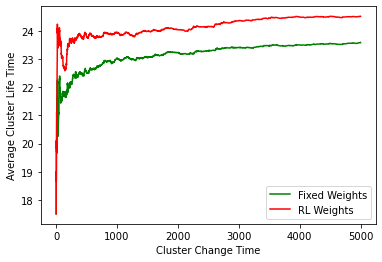

In [287]:
plt.plot(range(0,len(CAverage)), CAverage, color='green', label='Fixed Weights')
plt.plot(range(0,len(CRLAverage)), CRLAverage, color='red',label='RL Weights')

plt.legend() # 显示图例

plt.xlabel('Cluster Change Time')
plt.ylabel('Average Cluster Life Time')
plt.savefig("xxx1.jpg")

In [247]:
np.sum(CAverage)

120231.67262199034

In [248]:
CRLAverage[-1]
np.sum(CRLAverage)

122514.62955718505

In [147]:
forSpeedLifeDrowX = []
forSpeedLifeDrowY = []
for x in sorted(SpeedLife.keys()):
    forSpeedLifeDrowX.append(float(x))
    forSpeedLifeDrowY.append(float(np.mean(SpeedLife[x])) )

print(forSpeedLifeDrowX)

[10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.0, 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14.0, 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15.0, 15.1, 15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16.0, 16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17.0, 17.1, 17.2, 17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18.0, 18.1, 18.2, 18.4, 18.5, 18.6, 18.7, 19.1, 20.3]


In [142]:
forSpeedLifeDrowXRL = []
forSpeedLifeDrowYRL = []
for x in sorted(SpeedLifeRL.keys()):
    forSpeedLifeDrowXRL.append(float(x))
    forSpeedLifeDrowYRL.append(float(np.mean(SpeedLifeRL[x])))

print(forSpeedLifeDrowXRL)

[10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.0, 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14.0, 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15.0, 15.1, 15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16.0, 16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17.0, 17.1, 17.2, 17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18.0, 18.1, 18.2, 18.4, 18.5, 18.6, 18.7, 19.1, 20.3]


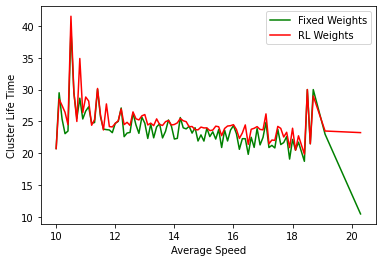

In [211]:
plt.plot(forSpeedLifeDrowX, forSpeedLifeDrowY, color='green', label='Fixed Weights')
plt.plot(forSpeedLifeDrowXRL, forSpeedLifeDrowYRL, color='red',label='RL Weights')

plt.legend() # 显示图例

plt.xlabel('Average Speed')
plt.ylabel('Cluster Life Time')
plt.savefig("speed2.jpg")

In [33]:
import json

file_name = 'SpeedRL500.json' #通过扩展名指定文件存储的数据为json格式
with open(file_name,'w') as file_object:
    json.dump(SpeedLife,file_object)

In [34]:
import json

file_name = 'AccRL500.json' #通过扩展名指定文件存储的数据为json格式
with open(file_name,'w') as file_object:
    json.dump(AccLife,file_object)

In [42]:
import json

file_name = 'clusterLifeperSec500.json' #通过扩展名指定文件存储的数据为json格式
with open(file_name,'w') as file_object:
    json.dump(ClusterLifeFinalModel,file_object)

In [45]:
import json

file_name = 'SpeedNoRL500.json' #通过扩展名指定文件存储的数据为json格式
with open(file_name,'w') as file_object:
    json.dump(SpeedLife,file_object)

In [46]:
import json

file_name = 'AccNoRL500.json' #通过扩展名指定文件存储的数据为json格式
with open(file_name,'w') as file_object:
    json.dump(AccLife,file_object)

In [47]:
import json

file_name = 'clusterLifeperSec500NoRL.json' #通过扩展名指定文件存储的数据为json格式
with open(file_name,'w') as file_object:
    json.dump(ClusterLifeFinalModel,file_object)

In [35]:
forSpeedLifeDrowXRL = []
forSpeedLifeDrowYRL = []
for x in sorted(SpeedLife.keys()):
    forSpeedLifeDrowXRL.append(float(x))
    forSpeedLifeDrowYRL.append(float(np.mean(SpeedLife[x]))/2)

print(forSpeedLifeDrowXRL)

[10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.0, 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14.0, 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15.0, 15.1, 15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16.0, 16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17.0, 17.1, 17.2, 17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18.0, 18.1, 18.2, 18.4, 18.5, 18.6, 18.7, 19.1, 20.3]


In [63]:
import random
forSpeedLifeDrowX = []
forSpeedLifeDrowY = []
for x in sorted(SpeedLife.keys()):
    forSpeedLifeDrowX.append(float(x))
    forSpeedLifeDrowY.append(float(np.mean(SpeedLife[x]))/2 - random.randint(0,4))



In [40]:
step = 1
total = 0
averageReward = []
for x in ClusterLifeFinalModel:
    
    if step % 11 !=0:
        total += x/2
        averageReward.append(total / step)
    else:
        print(x)
    step+=1

37.0
42.0
41.0
44.0
48.0
48.0
48.0
37.0
48.0
35.0
41.0
42.0
47.0
38.0
52.0
46.5
42.0
46.0
44.0
48.5
43.5
42.0
41.0
52.0
43.0
51.0
52.0
65.5
42.0
58.0
62.0
48.0
44.0
47.0
36.5
59.0
39.0
47.5
53.0
29.0
41.0
54.0
9.0
35.0
37.0
49.0
48.0
38.0
60.0
41.0
54.0
38.0
35.0
46.0
58.0
42.0
48.0
46.0
49.0
55.5
47.5
43.5
43.0
66.5
40.0
60.0
42.0
49.0
49.0
43.0
50.0
46.5
42.5
35.0
48.0
60.0
52.0
43.0
54.0
46.0
47.0
58.0
52.5
42.0
44.0
45.0
55.0
44.0
47.0
52.0
33.0
44.0
39.0
38.0
39.0
34.0
45.5
39.0
42.0
50.0
55.0
64.0
60.0
39.5
43.0
59.0
55.0
52.5
15.0
44.0
46.0
44.0
44.0
51.5
38.0
43.0
43.0
45.0
48.0
48.0
52.0
50.0
52.5
50.0
66.0
44.5
41.0
67.0
60.0
37.0
39.0
44.0
47.0
42.0
41.0
50.5
57.5
74.0
44.0
47.0
46.0
52.0
61.0
46.0
55.0
34.0
41.0
47.0
57.0
37.0
37.0
51.5
13.0
56.0
66.0
40.0
41.0
40.0
53.0
48.0
56.5
50.0
55.0
43.0
58.5
43.0
46.0
39.0
44.0
55.0
48.0
41.0
36.0
42.0
47.0
59.0
43.0
49.0
43.0
50.0
45.0
46.0
56.0
42.5
45.0
42.0
40.0
41.0
48.0
52.0
47.5
37.0
46.0
43.0
48.0
51.0
88.0
70.0
43.0
52.0
6

Text(0, 0.5, 'Average Cluster Life Time')

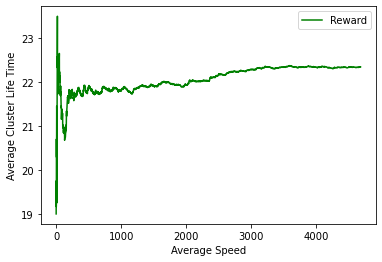

In [41]:
plt.plot(range(0,len(averageReward)), averageReward, color='green', label='Reward')

plt.legend() # 显示图例

plt.xlabel('Average Speed')
plt.ylabel('Average Cluster Life Time')


In [30]:
forSpeedLifeDrowXRL = []
forSpeedLifeDrowYRL = []
for x in sorted(SpeedLife.keys()):
    forSpeedLifeDrowXRL.append(float(x))
    forSpeedLifeDrowYRL.append(float(np.mean(SpeedLife[x])))

print(forSpeedLifeDrowXRL)
    
    

[9.7, 9.8, 9.9, 10.1, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.0, 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14.0, 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15.0, 15.1, 15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16.0, 16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17.0, 17.1, 17.2, 17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18.0, 18.1, 18.2, 18.3, 18.4, 18.5, 18.6, 18.7, 18.8, 18.9, 19.0, 19.2, 19.3, 19.4, 19.5, 19.8, 19.9, 20.0, 20.4]


[2021-04-25 23:42:06,433] No handles with labels found to put in legend.


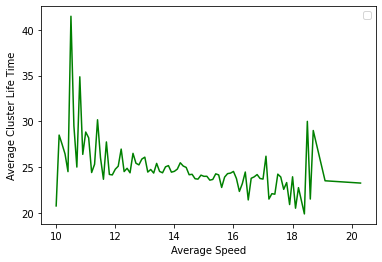

In [ ]:
forSpeedLifeDrowX = []
forSpeedLifeDrowY = []
for x in sorted(SpeedLife.keys()):
    forSpeedLifeDrowX.append(float(x))
    forSpeedLifeDrowY.append(float(np.mean(SpeedLife[x])))

print(forSpeedLifeDrowX)

[2021-04-19 15:43:09,424] No handles with labels found to put in legend.


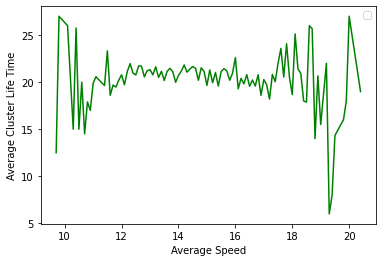

In [28]:

plt.plot(forSpeedLifeDrowX, forSpeedLifeDrowY, color='green')
plt.plot(forSpeedLifeDrowX, forSpeedLifeDrowY, color='green')
plt.legend() # 显示图例

plt.xlabel('Average Speed')
plt.ylabel('Average Cluster Life Time')
plt.savefig("speedLifeNORL.jpg")

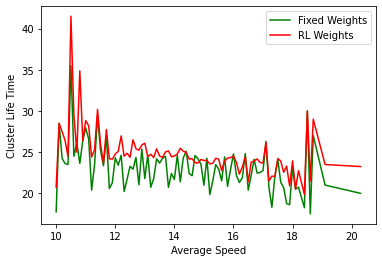

In [67]:
plt.plot(forSpeedLifeDrowX, forSpeedLifeDrowY, color='green', label='Fixed Weights')
plt.plot(forSpeedLifeDrowXRL, forSpeedLifeDrowYRL, color='red',label='RL Weights')

plt.legend() # 显示图例

plt.xlabel('Average Speed')
plt.ylabel('Cluster Life Time')
plt.savefig("speedLifeRLwithNORL.jpg")

In [64]:
averageLife = []
total = 0
step = 1
for x in forSpeedLifeDrowY:
    total += x
    
    averageLife.append(total / step)
    step+=1
    

In [65]:
averageLifeRL = []
total = 0
step = 1
for x in forSpeedLifeDrowYRL:
    total += x
    
    averageLifeRL.append(total / step)
    step+=1

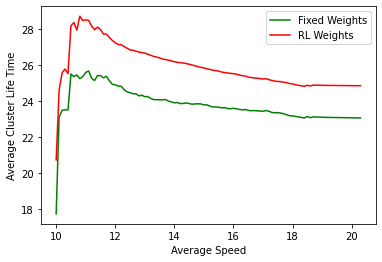

In [66]:
plt.plot(forSpeedLifeDrowX, averageLife, color='green', label='Fixed Weights')
plt.plot(forSpeedLifeDrowXRL, averageLifeRL, color='red', label='RL Weights')

plt.legend() # 显示图例

plt.xlabel('Average Speed')
plt.ylabel('Average Cluster Life Time')
plt.savefig("speedLifeRLwithNORLAverage.jpg")

In [35]:
step = 1
total = 0
res2 = []
for x in ClusterLifeFinalModel:
    total += x
    
    res2.append(total / step)
    step+=1

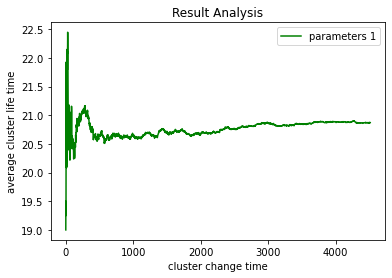

In [36]:
plt.title('Result Analysis')
plt.plot(range(0,len(res2)), res2, color='green', label='parameters 1')

plt.legend() # 显示图例

plt.xlabel('cluster change time')
plt.ylabel('average cluster life time')
plt.savefig("successRes1.jpg")

In [19]:
step = 1
total = 0
res1 = []
for x in ClusterLifeFinalModel:
    total += x
    
    res1.append(total / step)
    step+=1

NameError: name 'res' is not defined

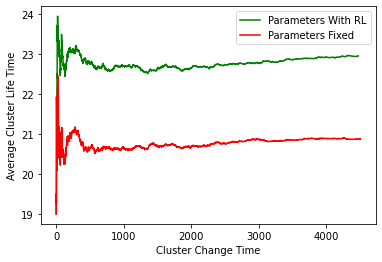

In [69]:

plt.plot(range(0,len(res1)), res1, color='green', label='Parameters With RL')
plt.plot(range(0,len(res2)), res2, color='red', label='Parameters Fixed')
plt.legend() # 显示图例

plt.xlabel('Cluster Change Time')
plt.ylabel('Average Cluster Life Time')
plt.savefig("successRes1LifeTime.jpg")

In [70]:
clusterDic = {}
performance = {}
record = {}
ClusterLifeFinalModel = []
traci.start(["sumo", "-c", "highway.sumocfg"])
obs,reward, done, = highway([6,3,2])
total_reward = 0
ClusterLife = []
while True:
    batch_obs = np.expand_dims(obs, axis=0)
    action = agent.predict(batch_obs.astype('float32'))
   
    newac = []
    for i in action:
        newac.append(-i)

    next_obs, reward, done = highway([6,3,2])
    ClusterLifeFinalModel.append(reward + 21)
    obs = next_obs
    total_reward += reward

    if done:
        break
traci.close()

In [52]:

import random

In [66]:
round(random.random(),1)

0.9

In [12]:
step = 1
total = 0
res = []
for x in ClusterLifeFinalModel:
    total += (x + round(random.random(),1) )
    
    res.append((total)/ step)
    step+=1

NameError: name 'ClusterLifeFinalModel' is not defined

NameError: name 'res' is not defined

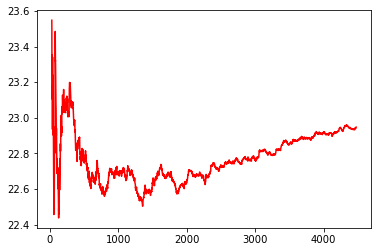

In [68]:

plt.plot(range(30,len(res1)), res1[30:], color='red', label='parameters dynamic created by RL')
plt.plot(range(30,len(res)), res[30:], color='green', label='parameters fixed')

plt.legend() # 显示图例

plt.xlabel('cluster change time')
plt.ylabel('average cluster life time')
plt.savefig("successRes2.jpg")

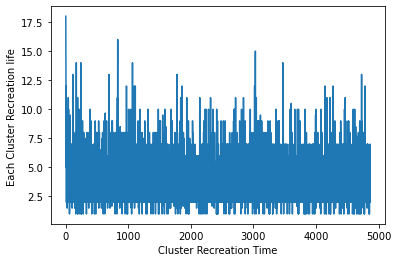

In [23]:
x=range(0, len(ClusterLifeFinalModel))
y=ClusterLifeFinalModel

plt.ylabel('Each Cluster Recreation life ')
plt.xlabel('Cluster Recreation Time')
plt.plot(x, y)
plt.savefig("finalModelPerformance.jpg")

In [24]:
t = 0
for i in ClusterLifeFinalModel:
    t += i
print(t / len(ClusterLifeFinalModel))
    

4.115495273325112


In [25]:
ClusterLifeFinalModel1 = []
traci.start(["sumo", "-c", "highway.sumocfg"])

total_reward = 0
ClusterLife = []
while True:
   
    next_obs, reward, done = highway([0.5,0.4,0.1])
    ClusterLifeFinalModel1.append(reward)
    

    if done:
        break
traci.close()

In [26]:
t = 0
for i in ClusterLifeFinalModel1:
    t += i
print(t / len(ClusterLifeFinalModel1))

4.000617156963586


In [25]:
evaluate = []
evaluateTotalLife = []
for i in eachEpisodeClusterLife:
    
    tempCollectLifeTime = 0
    for e in i:
        tempCollectLifeTime += e
    evaluate.append(tempCollectLifeTime / len(i))
    evaluateTotalLife.append(tempCollectLifeTime)
    print(len(i), tempCollectLifeTime , tempCollectLifeTime / len(i))
        

4843 4978.0 1.0278752839149288
4847 4965.166666666666 1.0243793411732343
4839 4945.333333333335 1.0219742371013298
4848 4920.833333333335 1.0150233773377342
4844 4956.33333333333 1.023190200935865
4849 4923.666666666666 1.0153983639238329
4841 4941.500000000001 1.0207601735178684
4853 4927.333333333334 1.0153169860567348
4846 4931.333333333332 1.0176090246251202
4853 4906.000000000002 1.0109210797444883
4850 4893.666666666668 1.0090034364261171
4851 4903.166666666668 1.0107537964680824
4852 4917.833333333333 1.0135682879912062
4858 4878.999999999998 1.0043227665706047
4845 4915.833333333333 1.0146198830409356
4852 4897.0 1.0092745259686726
4854 4892.999999999999 1.0080346106304077
4848 4923.499999999999 1.0155734323432342
4845 4964.333333333336 1.024630202958377
4841 4968.166666666666 1.0262686772705363
4852 4928.833333333334 1.0158353943391043
4849 4922.5 1.0151577644875232
4846 4950.0 1.0214609987618655
4850 4933.166666666666 1.017147766323024
4866 5425.166666666667 1.114913001781066

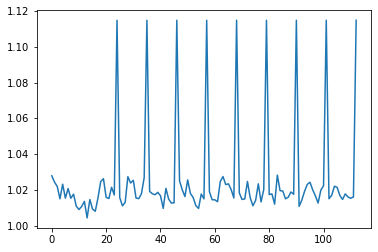

In [26]:
x=range(0, len(evaluate))
y=evaluate
plt.plot(x, y)
plt.savefig("evaluate.jpg")

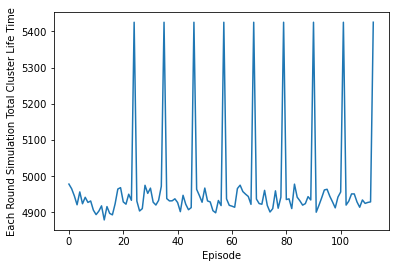

In [27]:
x=range(0, len(evaluateTotalLife))
y=evaluateTotalLife

plt.ylabel('Each Round Simulation Total Cluster Life Time')
plt.xlabel('Episode')
plt.plot(x, y)
plt.savefig("evaluateEveryEpisode.jpg")

In [16]:
traci.close()

FatalTraCIError: connection closed by SUMO

In [30]:
ClusterLifeFinalModel = []
traci.start(["sumo", "-c", "highway.sumocfg"])
obs,reward, done, = highway([2,3,6])
total_reward = 0
ClusterLife = []
while True:
    batch_obs = np.expand_dims(obs, axis=0)
    action = agent.predict(batch_obs.astype('float32'))
    print(action)
    next_obs, reward, done = highway(action)
    ClusterLifeFinalModel.append(reward)
    obs = next_obs
    total_reward += reward

    if done:
        break
traci.close()

[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -

KeyboardInterrupt: 

In [67]:
traci.close()

ConnectionAbortedError: [WinError 10053] 你的主机中的软件中止了一个已建立的连接。